In [1]:
%%HTML
<style type="text/css">

h1 {
    text-align: center; 
    background-color: #D10E40; 
    padding: 5px; 
    font-size: 30px; 
}
</style>

In [2]:
import re

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import gensim
from tqdm import tqdm
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

sns.set()
plt.rcParams.update({
    'figure.figsize': (16, 13),
    'axes.titlesize' : 20,
    'axes.titlepad': 18,
    'axes.labelsize': 18,
    'axes.labelpad': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,

#     'figure.titleweight': 'heavy',
#     'figure.edgecolor': 'k',
#     'lines.linewidth' : 3,
#     'image.cmap': 'Reds'
})

from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import warnings
warnings.filterwarnings("ignore")

stop = stopwords.words('english') + stopwords.words('spanish') + stopwords.words('french')

grey = '#828689'
grad3 = ['#E1A29F', '#D10E40', '#9A131F']
grad4 = ['#62194A', '#9A131F', '#D10E40', '#E1A29F']
qualitative = ['#D10E40', '#3E779D', '#6C164D', '#9A131F', '#C54227', '#90619B', '#DA4F57', '#477F67', '#EB7023', '#E1A29F']

palette = ['#D10E40', '#4E8AC9', '#EB7023']
palette_r = list(reversed(palette))

# grey = '#979EA4'
# palette = ['#C41102', '#4E8AC9', '#E76335']
# palette_r = ['#E76335', '#4E8AC9', '#C41102']
# palette2 = ["#7D0744", "#4E8AC9", '#E76335']
CITY_GROUP = ['CDP Region', 'Country', 'City', 'Account Number']

<h1  style="color: #FFFFFF" id="executive-summary">1 Executive Summary</h1>
<br>

The following report is a submission to the CDP: Unlocking Climate Solutions Kaggle Competition. Over the course of this competition, we have learnt a lot, not only from the intensive research required to tackle the problem statement, but also from analysing the vast repository of data CDP made available.

The objective of this report was to analyse the issues of inequality while developing KPIs that address climate change. Our key findings related to these issues are as follows:
- Most cities face medium to high levels of climate exposure, resulting in effects that will be felt universally, however, the poorest and elderly populations will see a disproportionate amount of the impact directed towards them.
- These impacts will lead to significant increases in crime and conflict, and fluctuating socioeconomic conditions. These will be closely related to increases in demand for resources.
- Climate change will also play a significant role in aggravating health issues, particularly for those already vulnerable, which will put additional stress on and disrupt healthcare services due to increasing demands.
- Cities facing high levels of exposure can adopt relevant adaptation actions to build resilience to battle climate risks. However, a number of cities face serious shortages of resources  which may seriously hamper their ability to adapt.
- Cities can be incentivized to adopt early adaptation efforts by identifying parallel opportunities for social and economic benefit.
- A number of cities face serious shortages of resources which may seriously hamper their ability to adapt.
- There is a bilateral relationship between the impact corporations have on the environment, and the level of financial liability they face from climate change. Further, there is a correlation between the climate risks they face and the broader social issues that co-occur with these risks.
- There is a noticeable lack of questions addressing the social issues related to, and arising from, climate change in the CDP Corporations Climate Change Questionnaire.
- There are strong positive correlations between emissions and GDP, but also more developed cities find it easier to implement emission reduction actions - highlighting how they should take a leading role in tackling Global Warming.
- Corporations in the Fossil Fuel/Energy and Transportation industries contribute inordinately towards GHG emissions, due to which they have a greater potential of reducing emissions.
- There is currently a divide between the developed and developing world in the amount of energy generated from renewable sources. Due to unequal conditions, poorer cities may find it difficult to install sufficient sources of renewable energy to balance out their use of unclean fuels, and thereby have to depend even more on fossil fuels.
- A small proportion of all corporations, such as those in the manufacturing and materials industries consume much higher proportions of electricity than others, shedding light on the disparity in available resources in electricity poor parts of the world.
- Corporate fuel use is a direct cause of adverse effects on human health, and can be connected to deaths due to air pollution and accidents in low visibility conditions. 
- Electricity generation for corporate use results in significant amounts of water consumption. Corporations, especially those part of the energy sector, must pay special attention to this to avoid worsening water related issues.
- A significant number of corporate facilities source their water from resources that are water-stressed or located in water-stressed regions, worsening the problems related to water-scarcity.
- The existence of shared opportunities and risks between cities and corporations presents added incentives for the two to work together in solving key climate issues.


<h2 style="text-align:center">KPI Summary Table</h2>

In [3]:
metric_table = [
    ["City Vulnerability", 
     "The susceptibility of cities to the possible risks and negative impacts of climate change, due to inadequate preparedness, high exposure, or both.", 
     "$Vulnerability_{city} = \\sum_{i=1}^{climateHazards}max(0, ClimateExposure_{i} - Preparedness_{i})$", "", "", ""],
    ["Adaptation Incentive", 
     "Motive for cities to adapt to climate change.", 
     "$Adaptation Incentive_{city} = \\sum_{i=1}^{climate Hazards}(Vulnerability_{i} + OpportunityPayoff_{i})$", "", "", ""],
    ["Adaptability", 
     "Ability of a city to adapt to climate change.", 
     "$Adaptability_{city} = AdaptabilityFactor_{city} \\times Proactiveness_{city} \\times (10 \\times HumanCapitalScore + \\log_{10}(1 + Funding))$", "", "", ""],
    ["Climate Liability", 
     "A measure of the total risk to corporations from aggregated financial impacts of climate change.", 
     "$ClimateLiability_{org} = \\sum_{i=1}^{risks}(LiabilityFactor_{i} \\times TotalCost_{i})$", "", "", ""],
    ["Lifetime Mitigation Score", 
     "Lifetime performance (or utility) of a city's emission mitigation action at reducing direct and indirect emissions of CO2 equivalencies.", 
     "$LifetimeMitigationScore = \\log_{10}(1 + DirectEmissionReduction_{metricTonnesCO2e}) + \\log_{10}(1 + IndirectEmissionReduction_{metricTonnesCO2e}) - \\log_{10}(1 + CostOfProject)$", "", "", ""],
    ["Reduction Initiative Score", 
     "The utility of a corporate emission reduction initiative at reducing CO2 equivalent emissions.", 
     "$ReductionInitiativeScore_{lifetime} = \\log_{10}(1 + AnnualCO_{2}eSavings \\times Lifetime) + \\log_{10}(1 + AnnualMonetarySavings \\times Lifetime) - \\log_{10}(1 + TotalLifetimeInvestment)$", "", "", ""],
    ["Renewable Energy Public Demand", 
     "Years of renewable energy generation required, at the current capacity, to meet annual energy demand for a city.", 
     "$Demand_{years} = \\frac{TotalEnergyUse_{MWh}}{RenewableEnergyCapacity_{MW} \\times 8760}$", "", "", ""],
    ["Corporate Electricity Greed", 
     "Measure of corporate electricity consumption as a percentage of the global electricity poverty.", 
     "$CorporateElectricityGreed = \\frac{Total Electricity Consumption_{MWh}}{GlobalElectricityPoverty} \\times 100$", "", "", ""],
    ["Deaths by Corporate Fuel Use", 
     "Number of deaths caused due to corporations' choice of fuels for energy generation.", 
     "$NoOfDeaths = \\sum_{i=1}^{fuels}Fuel Consumption(TWh)_{i} \\times DeathsPerTWh_{i}$", "", "", ""],
    ["Water Cost of Electricity", 
     "Gallons of upstream water consumed for purposes relating to the generation of electricity.", 
     "$Water Cost_{gallons} = \\sum_{i=1}^{fuels}ElectricityConsumed(kWh)_{i} \\times WaterConsumptionFactor_{i}$", "", "", ""],
    ["Unsustainable Water Use", 
     "Measure of water consumption from water-stressed regions and resources.", 
     "$UnsustainableWaterUse = \\sum_{i=1}^{facilites}(WaterStressScore_{i} \\times \\log_{10}(1 + WaterConsumption_{i}))$", "", "", ""],
    ["Collaboration Strength", 
     "A measure of the joint interest and expected mutual benefits from collaborative partnerships between cities and corporations on shared risks, opportunities, and initiatives.", 
     "$CollaborationStrength_{city,org}  = SharedRisk \\times CommonOpportunities \\times \\mathtt{SERO}Score_{city,org}$", "", "", ""]
]

children= []
for i, row in enumerate(metric_table):
    display = ''
    for j, col in enumerate(row[1:3]):
        if j==0:
            display += f"<i>{col}</i><br><br>"
        elif j==1:
            display += col + "<br><br>"
    display += f'<a href="https://www.kaggle.com/mannmann2/kpis-for-measuring-climate-action-and-inequality#metric{i+1}">Go to metric</a>'
    children.append(widgets.HTMLMath(value=display))
                        
accordian = widgets.Accordion(children=children)

for i in range(len(children)):
    accordian.set_title(i, f"Metric {i+1}: {metric_table[i][0]}")

accordian

Accordion(children=(HTMLMath(value='<i>The susceptibility of cities to the possible risks and negative impacts…

<h1 style="color: #FFFFFF" id="introduction">2 Introduction</h1>  

<h2 id="cdp">2.1 Carbon Disclosure Project</h2>

As the world tries to tackle a global pandemic, cities and corporations, large and small are focused on reassessing their long term and short term growth. There exists a strong focus on the societal impact that climate change plays in order for communities to thrive and survive. The long term lens has made it imperative now more than ever to look beyond and create a sustainable future, a future where cities and businesses work together to evaluate, rehabilitate and safeguard the world. 

[Carbon Disclosure Project (CDP)](https://www.cdp.net/en/info/about-us) a not-for-profit charity is working on accelerating an economic transition that works for the people and planet in the long term. CDP runs the global disclosure system for investors, companies, cities, states and regions to manage their environmental impacts on climate change, water security and deforestation. The disclosure system tracks the thousands of companies, cities, states and regions that supply information in its annual reporting process, and scores companies and cities based on their journey through disclosure and towards environmental leadership. The world’s economy looks to CDP as the gold standard of environmental reporting with the richest and most comprehensive dataset on corporate and city action to measure and manage their risks and opportunities.

<h2 id="21st-century-problem">2.2 21st Century Problem</h2>

The data provided through the Questionnaires by CDP gives insight into the environmental impact of cities and corporations. As the data continues to grow, there is great potential in how these insights could be used in a consequential way. According to the [United Nations Human Development Report, 2019](http://report.hdr.undp.org/), there exists an important issue which is often ignored when we consider the emerging and existing risks that we will face in the 21st century - the interwovenness of Climate Change and Inequality. Through this report, we aim to focus on the importance of integrating social equity into climate action. Using data from the questionnaires along with external datasets we aim to develop actionable Key Performance Indicators that can be adopted to track climate action geared towards solving social and environmental issues.
 
<h2 id="journey-through-the-portal">2.3 Journey through The Portal</h2>

We start this report by presenting the problem statement as defined by CDP/Kaggle (Section 3).

We then move on to an explanation of our framework and methodology for developing KPIs (Section 4). Once these have been introduced, we provide a short overview of the various datasets used throughout the notebook (Section 5), and then dive into building our KPIs (Sections 6, 7, 8). The focus of our KPIs is on 3 main areas. 

- In Section 6, we look at Vulnerability and establish ways to measure the impact of climate change on cities and corporations, while discussing the broader social implications of these risks.
- In Section 7, we look at 3 individual themes - Emissions, Energy, and Water - relating to Climate Impact, and assess the effect activities undertaken in these areas may have on making a more equitable society, or inversely, furthering social inequality and division.
- In Section 8, we suggest a way to measure the Collaboration ability of cities and organizations to partner with one another and work together on mitigating shared risks and realizing their common goals and ambitions.

Finally, we offer our final recommendations and closing thoughts in the Key Takeaways (Section 9).

<h1 style="color: #FFFFFF" id="problem-statement">3 Problem Statement</h1>

<br>

As per the [competition website](https://www.kaggle.com/c/cdp-unlocking-climate-solutions), the problem statement is as follows:

Develop a methodology for calculating key performance indicators (KPIs) that relate to the environmental and social issues that are discussed in the CDP survey data. Leverage external data sources and thoroughly discuss the intersection between environmental issues and social issues. Mine information to create automated insight generation demonstrating whether the city and corporate ambitions take these factors into account.

The website also provides a set of questions that could be used as guidelines when attempting a solution to the problem statement.

- How do you help cities adapt to a rapidly changing climate amidst a global pandemic, but do it in a socially equitable way?
- What are the projects that can be invested in that will help pull cities out of a recession, mitigate climate issues, but not perpetuate racial/social inequities?
- What are the practical and actionable points where city and corporate ambition join, i.e. where do cities have problems that corporations affected by those problems could solve, and vice versa?
- How can we measure the intersection between environmental risks and social equity, as a contributor to resiliency?

<h1 style="color: #FFFFFF" id="methodology">4 Methodology</h1>

<img src="https://i.pinimg.com/564x/1b/cb/87/1bcb8744497dca3ac1f44a5540cb3a58.jpg" width=600><br>

Climate Change and Social inequality are extremely complex issues that require a holistic approach to developing solutions. The current movement to transition to net-zero, at its core is a collective good, but there will always be disagreements and debates when it comes to creating a direction for sustainability transitions due to the ambiguous and contested nature of the concept. Keeping this in mind, we realised that to push for ambitious actions towards a collective good, we had to develop metrics that are able to prove accountability across our three main themes of Vulnerability, Climate Impact and Collaboration. Thereafter, using the data from the CDP questionnaires and a few of the external datasets, we were able to establish a relationship between inequality (in various contexts) and climate change, and bring to light unique properties which may not be visible when looking at the constituent parts separately from a reductionist approach.

The systemic nature of climate change based inequality required us to zoom out and look at its functioning as a whole unit. This is why we decided to apply a broad lens and analyse the data at the global level - because we understand that the performance of climate action and the nature of inequality varies in every country based on human capital, resources, technological advancements etc, and focusing with a narrow lens would give room for implicit biases to play out. This approach resulted in many of our personal biases not being justified when it came to looking at the data, in fact we saw them crash before our eyes, and this allowed us to gain new insights which contributed to helping us build _impact_ metrics that could be easily compared between cities and corporations for different regions.

While the KPIs we developed were not exclusive to the S.M.A.R.T (Specific, Measurable, Attainable, Relevant, Time-bound) approach, this principle was crucial in building a foundation when it came to the process of selecting relevant metrics.

<h1 style="color: #FFFFFF" id="datasets-used">5 Datasets Used</h1>

In [4]:
# using the given city administative organizations in the disclosure data we create a mapping between 
# account numbers and city names for some of the cities which do not have a value in the 'City' column
# this will be used to match OECD economic data with the CDP cities 
ACCOUNT_MAPPING = {
    74643: 'Dijon',
    50377: 'Queretaro',
    74607: 'Alkmaar',
    833284: 'West Midlands urban area',
    50540: 'Albuquerque',
    74575: 'Dane',
    74534: 'Erie (NY)',
    74563: 'Guilford',
    74546: 'Milwaukee',
    832610: 'Orange',
    59531: 'Santa Barbara',
    74558: 'Summit',
    834373: 'York'
}

# used in city_gdp
COUNTRY_CODES = {
    'AT': 'Austria',
    'AUS': 'Australia',
    'BE': 'Belgium',
    'CAN': 'Canada',
    'CH': 'Switzerland',
    'CL': 'Chile',
    'CZ': 'Czech Republic',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'EL': 'Greece',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IT': 'Italy',
    'JPN': 'Japan',
    'KOR': 'Republic of Korea',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'MEX': 'Mexico',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PL': 'Poland',
    'PT': 'Portugal',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovakia',
    'UK': 'United Kingdom of Great Britain and Northern Ireland',
    'USA': 'United States of America'
}

# used in city_gdp
NORM_CITY_NAMES = {
    'Montreal': 'Montréal',
    'Zurich': 'Zürich',
    'Mannheim-Ludwigshafen': 'Mannheim',
    'Malaga': 'Málaga',
    'Vitoria': 'Vitoria-Gasteiz',
    'Florence': 'Firenze',
    'Genoa': 'Genova',
    'Milan': 'Milano',
    'Naples': 'Napoli',
    'Padua': 'Padova',
    'Reggio nell\'Emilia': 'Reggio Emilia',
    'Rome': 'Roma',
    'Turin': 'Torino',
    'Venice': 'Venezia',
    'Merida': 'Mérida',
    'Gdansk': 'Gdańsk',
    'Gothenburg': 'Göteborg',
    'Greater Adelaide': 'Adelaide',
    'Greater Melbourne': 'City of Melbourne',
    'Greater Perth': 'Perth',
    'Greater Sydney': 'City of Sydney',
    'Malmo': 'Malmö',
    'West Midlands urban area': 'Birmingham',
    'Detroit (Greater)': 'Detroit',
    'Durham': 'Durham, NC',
    'Fresno (Greater)': 'Fresno',
    'Lancaster (PA)': 'Lancaster, PA',
    'Los Angeles (Greater)': 'Los Angeles',
    'Miami (Greater)': 'Miami',
    'New York (Greater)': 'New York City',
    'Philadelphia (Greater)': 'Philadelphia',
    'Portland': 'Portland, OR',
    'Richmond (Greater)': 'Richmond, VA',
    'Rochester (NY)': 'Rochester',
    'Salt Lake': 'Salt Lake City',
    'San Francisco (Greater)': 'San Francisco',
    'Santa Cruz': 'Santa Cruz, CA',
    'St. Louis': 'St Louis',
    'Washington (Greater)': 'Washington, DC'
}

# used in energy_use
COUNTRY_NAMES = {
    'Bolivia': 'Bolivia (Plurinational State of)',
    'Democratic Republic of Congo': 'Democratic Republic of the Congo',
    'Hong Kong': 'China, Hong Kong Special Administrative Region',
    'Moldova': 'Republic of Moldova',
    'Palestine': 'State of Palestine',
    'Russia': 'Russian Federation',
    'South Korea': 'Republic of Korea',
    'Taiwan': 'Taiwan, Greater China',
    'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
    'United States': 'United States of America',
    'Venezuela': 'Venezuela (Bolivarian Republic of)',
    'Vietnam': 'Viet Nam'
}

# used in corp_locations
STATE_CODES = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'Ca': 'CA',
    'California': 'CA',
    'Colorado': 'CO',
    'COLORADO': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'ALBERTA': 'AB',
    'Quebec': 'QC',
    'Manitoba': 'MB',
    'Ontario': 'ON'
}

1. The **CDP: Unlocking Climate Solutions** [Competition Data](https://www.kaggle.com/c/cdp-unlocking-climate-solutions/data): The following sub-classes of the data provided by CDP have been used throughout this notebook.
    - Cities Disclosing
    - Cities Responses
    - Corporations Disclosing
    - Corporations Responses
    - Locations of Corporations
1. [Human Capital Index (HCI) 2020](https://datacatalog.worldbank.org/dataset/human-capital-index) (World Bank): This dataset provides a measure of the human capital expected to be available "given the risks of poor health and poor education prevailing in the country."
1. [Corporate Environmental Impact](https://www.hbs.edu/impact-weighted-accounts/Pages/default.aspx) (HBS - Impact Weighted Accounts): Provides monetization factors for measuring the total environmental impact of corporations in dollars. 
1. [Economic Indicators for OECD Cities](https://stats.oecd.org/Index.aspx?DataSetCode=CITIES): Provides key economic indicators like GDP and GDP per capita for OECD cities.
1. Energy data from [Our World in Data](https://ourworldindata.org/): Provides a number of statistics a relating to energy access and consumption.
    - [Per capita Energy Consumption](https://ourworldindata.org/grapher/per-capita-energy-use)
    - [People Without Electricity](https://ourworldindata.org/energy-access)
    - [Per capita Electricity Consumption](https://ourworldindata.org/grapher/per-capita-electricity-consumption)
1. Water related data from [WRI](https://www.wri.org):
    - [Water Use Embedded in Purchased Electricity](https://www.wri.org/resources/data-sets/dataset-guidance-calculating-water-use-embedded-purchased-electricity): Provide a way to calculate water consumption during eleectricity generation from common fuels.
    - [Aqueduct Baseline Water Stress](https://www.wri.org/publication/aqueduct-country-and-river-basin-rankings): Ranks countries and major river basins by their level of water stress.
1. Additional Public Datasets from Kaggle:
    - [Annual Financial Data for Hybrid Metrics](https://www.kaggle.com/takahirokubo0/annual-financial-data-for-hybrid-cdp-kpi) (SimFin): Provides financial metics, such as Revenue and EBITDA, for corporates disclosing to CDP.
    - [ISO-3166 Country Mappings](https://www.kaggle.com/andradaolteanu/country-mapping-iso-continent-region): Provides a 3 digit iso codes for counties and regions to facilite choropleth geomaps in plotly.
    - [Google's Word2Vec Vectors](https://www.kaggle.com/umbertogriffo/googles-trained-word2vec-model-in-python): Pre-trained word embeddings from Google, trained on a 100 billion word dataset from Google News.

In [5]:
# LOAD CITY DATA
PATH = '../input/cdp-unlocking-climate-solutions/Cities/'

# disclosing data
cd2020 = pd.read_csv(PATH + "Cities Disclosing/2020_Cities_Disclosing_to_CDP.csv")
cd2019 = pd.read_csv(PATH + "Cities Disclosing/2019_Cities_Disclosing_to_CDP.csv")
cd2018 = pd.read_csv(PATH + "Cities Disclosing/2018_Cities_Disclosing_to_CDP.csv")
cities_dis = pd.concat([cd2020, cd2019, cd2018])

# getting city name from ACCOUNT MAPPING
cities_dis['City'] = cities_dis['City'].fillna(cities_dis['Account Number'].map(ACCOUNT_MAPPING))

# response data
cr2020 = pd.read_csv(PATH + "Cities Responses/2020_Full_Cities_Dataset.csv")
cr2019 = pd.read_csv(PATH + "Cities Responses/2019_Full_Cities_Dataset.csv")
cr2018 = pd.read_csv(PATH + "Cities Responses/2018_Full_Cities_Dataset.csv")
cities_res = pd.concat([cr2020, cr2019, cr2018])

# merging disclosing data with response data
cities = pd.merge(cities_dis, cities_res, 'inner', on=['Year Reported to CDP', 'Account Number', 'Organization', 'Country', 'CDP Region',])
# the following columns contain data we do not need, and are dropped
cities.drop(columns=['Access', 'File Name', 'Last update_x', 'Last update_y'], inplace=True)


# creating population dataframe using the most recent values present in the disclosure data
population = cities_dis[['City', 'Account Number', 'Year Reported to CDP', 'Population']].dropna(subset=['Population']).reset_index(drop=True)
population = population.loc[population.groupby(['City', 'Account Number'])['Year Reported to CDP'].idxmax()].set_index(['City', 'Account Number'])['Population']


# creating a city location dataframe to facilitate geo-plotting 
city_locations = cities_dis[['Country', 'City', 'Account Number', 'City Location']].drop_duplicates().dropna(subset=['City Location']).set_index('City')
city_locations[['lon', 'lat']] = city_locations['City Location'].apply(lambda x: pd.Series(x.split("POINT ")[1].strip('()').split())).astype('float32')

#fixing inverted coordinates
for org in ['Mississauga', 'Norfolk', 'Aurora', 'South Bend', 'San José']:
    city_locations.at[org, 'lat'], city_locations.at[org, 'lon'] = city_locations.loc[org]['lon'], city_locations.loc[org]['lat']
# Aurora also has the negative sgin missing
city_locations.at['Aurora', 'lon'] = -city_locations.loc['Aurora']['lon']
city_locations = city_locations.set_index('Country', append=True)


# deleting temperory variables
del cities_res, cd2018, cd2019, cr2018, cr2019, cr2020
# ------------------------------------------------------

# LOAD CLIMATE DATA
PATH2 = '../input/cdp-unlocking-climate-solutions/Corporations/'

# disclosing
cd_cc2018 = pd.read_csv(PATH2 + 'Corporations Disclosing/Climate Change/2018_Corporates_Disclosing_to_CDP_Climate_Change.csv')
cd_cc2019 = pd.read_csv(PATH2 + 'Corporations Disclosing/Climate Change/2019_Corporates_Disclosing_to_CDP_Climate_Change.csv')
cd_cc2020 = pd.read_csv(PATH2 + 'Corporations Disclosing/Climate Change/2020_Corporates_Disclosing_to_CDP_Climate_Change.csv')
cc_dis = pd.concat([cd_cc2020, cd_cc2019, cd_cc2018])

# responses
cr_cc2018 = pd.read_csv(PATH2 + 'Corporations Responses/Climate Change/2018_Full_Climate_Change_Dataset.csv')
cr_cc2019 = pd.read_csv(PATH2 + 'Corporations Responses/Climate Change/2019_Full_Climate_Change_Dataset.csv')
cr_cc2020 = pd.read_csv(PATH2 + 'Corporations Responses/Climate Change/2020_Full_Climate_Change_Dataset.csv')
cc_res = pd.concat([cr_cc2020, cr_cc2019, cr_cc2018])

# merge disclosing data with responses
climate = pd.merge(cc_dis, cc_res, 'inner', on=['survey_year', 'account_number', 'organization', 'response_received_date'])

# delete temporary variables
del cc_res, cd_cc2018, cd_cc2019, cd_cc2020, cr_cc2018, cr_cc2019, cr_cc2020
# ------------------------------------------------------

# LOAD WATER SECURITY DATA
PATH2 = '../input/cdp-unlocking-climate-solutions/Corporations/'

# disclosing
cd_ws2018 = pd.read_csv(PATH2 + 'Corporations Disclosing/Water Security/2018_Corporates_Disclosing_to_CDP_Water_Security.csv')
cd_ws2019 = pd.read_csv(PATH2 + 'Corporations Disclosing/Water Security/2019_Corporates_Disclosing_to_CDP_Water_Security.csv')
cd_ws2020 = pd.read_csv(PATH2 + 'Corporations Disclosing/Water Security/2020_Corporates_Disclosing_to_CDP_Water_Security.csv')
ws_dis = pd.concat([cd_ws2020, cd_ws2019, cd_ws2018])

# responses
cr_ws2018 = pd.read_csv(PATH2 + 'Corporations Responses/Water Security/2018_Full_Water_Security_Dataset.csv')
cr_ws2019 = pd.read_csv(PATH2 + 'Corporations Responses/Water Security/2019_Full_Water_Security_Dataset.csv')
cr_ws2020 = pd.read_csv(PATH2 + 'Corporations Responses/Water Security/2020_Full_Water_Security_Dataset.csv')
ws_res = pd.concat([cr_ws2020, cr_ws2019, cr_ws2018])

# merge disclosing and response data
water = pd.merge(ws_dis, ws_res, 'inner', on=['survey_year', 'account_number', 'organization', 'response_received_date'])

# delete temporary variables
del ws_res, cd_ws2018, cd_ws2019, cd_ws2020, cr_ws2018, cr_ws2019, cr_ws2020
# ------------------------------------------------------

# loading national human capital index data
human_capital = pd.read_csv('../input/human-capital-index-2020-the-world-bank/hci_MaleFemale_september_2020.csv').replace('-', np.nan)

# normalize country names as per CDP values
human_capital['Country Name'] = human_capital.replace({
    'Bolivia': 'Bolivia (Plurinational State of)',
    'Hong Kong SAR, China': 'China, Hong Kong Special Administrative Region',
    'Gb': 'Gibraltar',
    'Mn': 'Monaco',
    'Korea, Rep.': 'Republic of Korea',
    'Palestine': 'State of Palestine',
    'Taiwan': 'Taiwan, Greater China',
    'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
    'Tanzania': 'United Republic of Tanzania',
    'United States': 'United States of America',
})

human_capital.set_index(['Country Name'], inplace=True)
# ------------------------------------------------------

# loading corporate environmental impact data
corp_env_impact = pd.read_csv('../input/corporate-environmental-impact/final_raw_sample_0_percent.csv')
# filter on US and Canadian companies
corp_env_impact = corp_env_impact[corp_env_impact['Country'].isin(['United States', 'Canada'])]
# select most recent year's data
corp_env_impact = corp_env_impact.loc[corp_env_impact.groupby('Company Name')['Year'].idxmax()]

# cleaning corporation names to facilitate matching with CDP data
corp_env_impact['cleaned_name'] = corp_env_impact['Company Name'].str.lower() \
.replace(re.compile('[, ](co|corp|cos|llc|ltd|inc)\.'), '') \
.replace(re.compile('[, ](co|corp|company|corporation|cos|plc|llc|ltd|incorporation|incorporated|inc)$'), '') \
.replace(re.compile("[!\.,\"'&]"), '').str.replace('-', ' ') \
.replace(re.compile('^the '), '').replace(re.compile('\s+'), ' ').str.strip()

corp_env_impact['Country'] = corp_env_impact['Country'].replace({'United States': 'United States of America'})
corp_env_impact.set_index(['Country', 'cleaned_name'], inplace=True)
# ------------------------------------------------------

# oecd metropolitan gdp dataset
city_gdp = pd.read_csv('../input/economic-indicators-for-oecd-metropolitan-areas/CITIES_17112020134646826.csv')
# normalize city names and get country from codes
city_gdp['City'] = city_gdp['Metropolitan areas'].replace(NORM_CITY_NAMES)
city_gdp['Country'] = city_gdp['METRO_ID'].str.rstrip('0123456789').map(COUNTRY_CODES)

city_gdp = city_gdp.drop('Metropolitan areas', axis=1) \
                   .pivot(index=['Country', 'City', 'Year'], columns='VAR', values=['Value'])['Value'].reset_index()

# selecting most recent data by extracting for max value for year for each city
city_gdp = city_gdp.loc[city_gdp.groupby(['Country', 'City'])['Year'].idxmax()].set_index(['Country', 'City'])
# ------------------------------------------------------

# loading per capita energy use data
energy_use = pd.read_csv('../input/world-per-capita-energy-consumption/per-capita-energy-use.csv')
# rename countries as per CDP
energy_use['Country'] = energy_use['Entity'].replace(COUNTRY_NAMES)
# select latest data for each country
energy_use = energy_use.loc[energy_use.groupby('Code')['Year'].idxmax()].drop(['Entity', 'Year'], axis=1).set_index('Country').sort_index()
# ------------------------------------------------------

# loading electricity access data
people_without_electricity = pd.read_csv('../input/people-without-electricity/people-without-electricity-country.csv') \
.set_index(['Entity', 'Year']).loc['World', 2016]['Number of people without access to electricity']

population_with_electricity = pd.read_csv('../input/people-without-electricity/share-of-the-population-with-access-to-electricity.csv')
population_with_electricity['% without access'] = 100 - population_with_electricity['Access to electricity (% of population)']
# ------------------------------------------------------

# loading per capita electricity consumption data
global_pc_electricity_consumption = pd.read_csv('../input/per-capita-electricity-consumption/per-capita-electricity-consumption.csv').set_index('Entity')
# extract the most recent data for the world
global_pc_electricity_consumption = global_pc_electricity_consumption[global_pc_electricity_consumption['Year']==2019].loc['World']
# ------------------------------------------------------

# loading water consumption factor data
water_factor = pd.read_csv('../input/water-use-embedded-in-purchased-electricity/4_water_consumption_factor_by_fuel.csv') \
                 .set_index('Country').loc[['United States of America', 'Canada']].stack().to_frame().rename(columns={0: 'Water Consumption Factor'})
water_factor.index.rename(['country', 'Fuel Type'], inplace=True)
# ------------------------------------------------------

# loading financial metrics for organizations
# Note: Operating Income = Revenue – Cost of Sold Goods – Operating Expenses
cdp_fin_data = pd.read_csv('../input/annual-financial-data-for-hybrid-cdp-kpi/cdp_financial_data.csv')
# selecting only the latest year's data for a given org
cdp_fin_data = cdp_fin_data.loc[cdp_fin_data.groupby('account_number')['Fiscal Year'].idxmax()].set_index(['organization', 'account_number'])
# ------------------------------------------------------

# loading iso country dataset for 3 digit country codes needed for plotly
iso_country = pd.read_csv('../input/country-mapping-iso-continent-region/continents2.csv')[['name', 'alpha-3']]
# normalize country names as per water stress data
iso_country.replace({
    'Timor-Leste': 'East Timor',
    'Palestine, State of': 'Palestine',
    'Holy See': 'Vatican',
    'Eswatini': 'Swaziland',
    'United States': 'United States of America',
    'South Korea': 'North Korea',  # SK incorrectly mapped to North Korea 
    'Korea, Republic of': 'South Korea',  # NK incorrectly mapped to SK
    'Tanzania': 'United Republic of Tanzania',
    'Serbia': 'Republic of Serbia',
    'Congo': 'Republic of the Congo',
    'Côte D\'Ivoire': 'Ivory Coast',
    'Bosnia And Herzegovina': 'Bosnia and Herzegovina',
    'Brunei Darussalam': 'Brunei',
    'Congo (Democratic Republic Of The)': 'Democratic Republic of the Congo',
    'Cabo Verde': 'Cape Verde',
    'Curaçao': 'Curacao',
    'Micronesia (Federated States of)': 'Federated States of Micronesia',
    'Bahamas': 'The Bahamas',
}, inplace = True)
iso_country.set_index('name', inplace=True)

In [6]:
# load corp locations dataset
corp_locations = pd.read_csv('../input/cdp-unlocking-climate-solutions/Supplementary Data/Locations of Corporations/NA_HQ_public_data.csv') \
[['organization', 'account_number', 'hq_country', 'address_city', 'address_state']].drop_duplicates()

# creating an easy to match organization name to join to fortune 500 dataset
corp_locations['cleaned_name'] = corp_locations['organization'].str.lower() \
.replace(re.compile('( co\.| corp\.| cos\.| llc\.| ltd\.| inc\.)'), '').replace(re.compile("[!\.,\"'&]"), '') \
.replace(re.compile('( co| corp| corporation| cos| llc| ltd| inc)$'), '').str.replace('-', ' ') \
.replace(re.compile('^the '), '').replace(re.compile('\s+'), ' ').str.strip()

corp_locations = corp_locations.set_index(['organization', 'account_number']).sort_index()
# replace states with codes
corp_locations['address_state'] = corp_locations['address_state'].replace(STATE_CODES)
# Renaming cities according to city names in CDP data
corp_locations['address_city'] = corp_locations['address_city'].replace({
    'Cambridge': 'Cambridge, MA',
    'San Jose': 'San José, CA',
    'MontrÃ©al': 'Montréal',
    'Montreal': 'Montréal',
    'MONTREAL': 'Montréal',
    'PALO ALTO': 'Palo Alto',
    'PITTSBURGH': 'Pittsburgh',
    'RESTON': 'Reston',
    'CALGARY': 'Calgary',
    'DENVER': 'Denver',
    'JACKSONVILLE': 'Jacksonville',
    'Quebec': 'Quebec City',
    'Santa Clara,': 'Santa Clara',
    'St. Paul': 'Saint Paul',
    'St. Louis': 'St Louis',
    'Saint Louis': 'St Louis',
    'Winston Salem': 'Winston-Salem',
})
# Renaming address cities according to cities in CDP data - using the corresponding states
corp_locations['cleaned_address_city'] = corp_locations['address_city'].str.cat(corp_locations['address_state'], sep =", ").map({
    'Birmingham, AL': 'Birmingham, AL',
    'Dublin, CA': 'Dublin, CA',
    'Durham, NC': 'Durham, NC',
    'New York, NY': 'New York City',
    'Richmond, VA': 'Richmond, VA',
    'Washington, DC': 'Washington, DC'
})

corp_locations['cleaned_address_city'].fillna(corp_locations['address_city'], inplace=True)

# the 'address_state' field in corp_locations contains some NaNs, but the above normalizations effectively allow us to 
# ignore the field entirely as the uniqueness of each city is preserved in the hq_country + cleaned_address_city fields
# ------------------------------------------------------

# cleaning CDP organization names to mapp with the corporate impact data
corp_dis = cc_dis[['country', 'account_number', 'organization']].drop_duplicates().reset_index(drop=True)
corp_dis['cleaned_name'] = corp_dis['organization'].str.lower() \
.replace(re.compile('[, ](co|corp|cos|llc|ltd|inc)\.'), '').replace(re.compile("[!\.,\"'&]"), '') \
.replace(re.compile(' (co|corp|company|corporation|cos|plc|llc|ltd|incorporation|incorporated|inc)$'), '').str.replace('-', ' ') \
.replace(re.compile('^the '), '').replace(re.compile('\s+'), ' ').str.strip()

# joining CDP organizations with the impact data
impact_mapping = corp_dis.join(corp_env_impact, on=['country', 'cleaned_name'], how='inner')[[
    'account_number', 'Total Environmental Cost',
]].set_index('account_number')

# cleaning column values to allow use as float
impact_mapping['Total Environmental Cost'] = impact_mapping['Total Environmental Cost'].str.strip('()').str.replace(',', '').astype('float32')

In [7]:
# HELPER FUNCTIONS

def get_cities(q, by='Row Number', year=2020, cols=['City', 'Account Number'], country=None):
    '''Helper function to make it easier to perform queries on and return city data.'''

    val2 = cities
    if country:
        val2 = cities[cities['Country'].isin(country)]
    val2 = val2[(val2['Year Reported to CDP'] == year) & (val2['Question Number']==q) & (val2['Response Answer'] != 'Question not applicable')] \
            [cols + [by, 'Column Name', 'Response Answer']].dropna(subset=['Response Answer'])

#     name = cities[(cities['Year Reported to CDP'] == year) & (cities['Question Number']==q)]['Question Name']
#     sh = val2.shape[0]    
#     if sh > 0:
#         print(q, name.iloc[0], f'({sh})')
    return val2


def get_climate(q, by='row_number', year=2020, cols=['organization', 'account_number']):
    '''Helper function to make it easier to perform queries on and return climate change data.'''

    val = climate[(climate['survey_year'] == year) & (climate['question_number']==q)][cols + [by, 'column_name', 'response_value']].dropna(subset=['response_value'])
#     name = climate[(climate['survey_year'] == year) & (climate['question_number']==q)]['question_unique_reference']
#     sh = val.shape[0]
#     if sh > 0:
#         print(q, name.iloc[0], f'({sh})')
    return val


def get_water(q, by='row_number', year=2020, cols=['organization', 'account_number']):
    '''Helper function to make it easier to perform queries on and return water security data.'''
    
    val = water[(water['survey_year'] == year) & (water['question_number']==q)][cols + [by, 'column_name', 'response_value']].dropna(subset=['response_value'])
#     name = water[(water['survey_year'] == year) & (water['question_number']==q)]['question_unique_reference']    
#     sh = val.shape[0]
#     if sh > 0:
#         print(q, name.iloc[0], f'({sh})')
    return val


# currency exchange rates as of 21st Nov, 2020
currency_mapping = pd.DataFrame([
    ('USD', 1),
    ('BRL', 0.19),
    ('EUR', 1.18),
    ('MXN', 0.049),
    ('GBP', 1.33),
    ('CAD', 0.76),
    ('COP', 0.00027),
    ('DKK', 0.16),
    ('PEN', 0.28),
    ('SEK', 0.12),
    ('AUD', 0.73),
    ('ZAR', 0.065),
    ('KRW', 0.0009),
    ('CRC', 0.0016),
    ('TRY', 0.13),
    ('ARS', 0.012),
    ('TWD', 0.035),
    ('CLP', 0.0013),
    ('IDR', 0.000071),
    ('PHP', 0.021),
    ('NOK', 0.11),
    ('NZD', 0.69),
    ('GTQ', 0.13),
    ('CNY', 0.15),
    ('NGN', 0.0026),
    ('ILS', 0.3),
    ('INR', 0.013),
    ('MYR', 0.24),
    ('ISK', 0.0074),
    ('RON', 0.24),
    ('JPY', 0.0096),
    ('GIP', 1.3152),
    ('SGD', 0.74),
    ('KES', 0.0091),
    ('BOB', 0.15),
    ('CHF', 1.1),
    ('THB', 0.033),
    ('JOD', 1.41),
    ('BDT', 0.012),
    ('AED', 0.27),
    ('MAD', 0.11),
    ('TND', 0.36),
    ('RUB', 0.013),
    ('MDL', 0.058),
    ('TZS', 0.00043),
    ('BIF', 0.00052),
    ('ETB', 0.026),
    ('BGN', 0.61),
    ('GHS', 0.17),
    ('HNL', 0.041)
], columns=['Code', 'Exchange Rate']).set_index('Code')

# organizations and cities report their financial data in different currencies
# the following dataframes are used to keep track of the currencies used by the entities and 
# their exchange rates to USD

currency = get_cities('0.4', country=None).set_index('Account Number')[['Response Answer']] \
.rename(columns={'Response Answer': 'code'})
currency['code'] = currency['code'].apply(lambda x: x.split()[0])
currency = currency.join(currency_mapping, on='code')

currency_cc = get_climate('C0.4').set_index(['organization', 'account_number'])[['response_value']] \
.rename(columns={'response_value': 'code'}).join(currency_mapping, on='code')

currency_w = get_water('W0.4').set_index(['organization', 'account_number'])[['response_value']] \
.rename(columns={'response_value': 'code'}).join(currency_mapping, on='code')

<h1 style="color: #FFFFFF" id="vulnerability-assessment">6 Vulnerability Assessment</h1>

<img src="https://mir-s3-cdn-cf.behance.net/project_modules/fs/191bb570799121.5baf64549e4ab.jpg" width=480px>

Photo by [Neil V Fernando](https://www.behance.net/gallery/70799121/Editorial-Illustrations)
<br>

<h2 id="city-vulnerability">6.1 City Vulnerability</h2>

We explore the theme of vulnerability by starting with the impact of climate change on cities. Global cities inevitably face a higher risk of climate hazards such as cyclones, high winds, flooding, coastal erosion and deposition and sea-level rise.[<sup>[Link]</sup>](https://journals.sagepub.com/doi/pdf/10.1177/0956247807076725) With 68% of the world's population projected to live in urban areas by 2050,[<sup>[Link]</sup>](https://www.un.org/development/desa/en/news/population/2018-revision-of-world-urbanization-prospects.html), cities face a growing responsibility to provide safe and equitable living conditions for all with sufficient opportunities for the citizens to earn their livelihoods. However, there is no denying the links between Climate Change and its impacts on the most vulnerable sections of society. These are expected to hit those
living in poverty the hardest, due to their more prevalent dependency on the very natural resources affected by climate change and also because they have less capacity to protect themselves, adapt or recuperate losses.[<sup>[Link]</sup>](https://www.who.int/globalchange/mediacentre/events/2011/social-dimensions-of-climate-change.pdf)

COVID-19 has already shown us how unregulated continuation of the status quo will contribute to increasing inequality. But Climate Change is far more serious problem, not to mention, a key contributor in the rise and the propagation of various infectious diseases.[<sup>[Link]</sup>](https://www.who.int/globalchange/climate/en/chapter6.pdf)

Through this section, we aim to develop metrics that track climate risks in cities and assess their ability, present and future, to tackle these risks.

<h3 id="vulnerability-and-preparedness">6.1.1 Vulnerability and Preparedness</h3>

---
<p id="#metric1">
<strong><em>Metric 1: Vulnerability</em></strong><br>
<i>The susceptibility of cities to the possible risks and negative impacts of climate change, due to inadequate preparedness, high exposure, or both.</i>
</p>
    
$$Vulnerability_{city} = \sum_{i=1}^{climateHazards}max(0, ClimateExposure_{i} - Preparedness_{i})$$

**Rationale**  
A basic understanding of climate threat requires a measure of the climate exposure, that is the amount, magnitude and time-frame of the impact of risks cities will deal with in the present and the future. However, _Vulnerability_ provides a more comprehensive view, allowing cities to assess the sufficiency of their preparedness agaisnt their climate exposure. This is determined through a simple arithmetic calculation that promotes high levels of preparedness for high levels of exposure, thereby immediately encouraging planning of mitigation and adaptation measures.

---

In [8]:
# replacement values for mapping magnitudes, frequencies, timeframes, etc for climate hazards faced by cities
REPLACE_CAT = {'High': 5, 'Medium High': 4, 'Medium': 3, 'Medium Low': 2, 'Low': 1, 'Do not know': 1, 'Does not currently impact the city': 0}

REPLACE_CAT2 = {'Increasing': 2, 'None': 1, 'Do not know': 1, 'Decreasing': 0.5, 'Not expected to happen in the future': 0}

REPLACE_TERM = {'Immediately': 4, 'Short-term (by 2025)': 3, 'Medium-term (2026-2050)': 2, 'Long-term (after 2050)': 1}

In [9]:
c2_1 = get_cities('2.1', cols=CITY_GROUP)

# pivot responses on columns and group as list wherever multiple values are provided for a specific row
piv2_1 = c2_1.pivot_table(index=CITY_GROUP+['Row Number'], columns=['Column Name'],
                          aggfunc=lambda x: x.values[0] if len(list(x))==1 else list(x))['Response Answer']

# create numerical variables using the above replacement dicts
piv2_1['current_mag'] = piv2_1['Current magnitude of hazard'].replace(REPLACE_CAT).fillna(1)
piv2_1['current_prob'] = piv2_1['Current probability of hazard'].replace(REPLACE_CAT).fillna(1)

piv2_1['future_mag'] = piv2_1['Future expected magnitude of hazard'].replace(REPLACE_CAT).fillna(1)
piv2_1['future_intensity'] = piv2_1['Future change in intensity'].replace(REPLACE_CAT2).fillna(1)
piv2_1['future_freq'] = piv2_1['Future change in frequency'].replace(REPLACE_CAT2).fillna(1)
piv2_1['time_scale'] = piv2_1['When do you first expect to experience those changes in frequency and intensity?'].replace(REPLACE_TERM).fillna(1)
# adding a counter to keep track of the number of hazards during grouping
piv2_1['hazard_count'] = 1

# creating separate columns for category and hazard
piv2_1[['Hazard Category', 'Hazard']] = piv2_1['Climate Hazards'].str.split(' > ', expand=True)

# calculate exposure score for each risk
piv2_1['Exposure'] = ((5 * piv2_1['current_mag'] * piv2_1['current_prob']) + \
                      (piv2_1['time_scale'] * piv2_1['future_mag'] * piv2_1['future_intensity'] * piv2_1['future_freq']))
# add values for total city exposure
city_df = piv2_1.groupby(CITY_GROUP)[['Exposure', 'hazard_count']].sum()

The following visualization shows us that a significant proportion of the cities responding to the 2020 Cities Questionnaire face immediate risks from various Medium to High magnitude climate hazards. Proving it's essential that cities keep track, over time, of the various risks they face and moreover, continuously assess their exact level of exposure to each of them. Keeping this in mind to obtain the Vulnerability metric, we start with first calculating the _Climate Exposure_ and city _Preparedness_ below.

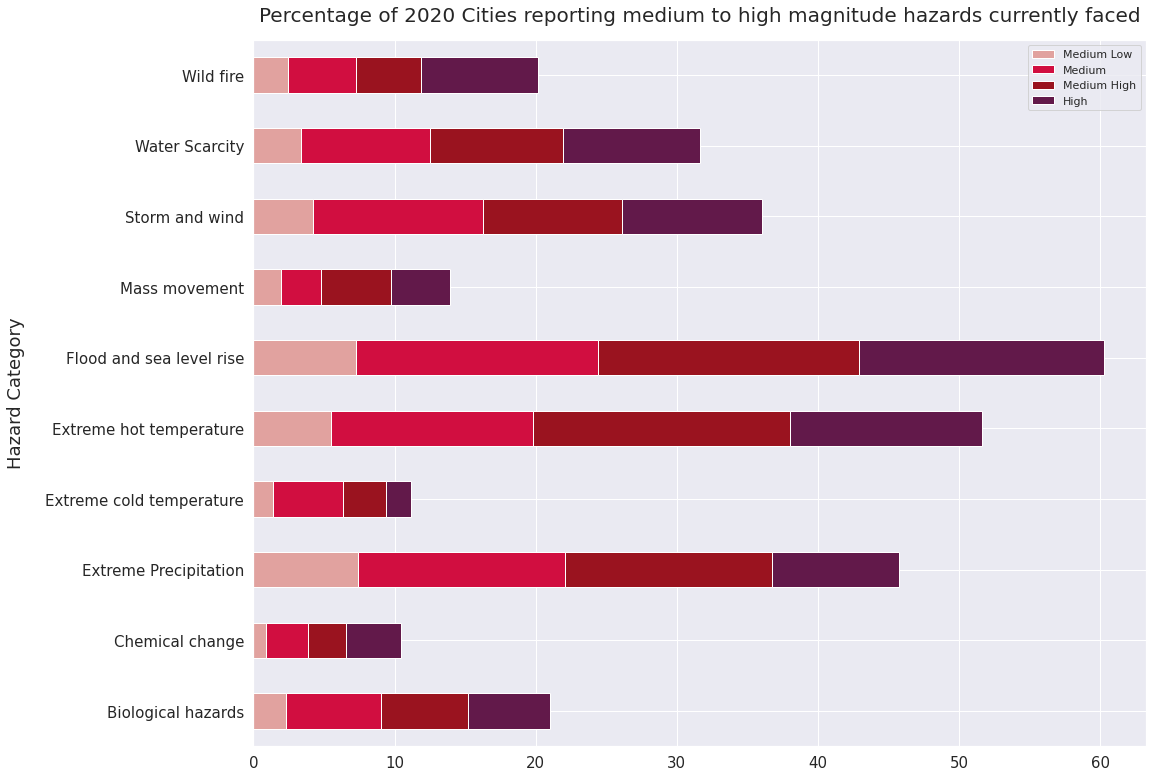

In [10]:
temp = piv2_1[piv2_1['current_mag'].isin([4,5,3,2])].reset_index().groupby(['current_mag', 'Hazard Category'])['City'].nunique()*100/cd2020.shape[0]

temp.unstack(0).plot.barh(color=reversed(grad4), stacked=True, title='Percentage of 2020 Cities reporting medium to high magnitude hazards currently faced') \
.legend(['Medium Low', 'Medium', 'Medium High', 'High']);

---
***Metric 1(a): Climate Exposure***  
_Total level of risk faced by cities due to long and short term impacts of climate change._
<br><br>

$$\begin{align}&Exposure_{city} = \sum_{i=1}^{hazards}((5 \times CurrentMagnitude \times CurrentProbability) + (TimeScale \times FutureMagnitude \times FutureIntensity \times FutureFrequency)), \\ \\
\text{where } & TimeScale \text{ is the expected time frame for changes in frequency and intensity of climate hazards}\end{align}$$
<br><br>

**Rationale**  
The lack of comparability of different climate related risks between different cities creates a gap in comprehending the level of impact on a global level. Through _Climate Exposure,_ we assign a cumulative exposure score to **each climate hazard** faced by a city, thereby allowing comparisons of risk exposure at the intra as well as intercity levels. In the calculation, the multiplication of current risks with 5 assigns a greater weight to the existing risks. This is similar to how the TimeScale is used to weight future risks. In effect, this (sub)metric would itself allow National Governments to **focus resources** towards the specific risks and cities that are most exposed to climate change, **providing opportunities** for collaboration amongst cities facing similar problems. In addition, exposure plays a key role in measuring vulnerability, as we shall see now.

---

With this metric we can now visualize and compare cities on their exposure.

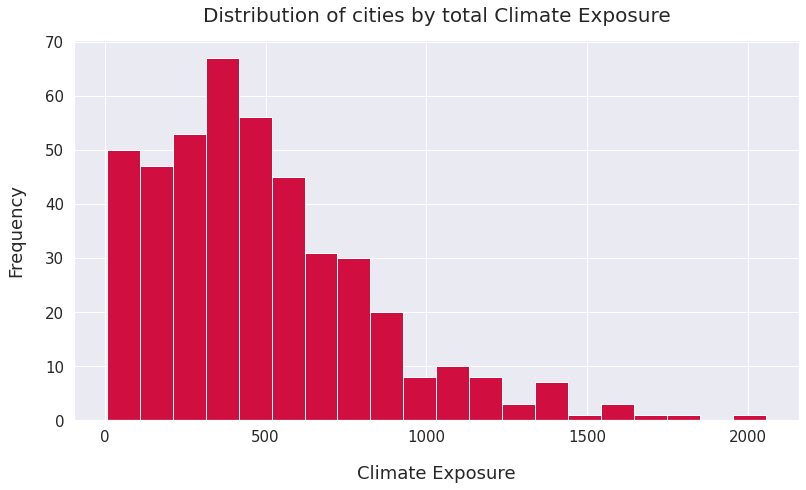

In [11]:
# distribution of cities by climate exposure
city_df['Exposure'].plot.hist(bins=20, figsize=(13, 7), title='Distribution of cities by total Climate Exposure', color=palette[0])
plt.xlabel('Climate Exposure');

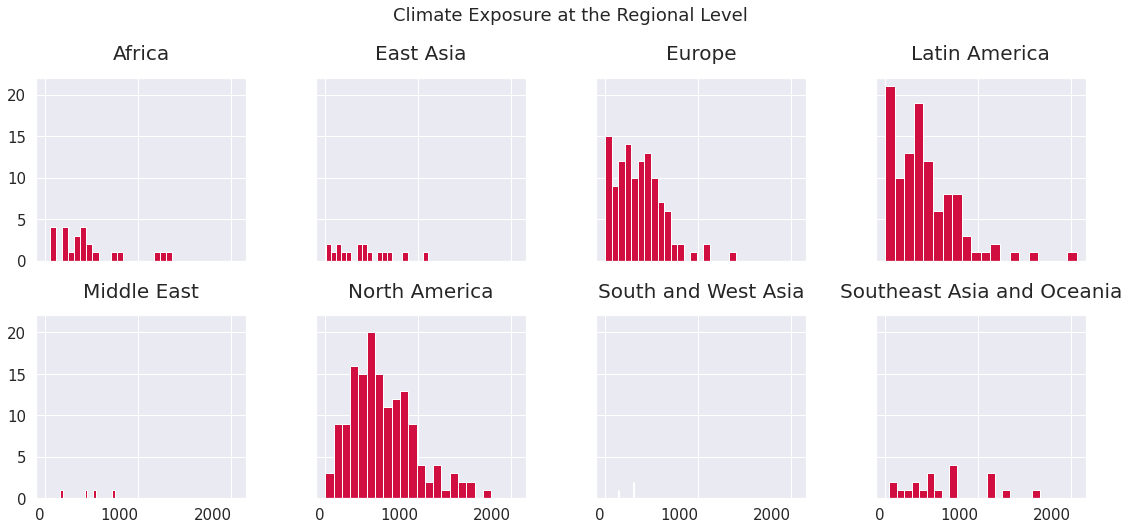

In [12]:
fig, ax = plt.subplots(2,4,sharex=True,sharey=True,figsize=(16, 7))
city_df['Exposure'].hist(by='CDP Region', bins=20, ax=ax, color=palette[0]);
fig.suptitle('Climate Exposure at the Regional Level', size=18, y=1.05)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()

In [13]:
fig = px.scatter_geo(city_df.join(city_locations.set_index('Account Number', append=True)).reset_index(), lat='lat',
            lon='lon', 
#             hover_data=['Account Number'],
            text='City',
#             scope='north america',
            size='Exposure',
            color_continuous_scale=px.colors.sequential.Reds,            
            color='Exposure',
#             size_max=,
            title='Climate Exposure - Cities around the World',
)
fig.update_layout(height=560, margin={"r":0,"t":30,"l":0,"b":0})
fig.update_geos(showcountries=True, countrywidth=0.2, showcoastlines=False)

Since total exposure actually depends on the combined exposure for individual risks and hazards, we can compare the top 20 cities by their risk breakdowns.

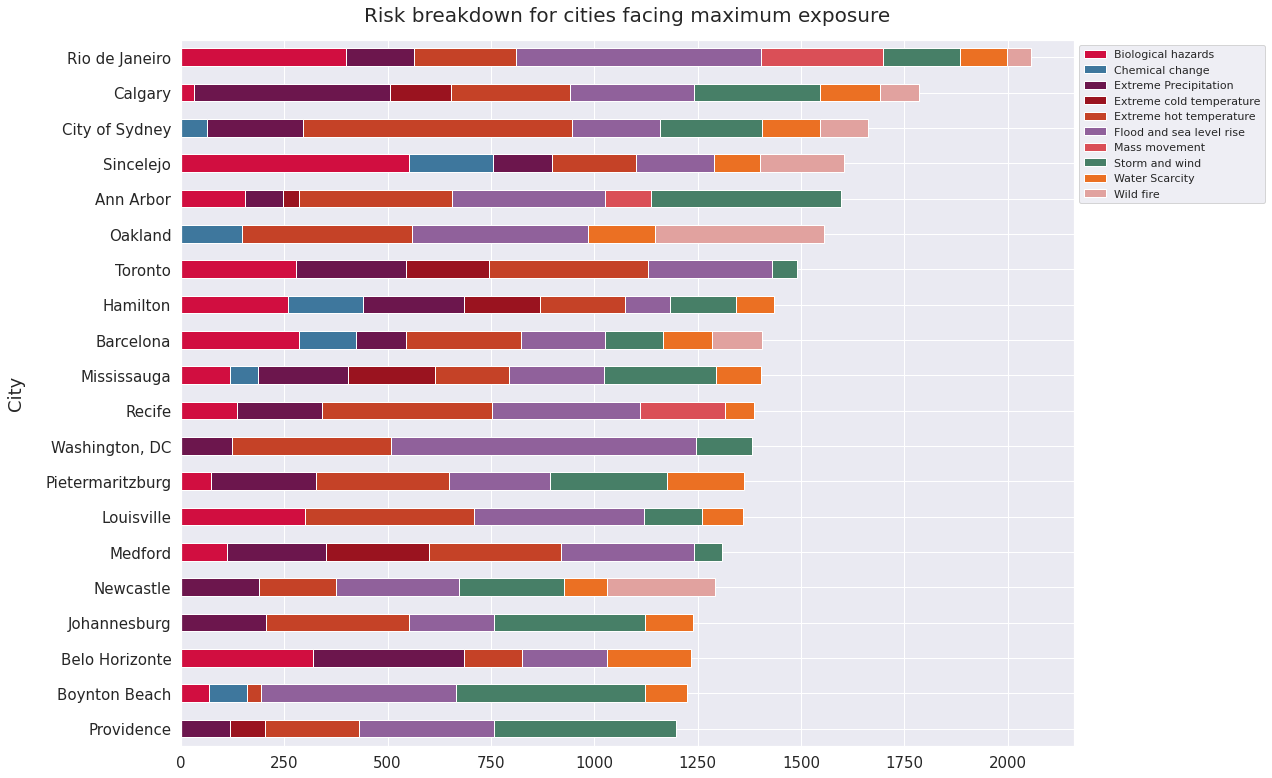

In [14]:
# top 20 cities by exposure
max_exposure = city_df['Exposure'].sort_values(ascending=False)[:20]

# top 20 cities climate hazard specific exposure
# selection = alt.selection_multi(fields=['Climate Hazards'], bind='legend')

# alt.Chart(piv2_1[piv2_1.index.get_level_values(1).isin(max_exposure.index.get_level_values(1))].reset_index()).mark_bar().encode(
#     y=alt.Y('City', sort='-x'),
#     x='sum(exposure)',
#     color=alt.Color('category:N', scale=alt.Scale(scheme='goldred')),
#     opacity=alt.condition(selection, alt.value(1), alt.value(0.4))
# ).configure_axis(labelFontSize=12).properties(height=700, width=700).add_selection(selection)

# text = bars.mark_text(
#     align='left',
#     baseline='middle',
#     dx=3  # Nudges text to right so it doesn't appear on top of the bar
# ).encode(
#     text='exposure'
# )
# (bars + text).properties(height=900)

temp = piv2_1[piv2_1.index.get_level_values(2).isin(max_exposure.index.get_level_values(2))] \
.groupby(['City', 'Hazard Category'])['Exposure'].sum().unstack()
temp['sum'] = temp.sum(axis=1)
temp.sort_values('sum').drop('sum',axis=1).plot.barh(stacked=True, color=qualitative, title='Risk breakdown for cities facing maximum exposure').legend(bbox_to_anchor=(1,1));

The exposure scores for individual hazards allow us to understand their overall impact, allowing us to determine which hazards, on average, pose the most serious risks to cities.

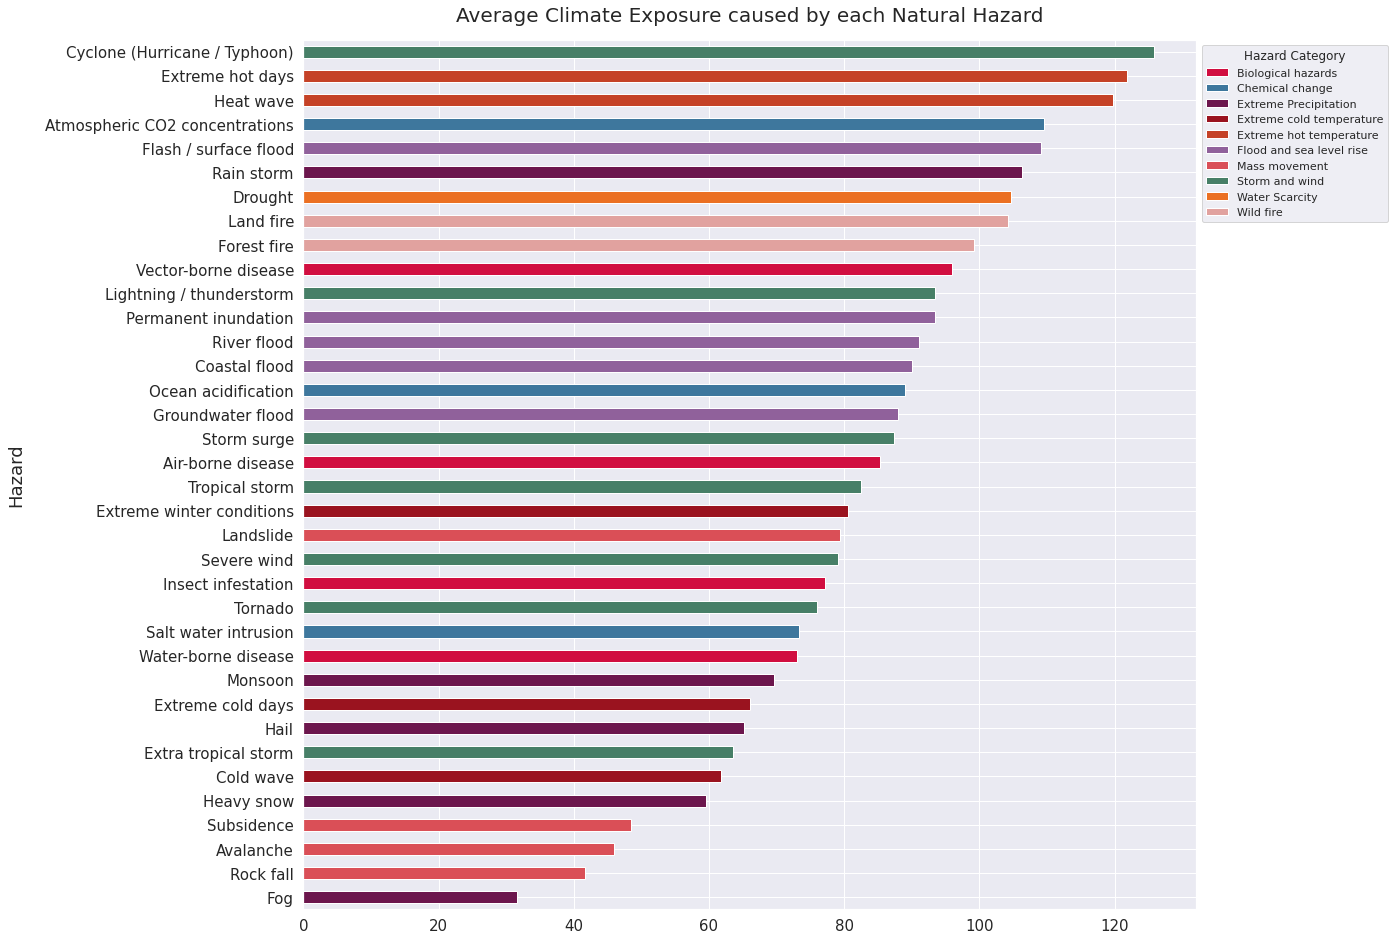

In [15]:
# cumulative exposure by climate hazard
# selection = alt.selection_multi(fields=['category'], bind='legend')

# alt.Chart(piv2_1.dropna(subset=['hazard']).reset_index()).mark_bar().encode(
#     y=alt.Y('hazard', sort='-x'),
#     x='sum(exposure)',
#     color=alt.Color('category:N', scale=alt.Scale(scheme='viridis')),
#     opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
# ).configure_axis(labelFontSize=12).properties(width=500).add_selection(selection)

temp = piv2_1.groupby(['Hazard Category', 'Hazard'])['Exposure'].mean().unstack(0)
temp['sum'] = temp.sum(axis=1)
temp.sort_values('sum').drop('sum', axis=1) \
.plot.barh(stacked=True, color=qualitative, figsize=(16,16),
           title='Average Climate Exposure caused by each Natural Hazard').legend(title='Hazard Category', bbox_to_anchor=(1,1));
# temp.sort_values().plot.barh(figsize=(13, 9), stacked=True, color=grey).legend(bbox_to_anchor=(1,1));

_Climate Exposure_ also enables us to obtain a more comprehensive view of the broader implications of climate change. 

Grouped by the social issues that go hand in hand with climate risks, we see that all areas on average see a medium to high exposure, with Increased conflict and/or crime seeing an average score close to the upper quartile of 137.

In [16]:
print('Central tendency and dispersion for Exposure at the Hazard level:\n')
print(piv2_1['Exposure'].describe().round(2))

Central tendency and dispersion for Exposure at the Hazard level:

count    2233.00
mean       96.62
std        56.25
min         0.00
25%        52.00
50%        93.00
75%       137.00
max       205.00
Name: Exposure, dtype: float64


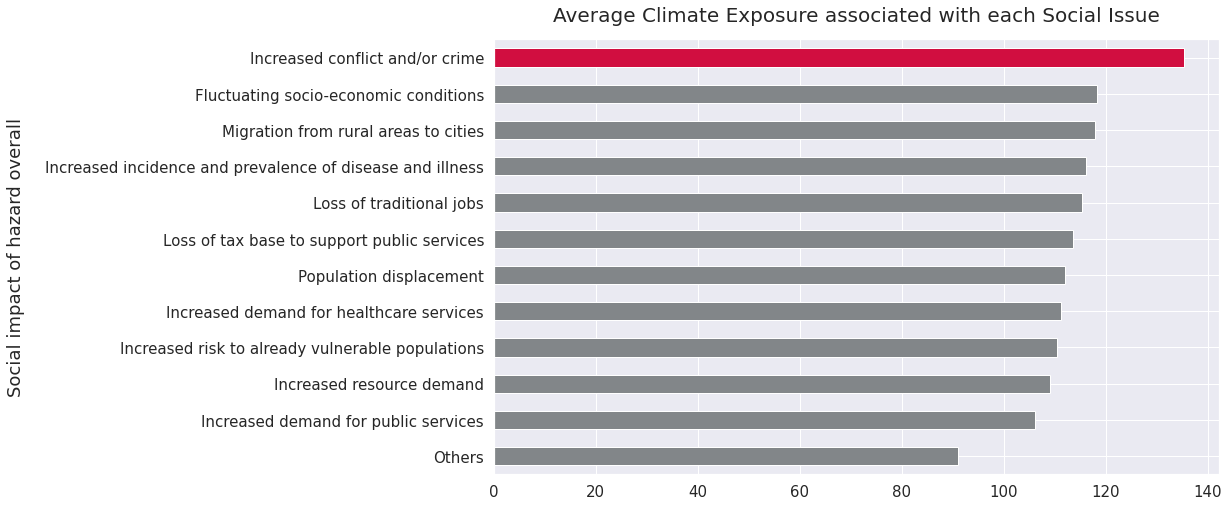

In [17]:
# social issues arising from climate change
social2_1 = piv2_1.explode('Social impact of hazard overall')

# replacing all self stated categories with "Others"
social2_1.loc[social2_1['Social impact of hazard overall'].str.contains('Other, ', na=False), 'Social impact of hazard overall'] = 'Others'

# first sum exposure and count 
social2_1 = social2_1.groupby('Social impact of hazard overall')[['Exposure', 'hazard_count']].sum()

# calcualing average exposure for every given class of social issues
social2_1['avg_social_exposure'] = social2_1['Exposure']/social2_1['hazard_count']
social2_1[['avg_social_exposure', 'hazard_count']].sort_values('avg_social_exposure', ascending=False).round(2)

# plt.subplots(figsize=(14, 8))
# sns.violinplot(x='exposure', y='Social impact of hazard overall',  data=social2_1.reset_index())
social2_1['avg_social_exposure'].sort_values() \
.plot.barh(figsize=(13, 8), color= [grey]*11+ palette[:1],
          title='Average Climate Exposure associated with each Social Issue');

With the next two visualizations, we try to use the exposure score to assess where the impacts of climate change will be localized, highlighting who and what exactly is likely to be the most disadvantaged due to climate risks. We do this by aggregating exposure scores by the vulnerable populations reported by cities along with various assets/services that they report will be disrupted.

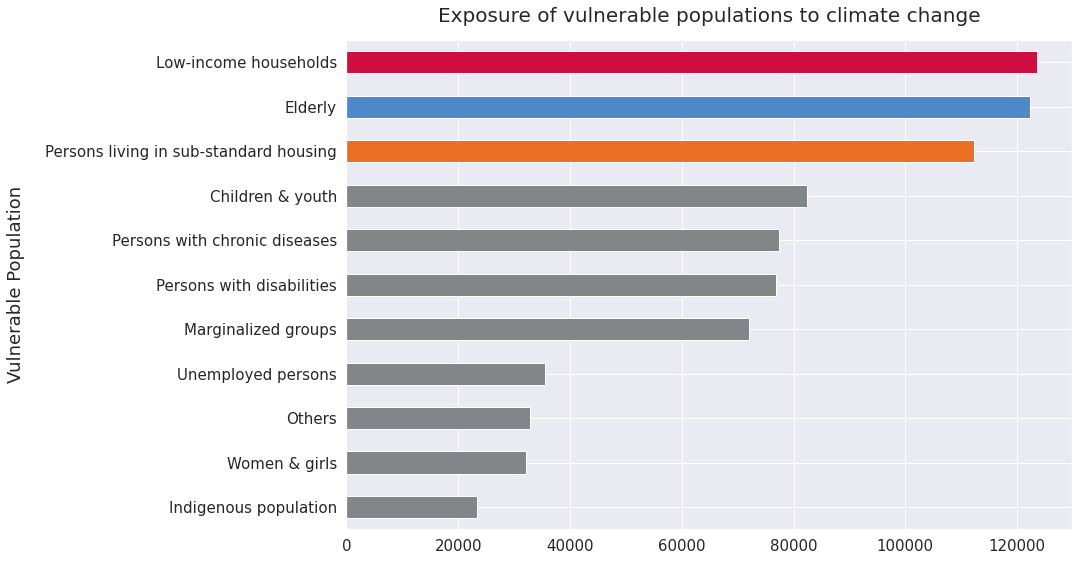

In [18]:
# calculating level of impact on vulnerable populations 
vulner2_1 = piv2_1.explode('Please identify which vulnerable populations are affected')

# replacing all self stated categories with "Others"
vulner2_1.loc[vulner2_1['Please identify which vulnerable populations are affected'].str.contains('Other, ', na=False), 
              'Please identify which vulnerable populations are affected'] = 'Others'

# calculating total exposure by each vulnerable population
vulner2_1.groupby('Please identify which vulnerable populations are affected')['Exposure'].sum().sort_values() \
.plot.barh(figsize=(13,9), color= [grey]*8 + palette_r, xlabel='Vulnerable Population',
           title='Exposure of vulnerable populations to climate change');

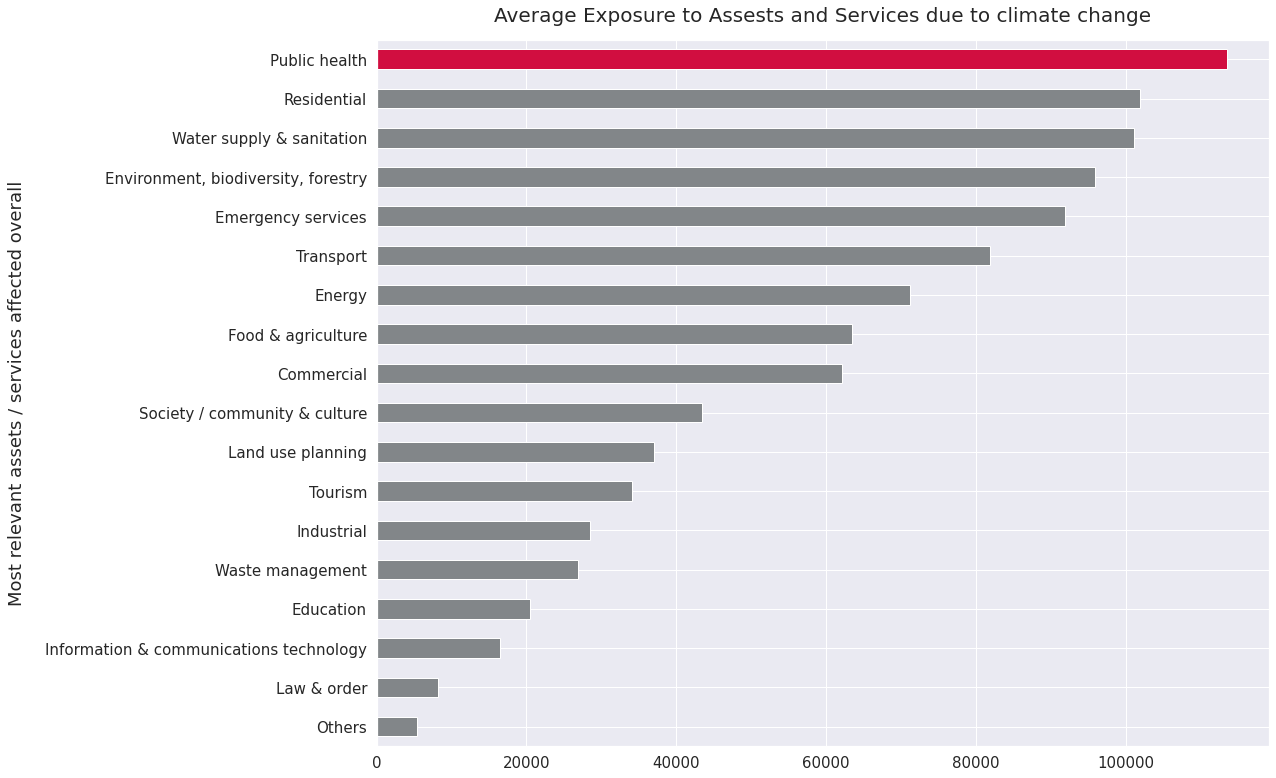

In [19]:
# exposure for assets and services
assets2_1 = piv2_1.explode('Most relevant assets / services affected overall')

# replacing all self stated categories with "Others"
assets2_1.loc[assets2_1['Most relevant assets / services affected overall'].str.contains('Other, ', na=False), 'Most relevant assets / services affected overall'] = 'Others'

assets2_1.groupby('Most relevant assets / services affected overall')['Exposure'].sum().sort_values() \
.plot.barh(color= [grey]*17 + palette[:1], title='Average Exposure to Assests and Services due to climate change');

Unsuprisingly, we see that the poorer sections of society, along with the elderly, are the most at risk and therefore the most disadvantaged due to climate change.

The average exposure to services and assets gives us an idea as to where cities must focus their adaptation and resilience-building efforts. As per the reported data, it is seen that climate change is going to have big impacts on public services such as health and sanitation, and affect people where they live, possibly resulting in mass migrations due to resource scarcity or uninhabitable conditions - both also reasons that might impact the general health of people.

The following heatmap looks at climate exposure through the coorrelated between various social issues and vulnerable populations.  We again see the elderly and the poor are disproportionately affected with a majority of the social impacts. The heatmap also highlights, once again, that increased demand for public services is more likely with unchecked climate change, confirming it is going to be one of the key social issues hurting vulnerable populations.

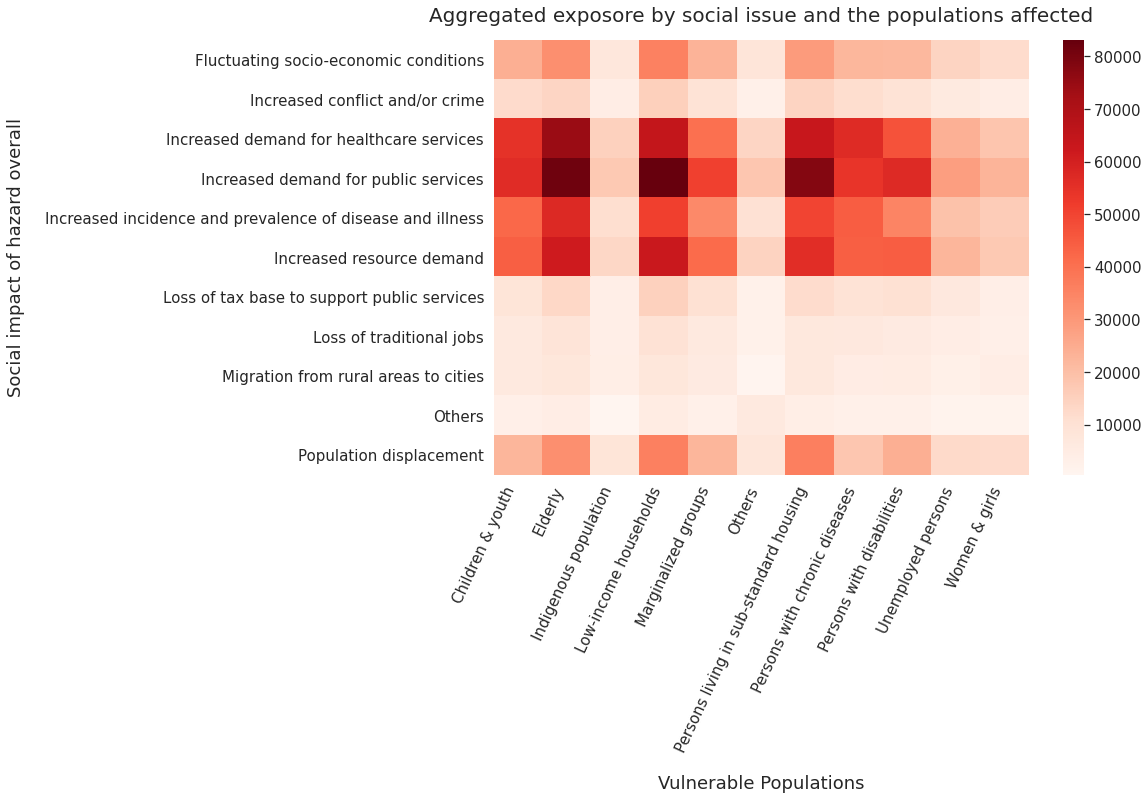

In [20]:
# finding what social impact is likely to affect which populations
compar2_1 = piv2_1.explode('Please identify which vulnerable populations are affected') \
.explode('Social impact of hazard overall')

# having this value makes no sense when comparing with the vulnerable populations themselves - we want to see what those risks are
compar2_1 = compar2_1[compar2_1['Social impact of hazard overall']!='Increased risk to already vulnerable populations']

# replacing all self stated categories with "Others"
compar2_1.loc[compar2_1['Social impact of hazard overall'].str.contains('Other, ', na=False), 
              'Social impact of hazard overall'] = 'Others'
compar2_1.loc[compar2_1['Please identify which vulnerable populations are affected'].str.contains('Other, ', na=False), 
              'Please identify which vulnerable populations are affected'] = 'Others'

plt.subplots(figsize=(12, 8))
sns.heatmap(compar2_1.groupby([
    'Social impact of hazard overall', 
    'Please identify which vulnerable populations are affected'
])['Exposure'].sum().unstack(), cmap='Reds');

plt.xticks(
    rotation=65, 
    horizontalalignment='right',
)
plt.xlabel('Vulnerable Populations')
plt.title('Aggregated exposore by social issue and the populations affected')
plt.show()

We already know which natural hazards affect which populations. So we can perform a join between natural hazard risks and the corresponding health issues they are expected to cause (as reported by cities), and once more use _Climate Exposure_ as a means to measure the seriousness of the expected health impacts due to climate adversity, on subections of vulnerable populations.

The resulting heatmap is all red, which shows that almost every single group can expect to see above-median exposure to health issues due to climate change.

In [21]:
# get reported for health issues from city data
c2_3a = get_cities('2.3a')
piv2_3a = c2_3a[c2_3a['Column Name'].isin([
    'Please identify which vulnerable populations are affected by these climate-related impacts',
    'Identify the climate-related health issues faced by your city',
    'Identify the climate hazards most significantly impacting the selected areas',
    'Area affected by climate change',
    'Timescale of climate-related issues for the selected health area'
])].pivot_table(index=['City', 'Account Number', 'Row Number'], columns='Column Name', 
                aggfunc=lambda x: x.values[0] if len(list(x))==1 else list(x))['Response Answer'] \
.explode('Identify the climate hazards most significantly impacting the selected areas') \
.explode('Timescale of climate-related issues for the selected health area')

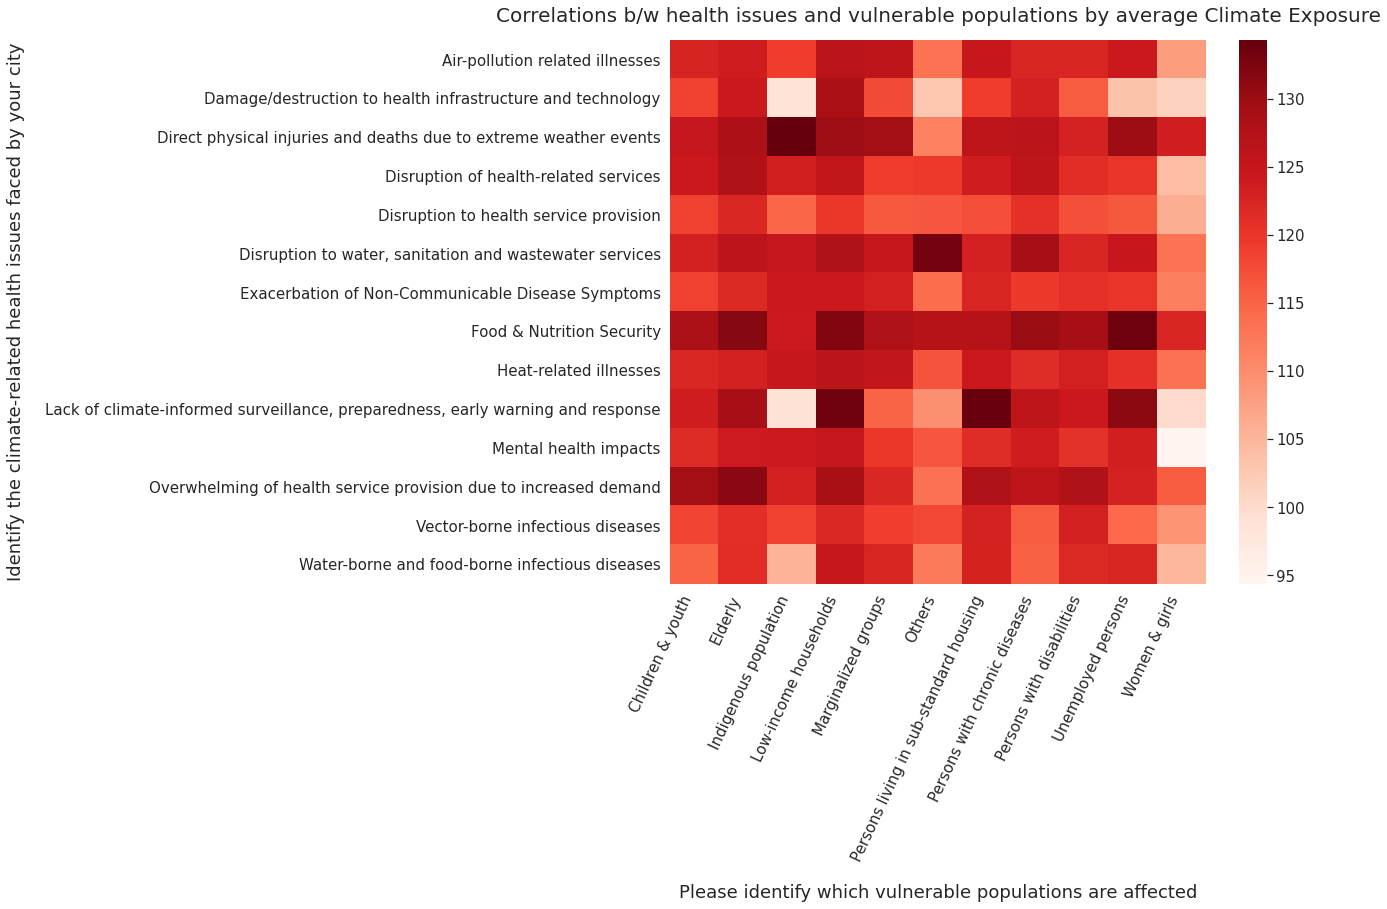

In [22]:
# combining health data with calculated exposure scores for climate hazards
health = piv2_1[['Climate Hazards', 'Please identify which vulnerable populations are affected', 'Exposure']] \
.join(piv2_3a.reset_index().set_index([
    'City', 'Account Number', 'Identify the climate hazards most significantly impacting the selected areas'
]), on=['City', 'Account Number', 'Climate Hazards'], how='inner') \
.explode('Please identify which vulnerable populations are affected') \
.explode('Identify the climate-related health issues faced by your city').dropna(subset=['Identify the climate-related health issues faced by your city'])

# replacing all self stated categories with "Others"
health.loc[health['Please identify which vulnerable populations are affected'].str.contains('Other, ', na=False),
          'Please identify which vulnerable populations are affected'] = 'Others'
# dropping the same for health issues, because it corrupts the visualization
health = health[~health['Identify the climate-related health issues faced by your city'].str.contains('Other, ', na=False)]

# creating shorted names
health['Identify the climate-related health issues faced by your city'] = health['Identify the climate-related health issues faced by your city'] \
.apply(lambda x: re.sub(r' \(.*?\)', '', x))

fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(health.groupby(['Please identify which vulnerable populations are affected',
               'Identify the climate-related health issues faced by your city'])['Exposure'].mean().unstack(0), 
            cmap='Reds');
plt.xticks(
    rotation=65, 
    horizontalalignment='right',
)
plt.title('Correlations b/w health issues and vulnerable populations by average Climate Exposure')
plt.show()

So we have seen how _Climate Exposure_ is a very flexible metric, useful in discussing the various impacts of climate risks. But by itself, it may not give us the complete picture of a city's _Vulnerability_ to climate change. To calculate vulnerability, which is our aim, we need to be able to evaluate the preparedness of a city to meet the expected challenges.

In question `3.0` of the 2020 Cities Questionnaire, cities are asked for responses to the actions being taken to adapt. These actions are visualized in the following heatmap along with the specific climate hazards they help mitigate.

The Word Cloud ,thereafter, sheds light on the focus areas of city efforts by plotting keywords from their action descriptions. Right off, we see a good majority of the mentions happen to be about water-related risks. This is confirmed from the heatmap where we see water-related hazards such as rainstorms and various kinds of flooding are amongst the primary reasons for considering adaptation actions. This makes sense, as cyclones, rainstorms and flooding were ranked number 1 4, and 5 respectively, in terms of their expected _Climate Exposure_. Hazard number 2 and 3, by total exposure, were extreme hot days and heatwaves, both of which too feature strongly on the heatmap, implying the requisite actions being implemented.

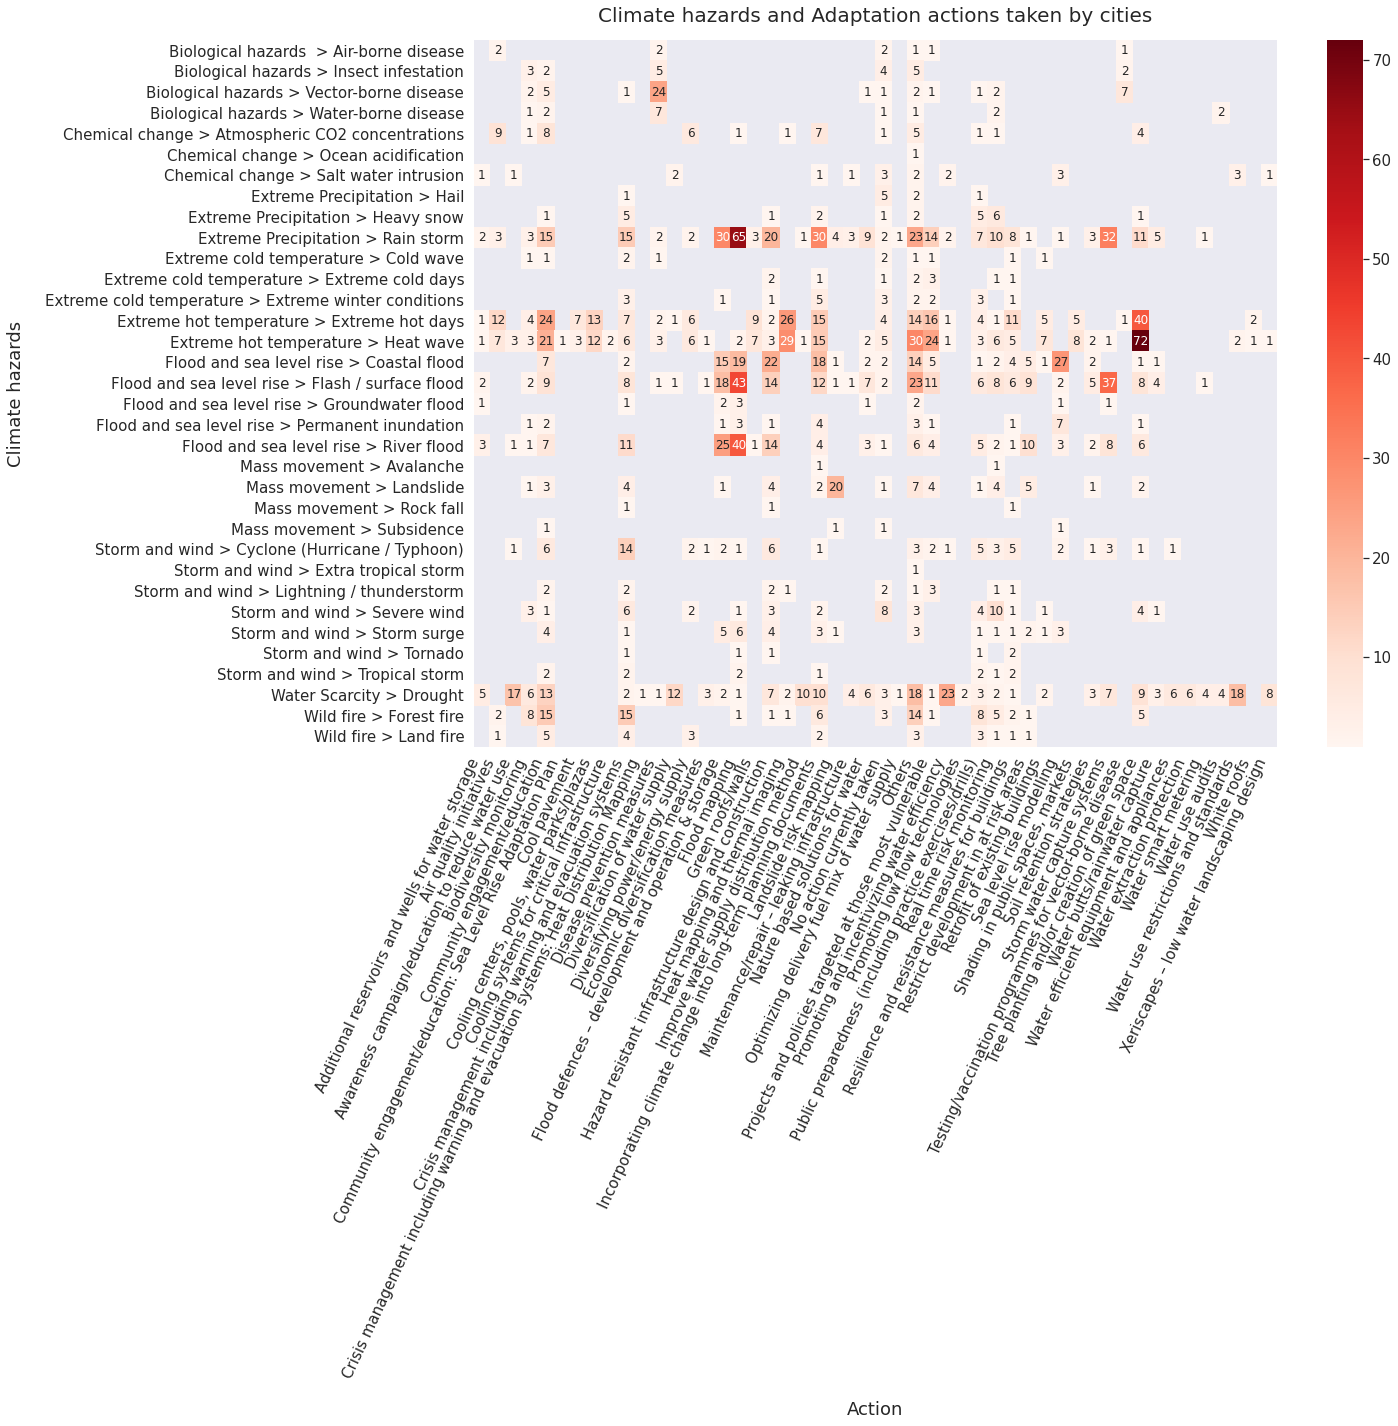

In [23]:
c3 = get_cities('3.0', cols=CITY_GROUP)
piv3 = c3[c3['Column Name'].isin([
    'Sectors/areas adaptation action applies to', 
    'Action',
    'Majority funding source', 
    'Co-benefit area',
    'Total cost provided by the local government (currency)',
    'Means of implementation',
    'Action description and implementation progress',
    'Climate hazards', 'Finance status', 'Status of action',
    'Total cost of the project (currency)',
    'Total cost provided by the majority funding source (currency)'
])].pivot_table(index=CITY_GROUP+['Row Number'], columns='Column Name', 
                # if more than one value specified for a column, we aggregate as list for a given action
                aggfunc=lambda x: x.values[0] if len(list(x))==1 else list(x))['Response Answer']

# replacing all self stated categories with "Others"
piv3.loc[piv3['Action'].str.contains('Other, ', na=False), 'Action'] = 'Others'

fig, ax = plt.subplots(figsize=(18,13))

# create heatmap for visualizing actions opposite the relevant climate hazard
sns.heatmap(piv3.groupby('Climate hazards')['Action'].value_counts().unstack(), cmap="Reds", annot=True)

plt.xticks(
    rotation=65, 
    horizontalalignment='right',
)
plt.title('Climate hazards and Adaptation actions taken by cities')
plt.show()

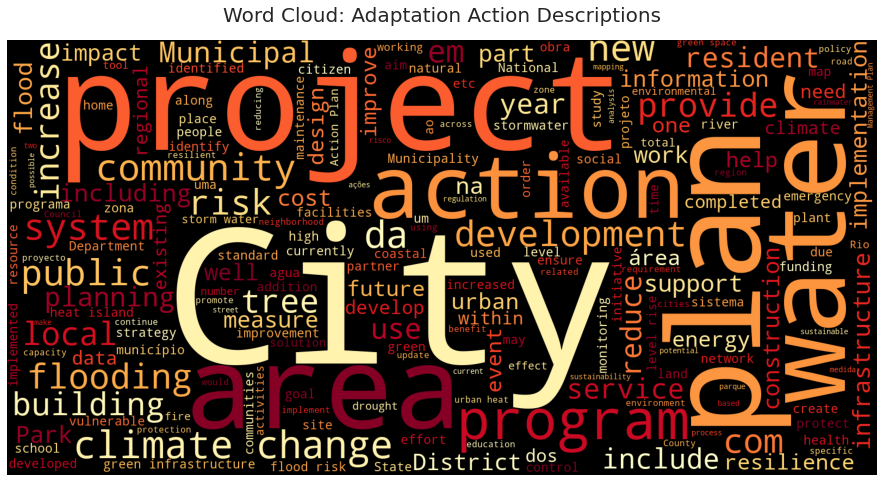

In [24]:
# visulizing descriptions for adaptation actions through a word cloud
answers3 = piv3['Action description and implementation progress'].dropna()
# .apply(lambda x: ' '.join([item for item in x.lower().split() if item not in stop and len(item) > 3]))
# answers3_3.str.split(expand=True).stack().value_counts()[:45]

fig, ax = plt.subplots(figsize=(16,8))       

wordcloud = WordCloud(stopwords=stop+['also'],
                      width=1600, colormap='YlOrRd',             
                      height=800).generate(' '.join(answers3))

ax.set_axis_off()
plt.title('Word Cloud: Adaptation Action Descriptions')
plt.imshow(wordcloud);

So the responses to this question provide an accurate representation of the relevant mitigative actions taken by cities to prepare for climate impact. But how would we use that to calculate _preparedness?_

---
***Metric 1(b): Preparedness***  
_The resiliency of cities, from the sum of adaptative actions being implemented, towards the climate hazards they are exposed to._ 
<br><br>

$\begin{align} & Preparedness_{city} = \sum_{i=1}^{actions}{Progress * FundingStatus * \sqrt{C}}, \\ 
& \text{where } C = \text{No. of Cobenefit Areas} \end{align}$
<br><br>

**Rationale**  
As mentioned above, it is imperative to gain insight into the degree of preparedness with respect to tackling climate change. Adaptation actions being implemented contribute towards a city's resiliency and provide an estimate of the cities' engagement towards mitigating climate risk. In our calculation, we assume that each action contributes as a weighted sum towards total city preparedness based on how far along it is in terms of progress, acquiring funding, and the number of additional co-benefits it might offer. _Preparedness_ too, like _Climate Exposure,_ may be calculated at the hazard level allowing cities to determine whether they are sufficiently equipped to battle the risks from particular climate events.

---

In [25]:
# defining replacement dictionaries for following question on adaptation actions
STATUS = {'Scoping': 1, 'Pre-feasibility study/impact assessment': 2, 'Pre-implementation': 3, 'Implementation': 4,
          'Implementation complete but not in operation': 4.5, 'Operation': 5, 'Monitoring and reporting': 5,
          'Other, please specify: Complete': 5,
          'Other, please specify: This is an ongoing action that is implemented as the city develops': 5,
          'Other, please specify: Top up incentives for upgrades from fossil fuel furnaces to heat pumps underway.': 5,
          'Other, please specify: An initial project was done in the fall of 2019 and a continuation is pending fr fall 2020': 4}

FINANCE = {'Finance secured': 5, 'Feasibility finalized, and finance partially secured': 4, 'Seeking funding': 3, 
           'Feasibility undertaken': 2, 'Pre-feasibility/impact assessment study status': 1}

In [26]:
# counter for tracking number of actions undertaken
piv3['actions_count'] = 1

# replace values for funding and status of action with numerical weights
piv3['funding'] = piv3['Finance status'].replace(FINANCE).fillna(1)
piv3 = piv3[~piv3['Status of action'].str.contains('Other, ', na=False)]
piv3['progress'] = piv3['Status of action'].replace(STATUS).fillna(1)

# counting number of cobenefit areas for specified actions, 0 if none specified
piv3['cobenefit_count'] = piv3['Co-benefit area'].fillna('').apply(lambda x: len(x) if isinstance(x, list) else (1 if x else 0))
piv3['cobenefit_sqrt'] = np.sqrt(piv3['cobenefit_count'])
# calculate preparedness (TODO)
piv3['Preparedness'] = (piv3['progress'] * piv3['funding'] * piv3['cobenefit_sqrt'])

# add to city dataframe
city_df[['Preparedness', 'actions_count']] = piv3.groupby(CITY_GROUP)[['Preparedness', 'actions_count']].sum()

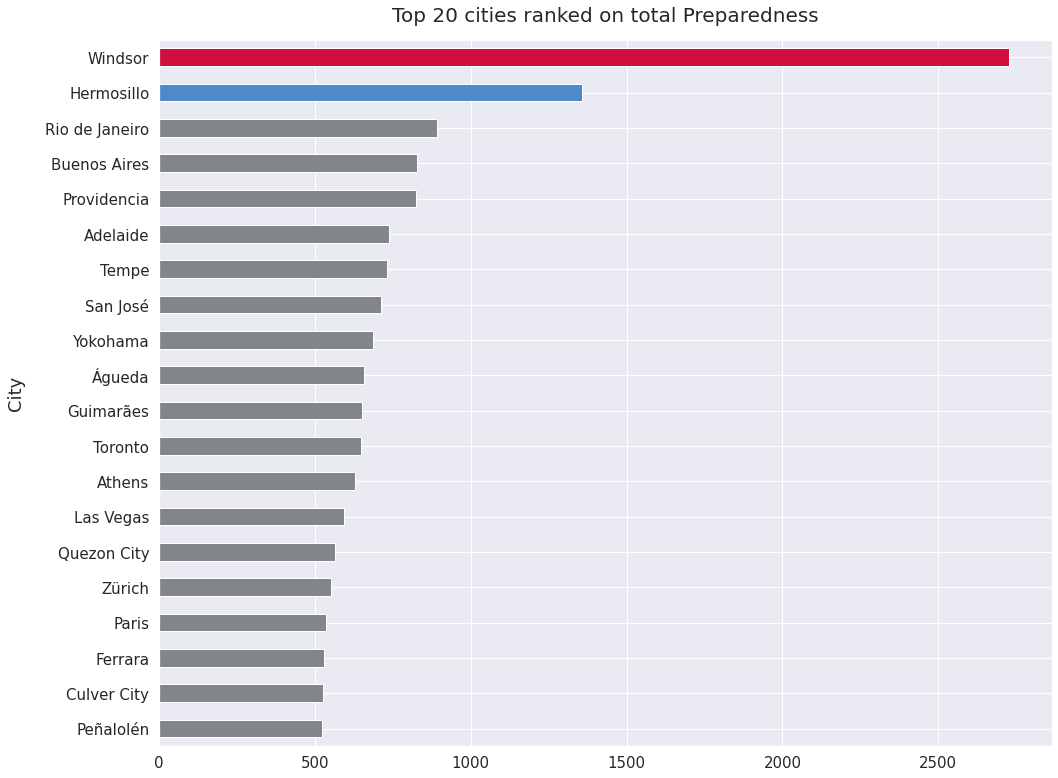

In [27]:
# city_df.sort_values('preparedness', ascending=False)[:30]
city_df.reset_index().sort_values('Preparedness', ascending=False)[:20] \
.plot.barh(x='City', y='Preparedness', color=palette[:2]+[grey]*18,
           title='Top 20 cities ranked on total Preparedness', legend=False);
plt.gca().invert_yaxis()

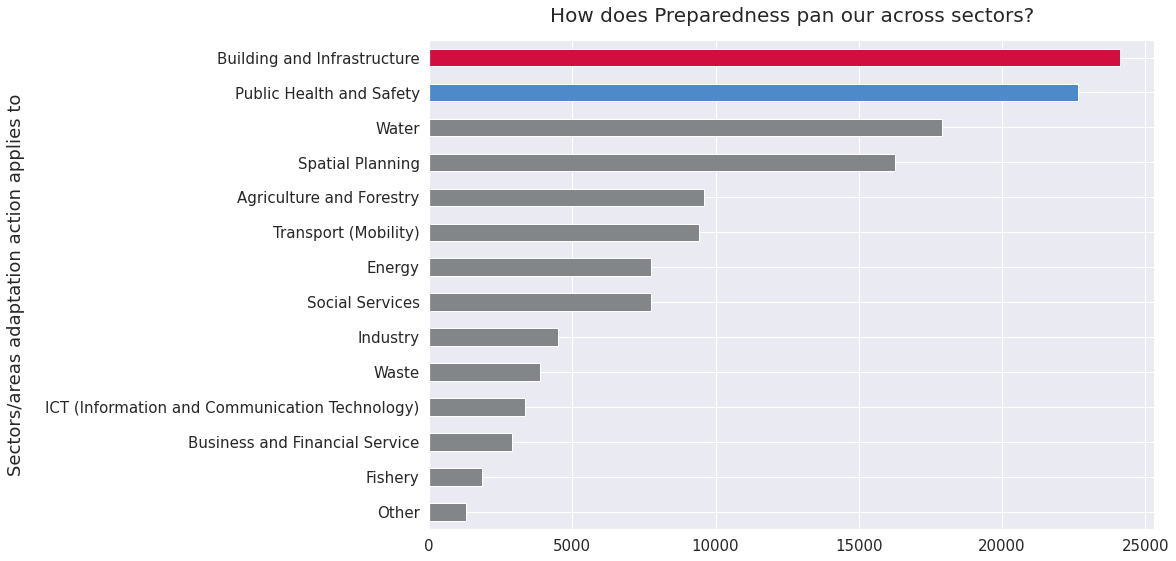

In [28]:
# comparing sector based on the actions taken for preparedness
piv3a = piv3.explode('Sectors/areas adaptation action applies to')
piv3a.loc[piv3a['Sectors/areas adaptation action applies to'].str.contains('Other, ', na=False), 'Sectors/areas adaptation action applies to'] = 'Other'
sector_stack = piv3a.groupby(['City', 'Account Number', 'Sectors/areas adaptation action applies to'])['Preparedness'].sum().unstack()
sector_stack.sum().sort_values().plot.barh(figsize=(13,9), title='How does Preparedness pan our across sectors?', color=[grey]*12 + palette_r[1:]);

We can now finally get around to calculating _Vulnerability._ In case of this case, again, the calculation is first done at the hazard level, and then aggregated at the city level. The minimum vulnerability to a hazard can only be 0 even if the level of preparedness is much higher than the exposure to that particular hazard.

We now visualize city _Vulnerability_ in the next two charts, first as the absolute value, and thereafter as it compares to _Climate Exposure._ In the second plot, the distance from the red diagonal represents the total **"functional" preparedness**, that is, the amount of preparedness that actually contributes to the vulnerability calculation.

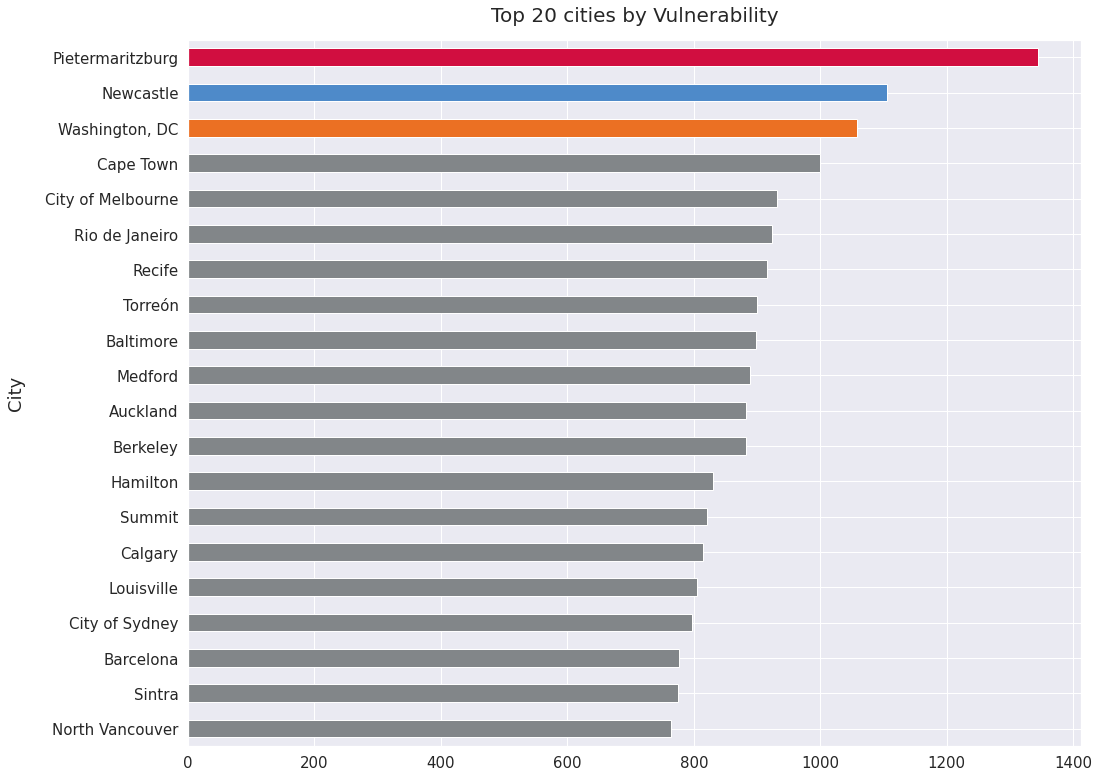

In [29]:
# preparedness vs exposure for each climate hazard faced by a city
hazard_stack = piv3.groupby(CITY_GROUP + ['Climate hazards'])[['Preparedness']].sum().join(piv2_1.groupby(CITY_GROUP+['Climate Hazards'])['Exposure'].sum(),
                  on=CITY_GROUP+['Climate hazards'], how='right')

# lowest vulnerability for a hazard can be 0, so replaceing negatives
hazard_stack['vulnerability_haz'] = (hazard_stack['Exposure'] - hazard_stack['Preparedness']).apply(lambda x: 0 if x<0 else x)

city_df['Vulnerability'] = hazard_stack.reset_index().groupby(CITY_GROUP)['vulnerability_haz'].sum()
city_df.sort_values('Vulnerability', ascending=False, inplace=True)

city_df[:20].reset_index().plot.barh(x='City', y='Vulnerability', color=palette + [grey]*17,
                                     title='Top 20 cities by Vulnerability', legend=False);
plt.gca().invert_yaxis()

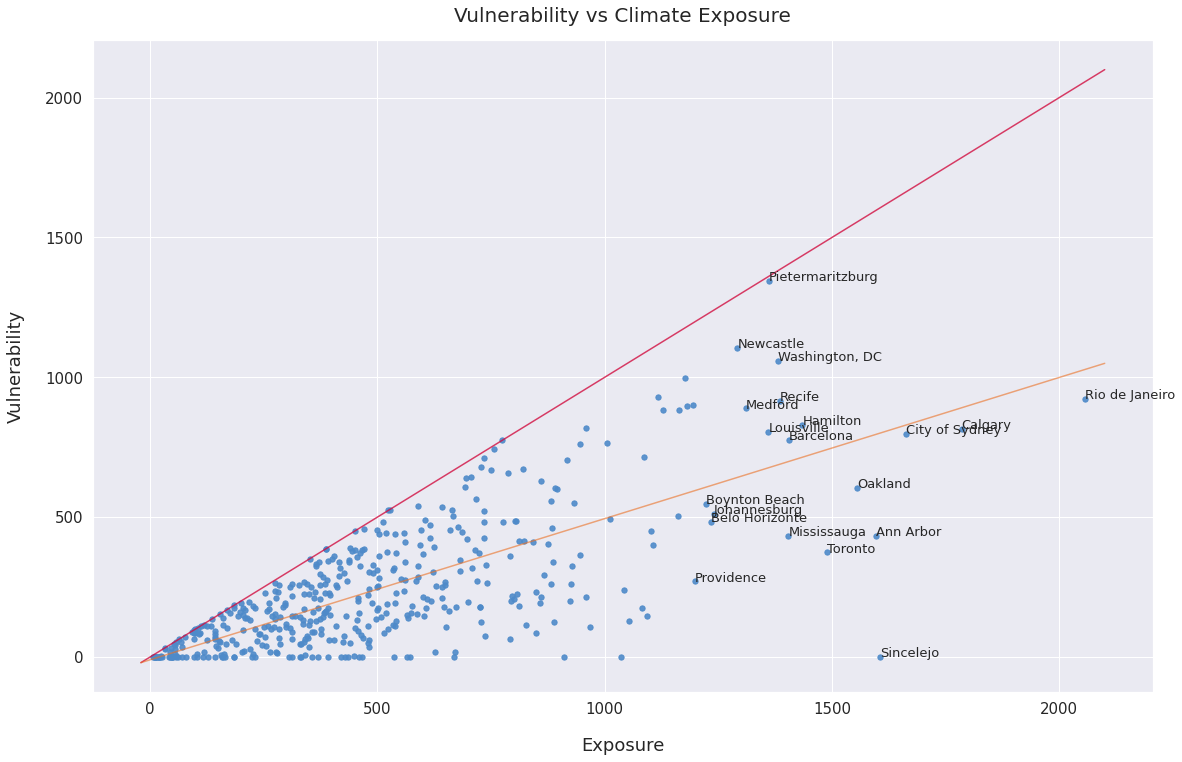

In [30]:
city_df.sort_values('Exposure', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(19, 12),)
ax.plot([-20,2100], [-20, 2100], '-',  c=palette[0], alpha=0.8)
ax.plot([-20,2100], [-20, 1050], '-',  c=palette[2], alpha=0.6)
city_df.plot.scatter(x='Exposure', y='Vulnerability', color=palette[1],
                     ax=ax, alpha=0.9, s=28, title='Vulnerability vs Climate Exposure')

for k, v in city_df[['Exposure', 'Vulnerability']][:20].iterrows():
    ax.annotate(k[2], v, fontsize=13)

Looking at this comparison, we can tell that several highly exposed cities are doing well in terms of reducing their risk. The orange line represents a 50% or more reduction in total vulnerability through relevant actions being taken. Rio de Janeiro, although the most exposed, seems to be making a very commendable effort towards improving risk to its people. Other notable mentions are Sincelejo, Ann Arbour, Toronto, Providence, and even Johannesburg, considering the high levels of crime and disorder in the city.


**NOTE:** We are aware that our metric on vulnerability bears some resemblance with the [ND-GAIN score](https://gain.nd.edu/assets/254377/nd_gain_technical_document_2015.pdf), however, when we began working on this metric, we had not yet come across the approach taken by ND GAIN and therefore the similarities are purely coincidental. Moreover, finding work in line with what we had set out to do just proved to us that we were on the right track!


<h3 id="adaptation">6.1.2 Adaptation</h3>

Our next set of metrics looks at adaptation. In particular, how much motive exists for cities to adapt and in doing so what are the challenges they are likely to face.

---
<strong id="#metric2"><em>Metric 2: Adaptation Incentive</em></strong>  
_Motive for cities to adapt to climate change._
<br><br>

$\begin{align} & Adaptation Incentive_{city} = \sum_{i=1}^{climate Hazards}(Vulnerability_{i} + OpportunityPayoff_{i}), \\ \\
  \text{where } \\
 & OpportunityPayoff_{i} = \sum_{j=1}^{action Type_{i}}(No Of Opportunites_{j} \times {No Of Actions}_{j} \times \sqrt{\sum_{k=1}^{actions_{j}} C_{k}}) \\ \\
 & (C = \text{No. of Cobenefit Areas})\end{align}$

**Rationale**  
With cities responsible for [75% of global CO2 emissions](https://bit.ly/3l9uM6Y), they are also the most prone to climate change, yet [no country is doing enough](https://cnn.it/37dRFBg) to keep the earth’s temperature from rising. While high levels of vulnerability require adaptation to be a necessity. However, the opportunities associated with adaption actions, such as clean energy initiatives, new revenue streams, efficient technologies, implementation of carbon taxes provide an even greater incentive for cities to adapt to the risks posed by climate change. 

As such, _Adaptation Incentive,_ calculated as a sum of the vulnerability from each climate hazard, and the expected payoff from implementing adaptation actions that enable cities to realize identified opportunities, assigns a score to the combined incentive - from risks and opportunites - for cities to adapt. Cities with a greater number of opportunities that are directly tied to their adaptation efforts are more likely to score better on opportunity payoff. In addition to the ability to realize opportunities, the opportunity payoff also considers the number of additional cobenefits they are expected to provide.

---

To analyse the responses to Question `6` of the 2020 Questionnaire, we do topic modelling using [LDA (Latent Dirichlet Allocation)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). This classifies the responses into a set of "topics", each identified by a group of keywords that are closely related to the content of the corresponding topic. The topics assigned by LDA can be visualized alongside the Opportunity Category from the questionnaire. This helps us find correlations between them, which, if they exist, validate our classifications.

In [31]:
topics = {}
def get_topic_keywords(model, count_vectorizer, n_top_words):
    '''Adds top keywords for every topic in topics dictionary'''
    
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx+1] = []
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            word = words[i]
            if word != 'city':
                topics[topic_idx+1].append(word)

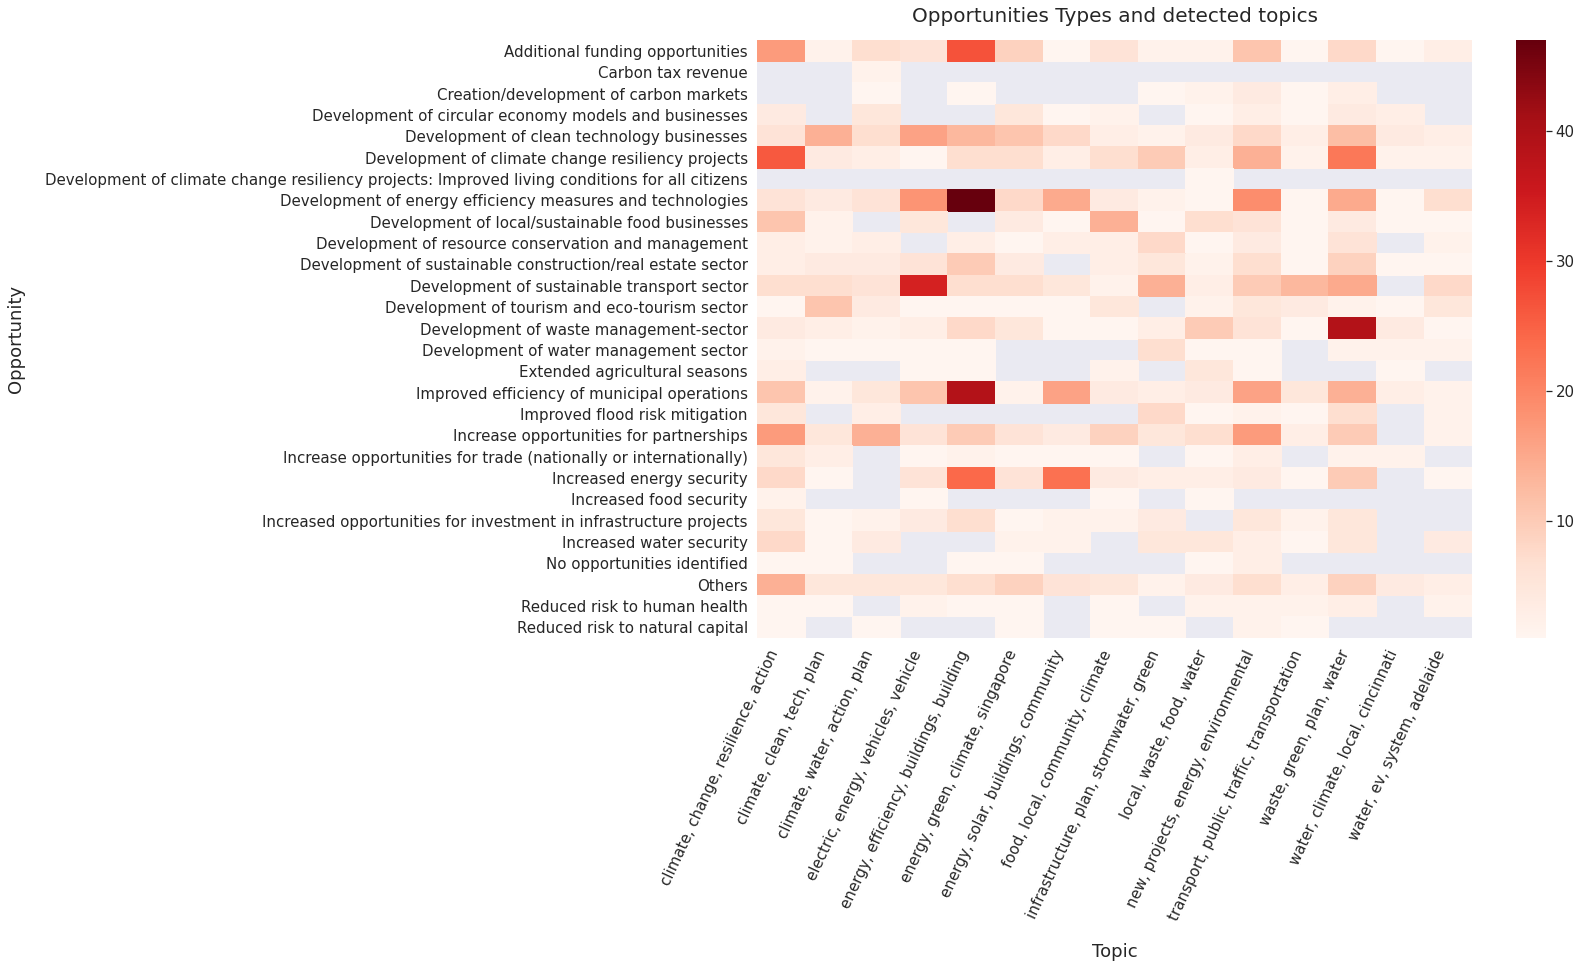

In [32]:
c6 = get_cities('6.0', cols=['Country', 'City', 'Account Number']) \
.pivot(index=['Country', 'City', 'Account Number', 'Row Number'], columns=['Column Name'])['Response Answer']

# cities from the following countries have reported in Spanish
piv6 = c6.drop(['Brazil', 'Mexico', 'Portugal', 'Costa Rica', 'Colombia', 'Peru', 'Chile', 'Argentina'])
# removing French responses from Dijon, Nice
piv6 = piv6.drop(('France', 'Dijon')).drop(('France', 'Nice'))

# clean descriptions
desc = piv6['Describe how the city is maximizing this opportunity'].fillna('').map(lambda x: re.sub('[,\.!?]', '', x.lower()))

# initialise the count vectorizer with english/spanish/french (just in case) stop words
count_vectorizer = CountVectorizer(stop_words=stop)
# fit and transform the processed titles
count_data = count_vectorizer.fit_transform(desc)
words = count_vectorizer.get_feature_names()

# tweak the two parameters for LDA
number_topics = 15
number_words = 5
# create and fit the LDA model
lda = LDA(number_topics, n_jobs=-1, random_state=42)
# get index corresponding max topic value for every description
piv6['topic_id'] = lda.fit_transform(count_data).argmax(axis=1) + 1

# add topic keywords to topics dict
get_topic_keywords(lda, count_vectorizer, number_words)

piv6['Topic'] = piv6['topic_id'].apply(lambda x: ', '.join(topics[x][:4]))

# replacing all self stated categories with "Others"
piv6.loc[piv6['Opportunity'].str.contains('Other, ', na=False), 'Opportunity'] = 'Others'
# piv6['count'] = piv6['Describe how the city is maximizing this opportunity'].fillna('').apply(lambda x: [i for i in grid if i in x])

plt.subplots(figsize=(16, 11))
# sns.heatmap(piv6.explode('count').groupby('count')['Opportunity'].value_counts().unstack().T, annot=True);
sns.heatmap(piv6.groupby('Topic')['Opportunity'].value_counts().unstack().T, cmap='Reds');

plt.xticks(
    rotation=65, 
    horizontalalignment='right',
)
plt.title('Opportunities Types and detected topics')
plt.show()

The heatmap confirms the existence of correlations. Looking at the topic keywords we find that not only are they closely matching the opportunity categories, which was to be expected, but they also hint at the underlying actions that go hand in hand with these opportunities. For example they bring out **"new, projects"**, **"resilience, action"**, **"action, plan"**, **"solar, community"**, **"infrastructure, plan"**. 

To calculate _Opportunity Payoff,_ we can use the knowledge we just gained, of implicit action being present within each opportunity, to discover which adaptation actions help with which opportunities. For that, we create a mapping between adaptation actions from Question `3` of the questionnaire and the opportunities listed in question `6`.

In [33]:
# mapping b/w adaptation actions taken and opporunities identified by cities
# 'Additional funding opportunities' and Increase opportunities for partnerships' not included in
# opportunities as almost every action is compatible with realizing these

climate_action_opportunity = pd.DataFrame([
    ('Flood mapping', 'Improved flood risk mitigation'),
    ('Flood mapping', 'Development of climate change resiliency projects'),
    ('Heat mapping and thermal imaging', 'Development of climate change resiliency projects'),
    ('Heat mapping and thermal imaging', 'Reduced risk to human health'),
    ('Landslide risk mapping', 'Development of climate change resiliency projects'),
    ('Sea level rise modelling', 'Improved flood risk mitigation'),
    ('Sea level rise modelling', 'Development of climate change resiliency projects'),
    ('Biodiversity monitoring', 'Development of climate change resiliency projects'),
    ('Biodiversity monitoring', 'Reduced risk to natural capital'),
    ('Biodiversity monitoring', 'Development of resource conservation and management'),
    ('Real time risk monitoring', 'Development of climate change resiliency projects'),
    ('Crisis management including warning and evacuation systems', 'Development of climate change resiliency projects'),
    ('Crisis management including warning and evacuation systems', 'Reduced risk to human health'),
    ('Public preparedness (including practice exercises/drills)', 'Development of climate change resiliency projects'),
    ('Public preparedness (including practice exercises/drills)', 'Reduced risk to human health'),
    ('Community engagement/education', 'Reduced risk to human health'),
    ('Projects and policies targeted at those most vulnerable', 'Improved flood risk mitigation'),
    ('Projects and policies targeted at those most vulnerable', 'Development of climate change resiliency projects'),
    ('Projects and policies targeted at those most vulnerable', 'Reduced risk to human health'),
    ('Projects and policies targeted at those most vulnerable', 'Increased opportunities for investment in infrastructure projects'),
    ('Testing/vaccination programmes for vector-borne disease', 'Reduced risk to human health'),
    ('Disease prevention measures', 'Reduced risk to human health'),
    ('Air quality initiatives', 'Development of climate change resiliency projects'),
    ('Air quality initiatives', 'Reduced risk to human health'),
    ('Incorporating climate change into long-term planning documents', 'Development of climate change resiliency projects'),
    ('Incorporating climate change into long-term planning documents', 'Development of sustainable construction/real estate sector'),
    ('Incorporating climate change into long-term planning documents', 'Development of sustainable transport sector'),
    ('Restrict development in at risk areas', 'Improved efficiency of municipal operations'),
    ('Resilience and resistance measures for buildings', 'Development of climate change resiliency projects'),
    ('Resilience and resistance measures for buildings', 'Reduced risk to human health'),
    ('Resilience and resistance measures for buildings', 'Increased opportunities for investment in infrastructure projects'),
    ('Resilience and resistance measures for buildings', 'Development of sustainable construction/real estate sector'),
    ('Hazard resistant infrastructure design and construction', 'Development of climate change resiliency projects'),
    ('Hazard resistant infrastructure design and construction', 'Reduced risk to human health'),
    ('Hazard resistant infrastructure design and construction', 'Increased opportunities for investment in infrastructure projects'),
    ('Hazard resistant infrastructure design and construction', 'Development of sustainable construction/real estate sector'),
    ('Diversifying power/energy supply', 'Development of clean energy technologies/businesses'),
    ('Diversifying power/energy supply', 'Increased energy security'),
    ('Diversifying power/energy supply', 'Development of energy efficiency measures and technologies'),
    ('Economic diversification measures', 'Creation/development of carbon markets'),
    ('Economic diversification measures', 'Carbon tax revenue'),
    ('Flood defences – development and operation & storage', 'Improved flood risk mitigation'),
    ('Flood defences – development and operation & storage', 'Development of climate change resiliency projects'),
    ('Flood defences – development and operation & storage', 'Reduced risk to human health'),
    ('Flood defences – development and operation & storage', 'Increased opportunities for investment in infrastructure projects'),
    ('Storm water capture systems', 'Improved flood risk mitigation'),
    ('Storm water capture systems', 'Increased water security'),
    ('Storm water capture systems', 'Development of climate change resiliency projects'),
    ('Storm water capture systems', 'Increased opportunities for investment in infrastructure projects'),
    ('Storm water capture systems', 'Development of water management sector'),
    ('Additional reservoirs and wells for water storage', 'Improved flood risk mitigation'),
    ('Additional reservoirs and wells for water storage', 'Increased water security'),
    ('Additional reservoirs and wells for water storage', 'Development of climate change resiliency projects'),
    ('Additional reservoirs and wells for water storage', 'Increased opportunities for investment in infrastructure projects'),
    ('Additional reservoirs and wells for water storage', 'Development of water management sector'),
    ('Soil retention strategies', 'Improved flood risk mitigation'),
    ('Soil retention strategies', 'Development of climate change resiliency projects'),
    ('Soil retention strategies', 'Reduced risk to natural capital'),
    ('Tree planting and/or creation of green space', 'Improved flood risk mitigation'),
    ('Tree planting and/or creation of green space', 'Development of climate change resiliency projects'),
    ('Tree planting and/or creation of green space', 'Reduced risk to natural capital'),
    ('Tree planting and/or creation of green space', 'Improved efficiency of municipal operations'),
    ('Green roofs/walls', 'Development of climate change resiliency projects'),
    ('Green roofs/walls', 'Improved efficiency of municipal operations'),
    ('Green roofs/walls', 'Increased opportunities for investment in infrastructure projects'),
    ('Green roofs/walls', 'Development of sustainable construction/real estate sector'),
    ('White roofs', 'Improved efficiency of municipal operations'),
    ('White roofs', 'Increased opportunities for investment in infrastructure projects'),
    ('Shading in public spaces, markets', 'Reduced risk to human health'),
    ('Shading in public spaces, markets', 'Improved efficiency of municipal operations'),
    ('Shading in public spaces, markets', 'Increased opportunities for investment in infrastructure projects'),
    ('Cooling systems for critical infrastructure', 'Reduced risk to human health'),
    ('Cooling systems for critical infrastructure', 'Increased opportunities for investment in infrastructure projects'),
    ('Retrofit of existing buildings', 'Development of climate change resiliency projects'),
    ('Retrofit of existing buildings', 'Increased opportunities for investment in infrastructure projects'),
    ('Cooling centers, pools, water parks/plazas', 'Reduced risk to human health'),
    ('Cooling centers, pools, water parks/plazas', 'Improved efficiency of municipal operations'),
    ('Cooling centers, pools, water parks/plazas', 'Increased opportunities for investment in infrastructure projects'),
    ('Cool pavement', 'Reduced risk to human health'),
    ('Cool pavement', 'Improved efficiency of municipal operations'),
    ('Cool pavement', 'Increased opportunities for investment in infrastructure projects'),
    ('Water extraction protection', 'Increased water security'),
    ('Water extraction protection', 'Development of resource conservation and management'),
    ('Water extraction protection', 'Development of water management sector'),
    ('Promoting low flow technologies', 'Increased water security'),
    ('Promoting low flow technologies', 'Development of water management sector'),
    ('Water butts/rainwater capture', 'Increased water security'),
    ('Water butts/rainwater capture', 'Improved flood risk mitigation'),
    ('Water butts/rainwater capture', 'Development of climate change resiliency projects'),
    ('Water butts/rainwater capture', 'Development of water management sector'),
    ('Xeriscapes – low water landscaping design', 'Increased water security'),
    ('Xeriscapes – low water landscaping design', 'Development of resource conservation and management'),
    ('Xeriscapes – low water landscaping design', 'Development of sustainable construction/real estate sector'),
    ('Xeriscapes – low water landscaping design', 'Development of water management sector'),
    ('Maintenance/repair – leaking infrastructure', 'Increased water security'),
    ('Maintenance/repair – leaking infrastructure', 'Improved efficiency of municipal operations'),
    ('Maintenance/repair – leaking infrastructure', 'Increased opportunities for investment in infrastructure projects'),
    ('Maintenance/repair – leaking infrastructure', 'Development of water management sector'),
    ('Optimizing delivery fuel mix of water supply', 'Increased water security'),
    ('Optimizing delivery fuel mix of water supply', 'Increased opportunities for investment in infrastructure projects'),
    ('Optimizing delivery fuel mix of water supply', 'Development of water management sector'),
    ('Improve water supply distribution method', 'Increased water security'),
    ('Improve water supply distribution method', 'Improved efficiency of municipal operations'),
    ('Improve water supply distribution method', 'Increased opportunities for investment in infrastructure projects'),
    ('Improve water supply distribution method', 'Development of water management sector'),
    ('Promoting and incentivizing water efficiency', 'Increased water security'),
    ('Promoting and incentivizing water efficiency', 'Improved efficiency of municipal operations'),
    ('Water use restrictions and standards', 'Increased water security'),
    ('Water use restrictions and standards', 'Development of resource conservation and management'),
    ('Water efficient equipment and appliances', 'Increased water security'),
    ('Water efficient equipment and appliances', 'Increased opportunities for investment in infrastructure projects'),
    ('Water efficient equipment and appliances', 'Development of water management sector'),
    ('Water smart metering', 'Increased water security'),
    ('Water smart metering', 'Improved efficiency of municipal operations'),
    ('Water smart metering', 'Development of water management sector'),
    ('Water use audits', 'Increased water security'),
    ('Water use audits', 'Improved efficiency of municipal operations'),
    ('Water use audits', 'Development of water management sector'),
    ('Awareness campaign/education to reduce water use', 'Increased water security'),
    ('Awareness campaign/education to reduce water use', 'Improved efficiency of municipal operations'),
    ('Diversification of water supply', 'Increased water security'),
    ('Diversification of water supply', 'Development of climate change resiliency projects'),
    ('Diversification of water supply', 'Development of water management sector'),
    ('Increasing use of desalination', 'Increased water security'),
    ('Increasing use of desalination', 'Development of climate change resiliency projects'),
    ('Increasing use of desalination', 'Development of water management sector'),
    ('Nature based solutions for water', 'Increased water security'),
    ('Nature based solutions for water', 'Development of climate change resiliency projects'),
    ('Nature based solutions for water', 'Development of water management sector'),
], columns=['Action', 'Opportunities'])

climate_action_opportunity[:15].style.set_caption('Sample of the Action-Opportunity Mapping')

With the mapping, we can now assess the contribution of the totality of adaptation actions towards realizing opportunities. This can be visualized as a simple count of the sum of opportunities for city actions.

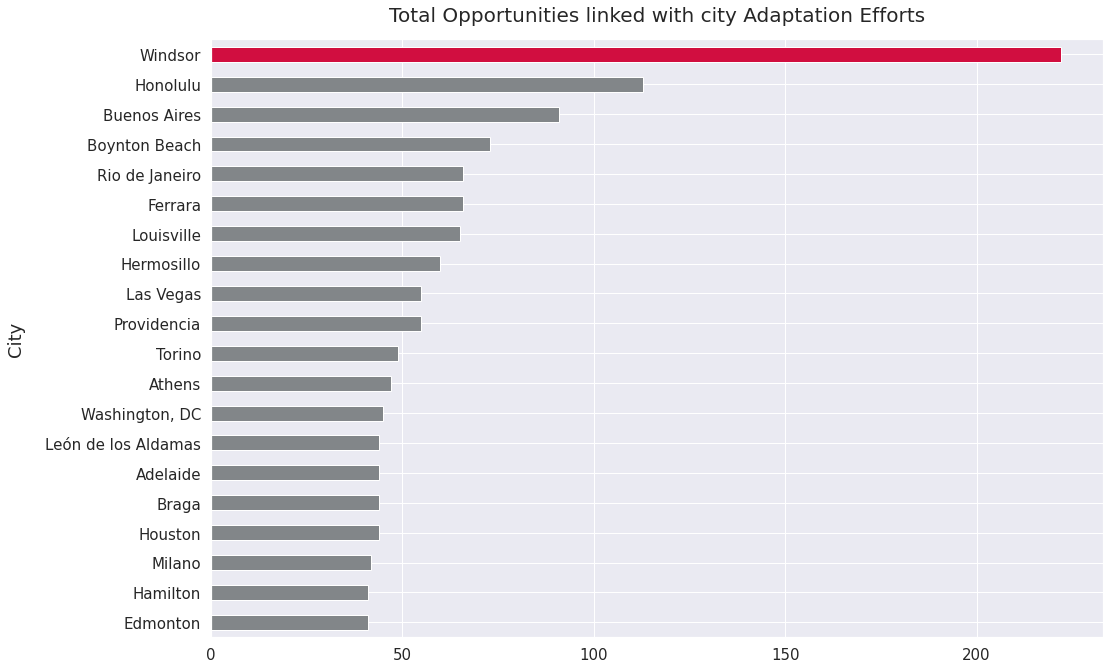

In [34]:
# joing adaptation actions using action/opportunity mapping and counting available opportunities
piv3.join(climate_action_opportunity.set_index('Action'), on='Action') \
.groupby(['City'])['Opportunities'].count().sort_values(ascending=False)[:20] \
.plot.barh(figsize=(16,11), color=palette[0:1]+[grey]*19, title='Total Opportunities linked with city Adaptation Efforts');
plt.gca().invert_yaxis()

Thereafter, we calculate _Adaptation Incentive._ The following visualization shows the contribution of vulnerability and opportunity payoff for the top 20 cities ranked by total incentive.

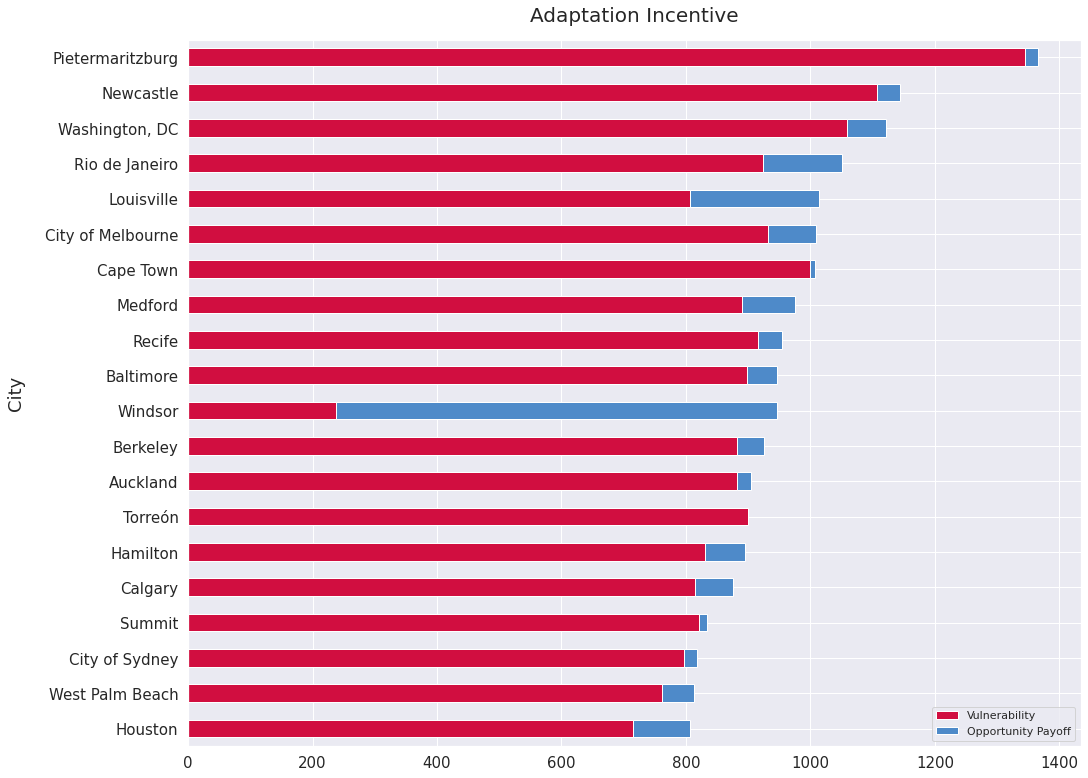

In [35]:
# calculating the count of each kind of action and total number of associated cobenefits, joining on with corresponding opportunites
opportunities = piv3.groupby(CITY_GROUP+ ['Climate hazards', 'Action'])[['actions_count', 'cobenefit_count']].sum() \
.join(climate_action_opportunity.groupby('Action')['Opportunities'].count(), on='Action')

# calculate opportunity payoff
opportunities['op_payoff'] = opportunities['Opportunities'] * opportunities['actions_count'] * np.sqrt(opportunities['cobenefit_count'])

# join with vulnerability score for each climate hazard
incentive = opportunities.groupby(CITY_GROUP+ ['Climate hazards'])[['op_payoff']].sum() \
.join(hazard_stack['vulnerability_haz'], on=CITY_GROUP+['Climate hazards']).reset_index().set_index(['City', 'Account Number'])

# calculate adaptation incentive for each hazard using vulnerability and opportunity payoff
incentive['incentive'] = incentive['vulnerability_haz'] + incentive['op_payoff']
# perform final sum over hazards to get values for cities
temp = incentive.groupby(['City'])[['vulnerability_haz', 'op_payoff']].sum()
temp['incentive'] = temp.sum(axis=1)
temp.sort_values('incentive', ascending=False)[:20].drop('incentive', axis=1) \
.plot.barh(stacked=True, color=palette[:2], title='Adaptation Incentive') \
.legend(['Vulnerability', 'Opportunity Payoff']);
plt.gca().invert_yaxis()

Although composed mainly of the vulnerability, this metric remains an extremely important indicator for cities that may have high opportunity payoff, but no direct incentive to adapt due to low vulnerability. As seen when we rank cities by their total opportunity payoff, the added incentive from Opportunities becomes critical to get cities to take future-oriented steps to mitigate risk from unseen climate events. Moreover, it provides the extra push needed to get city administrations to take actions that would benefit the well being of the populations living within them, even if no real risk of climate change exists.

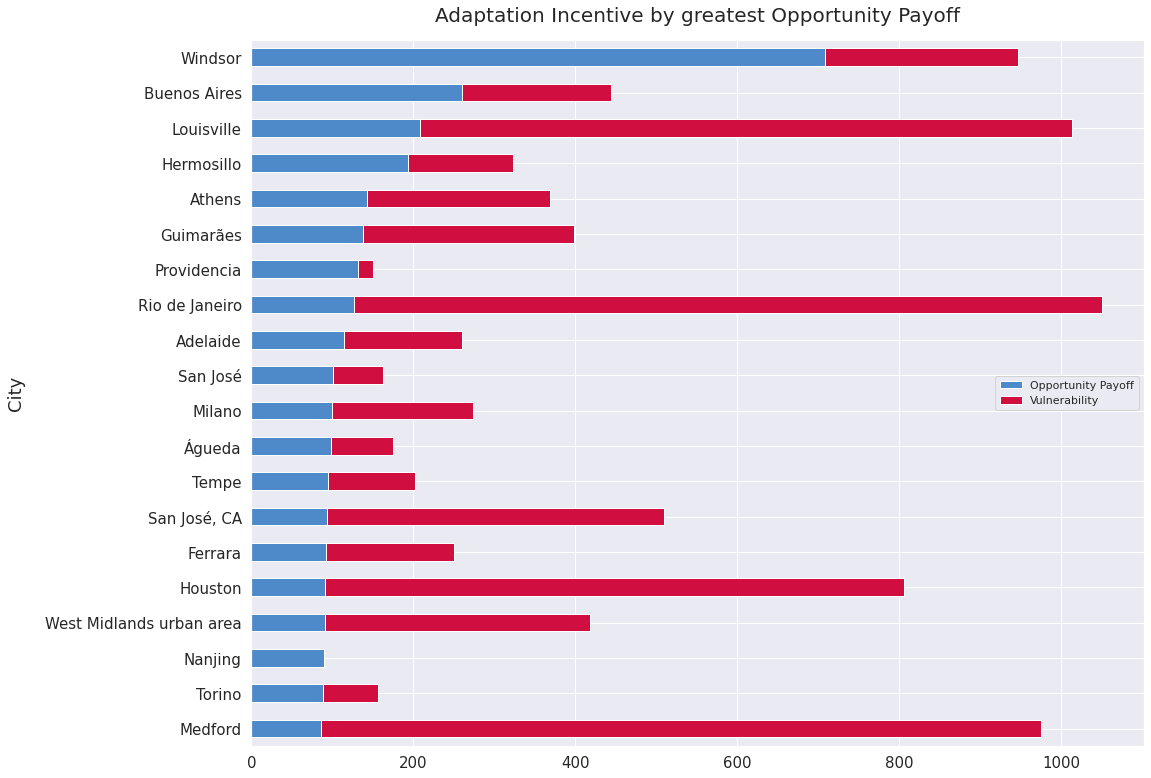

In [36]:
temp = incentive.groupby(['City'])[['op_payoff', 'vulnerability_haz']].sum()
temp['incentive'] = temp.sum(axis=1)
temp.sort_values('op_payoff', ascending=False)[:20].drop('incentive', axis=1) \
.plot.barh(stacked=True, color=palette_r[1:], title='Adaptation Incentive by greatest Opportunity Payoff') \
.legend(['Opportunity Payoff', 'Vulnerability', ]);
plt.gca().invert_yaxis()

So far we have discussed incentive to adapt, but circumstances for every city differ, making it more difficult, in some cases, to be able to adapt even if the incentives are there. So with our next metric we look at _Adaptability._

---
<strong id="#metric3"><em>Metric 3: Adaptability</em></strong>  
_Ability of a city to adapt to climate change._
<br><br>

$$ \begin{align} & Adaptability_{city} = AdaptabilityFactor_{city} \times Proactiveness_{city} \times (10 \times HumanCapitalScore + \log_{10}(1 + Funding)), \\ \\ \text{where } \\ & AdaptabilityFactor= \sum_{i=1}^{factors}Impact_{i} \times Degree_{i}, \\ \text{and } & Funding = \text{Average estimated funding available per adaptation action} \end{align}$$

**Rationale**  
Overcoming climate change risks involves both mitigative actions, such as to reduce GHG emissions, as well as adapting to actual or future climate changes.[<sup>[Link]</sup>](https://go.nasa.gov/2KRPBaP) The adaptation ability of a city depends on the available funding and human capital, along with the total proactiveness in terms of conducting the activities needed for successful adaptation or transition. _Adaptability_ measures the ease or difficulty associated with this process of adaptation.

---

We use the World Bank [Human Capital Index data](https://datacatalog.worldbank.org/dataset/human-capital-index) to arrive at a rough estimate of the human capital available to each city to plan, perform tasks, and conduct activities needed to increase city resilience and mitigate climate risk. Proactiveness is a measure of the city's drive to bring about positive change. This is estimated from the number of adaptation actions they are implementing.

The Adaptability Factor is calculated as a sum of products of the degree and impact of factors affecting adaptation efforts, as reported by cities in question `2.2`. Here the impact may be one of "Challenges" or "Supports", while the degree is the associated magnitude of the impact.

The funding available to cities is estimated from the history of implementation of adaptation actions by the city. Here we assume that the funding in the future is likely to remain in the range of the average funding for previous adaptation related actions. 

In [37]:
# join adaptation action data with city currency dataframe to get exchange rates for each city
piv3 = piv3.join(currency)
# normalizing project costs to USD
piv3['Total cost $'] = piv3['Exchange Rate'] * (piv3['Total cost of the project (currency)'].astype('float32'))

# Calculate average funding for adaptation initiatives from question on adaptation actions
funding = piv3.groupby(['City', 'Account Number'])[['Total cost $', 'actions_count']].sum()
funding['avg_funding $'] = funding['Total cost $']/funding['actions_count']


# create replacement dicts for factoes affecting adaptability
DEGREES = {'Significantly challenges': 0.25, 'Moderately challenges': 0.5, 'Somewhat challenges': 1, 
           'Significantly supports': 4, 'Moderately supports': 2, 'Somewhat supports': 1}
IMPACTS = {'Challenges': 0.5, 'Supports': 1}

In [38]:
c2_2 = get_cities('2.2', cols=CITY_GROUP)
piv2_2 = c2_2.pivot(index=CITY_GROUP+['Row Number'], columns=['Column Name'])['Response Answer']

impact = 'Indicate if this factor either supports or challenges the ability to adapt' 
degree = 'Level of degree to which factor challenges/supports the adaptive capacity of your city'

# replace with numerical values from replacement dicts
piv2_2[impact] = piv2_2[impact].replace(IMPACTS)
piv2_2[degree] = piv2_2[degree].replace(DEGREES).fillna(1)

# calculate adaptabilty factor
piv2_2['adapt_factor'] = piv2_2[impact] * piv2_2[degree]

# add data for avg funding for each city and for human capital index score for countries
# inner join will drop cities for which data on adaptation actions/funding is not available
piv2_2 = piv2_2.groupby(CITY_GROUP)[['adapt_factor']].sum() \
.join(funding[['avg_funding $', 'actions_count']], on=['City', 'Account Number'], how='inner') \
.join(human_capital['HUMAN CAPITAL INDEX 2020'], on='Country', how='inner')

# TODO adaptability range
# .join(human_capital[['HUMAN CAPITAL INDEX 2020 (LOWER BOUND)', 'HUMAN CAPITAL INDEX 2020', 'HUMAN CAPITAL INDEX 2020 (UPPER BOUND)']], on='Country', how='inner')

# let's only consider cities reporting at least some funding data
piv2_2 = piv2_2[piv2_2['avg_funding $'] > 0]

# calculate adaptability
piv2_2['Adaptability'] = (piv2_2['adapt_factor']  * piv2_2['actions_count'] * (10*piv2_2['HUMAN CAPITAL INDEX 2020'] + np.log10(1 + piv2_2['avg_funding $'])))
city_df['Adaptability'] = piv2_2['Adaptability']
# .value_counts().sort_values(ascending=False)[:53].unstack() \
# .plot(kind='barh', cmap='tab20', stacked=True, figsize=(12, 8), title='Factors affecting adaptation ability (2020)');

On calculating _Adaptability,_ we see there exists a massive divide between the top 20 and bottom 20 cities in terms of how easy it may be for them to adapt. The table following the bar chart attempts to shed some light on the reason for this divide, and we see just how important the different components of _Adaptability_ are, in order for a city to score highly.

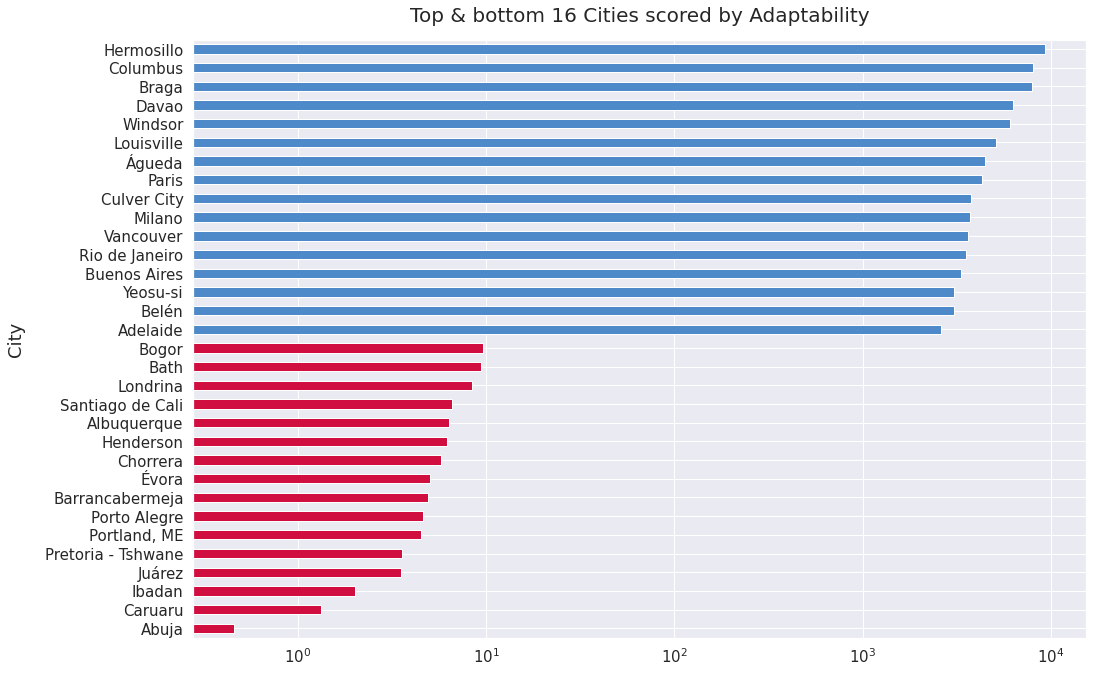

In [39]:
temp = city_df[['Exposure', 'Adaptability']].dropna(subset=['Adaptability']).sort_values('Adaptability', ascending=False)
pd.concat([temp[:16], temp[-16:]]).reset_index().plot.barh(x='City', y='Adaptability', figsize=(16, 11), color=palette[1:2]*16 + palette[:1]*16,
                                                           title='Top & bottom 16 Cities scored by Adaptability', logx=True, legend=False);
plt.gca().invert_yaxis()

In [40]:
temp2 = piv2_2.dropna(subset=['Adaptability']).sort_values('Adaptability', ascending=False)
pd.concat([temp2[:20], temp2[-20:]]).reset_index([0,1], drop=True).style.background_gradient('Reds').set_precision(2) \
.set_caption('Constituents of Adaptability')

---
The visualisations and metrics discussed so far are a starting point for vulnerability assessment, and establish a thorough understanding of the impacts of climate change, and the needed governance. They work to expose the key issues of inequality in terms of the high climate exposure on the poor and elderly. The data further calls attention to the many risks that are often ignored, like the future strain expected on health and sanitation, law and order, food availability, education etc. 

The root-level analysis undertaken to calculate _Vulnerability,_ shows the ambitious attempts of highly exposed cities to build resilience against climate hazards, and thus, their commitment towards protecting their populations. Next, we develop a methodology to determine how climate action leads to environmental and social opportunities, for example, Real-time risk monitoring (adaptation action) resulting in Development of climate change resiliency projects (opportunity), and how this opportunity payoff may provide further motivation for cities to implement forward looking adaptation actions.

Finally, we assess the ability of a city to build resilience by mobilizing the economic and professional potential of its citizens. This results in bringing out the vast divide between the top and bottom cities in their ability to adapt.  


<h2 id="corporate-vulnerability">1.2 Corporate Vulnerability</h2>

Climate change is a universal problem and its repercussions will be felt by many businesses. The issue has pushed many companies to start disclosing data on their climate change related financial impact, and in 2018, CDP measured these losses to be equivalent to $1 trillion. Many of these financial impacts are expected to materialize within the next five years.[<sup>[Link]</sup>](https://www.nytimes.com/2019/06/04/climate/companies-climate-change-financial-impact.html) The warming planet has made it clear that business as usual is no longer a feasible option in the long term and this is just the tip of the iceberg. Solving this problem involves getting to the root of it, and that requires us to adopt a systems approach to dealing with complex interrelationships between entities and objectives, causes and effects.

With our next metric, we aim to shed light on some of these relationships by quantifying the financial and strategic impact of climate change on corporations and comparing it with their impact on the environment and people. Finally we establish a way for CDP to find relevant social issues for corporations to address.


---
<strong id="#metric4"><em>Metric 4: Climate Liability</em></strong>  
_A measure of the total risk to corporations from aggregated financial and strategic impacts of climate change._
<br><br>

$$\begin{align} & ClimateLiability_{org} = \sum_{i=1}^{risks}(LiabilityFactor_{i} \times TotalCost_{i}), \\ \text{where } \\ & LiabilityFactor_{i} = Magnitude_{i} \times Likelihood_{i} \times Timeframe_{i} \end{align}$$

**Rationale**  
The risks from climate change run deeper than a simple dollar value of the total financial impacts incurred. Alongside these, various other factors such as indirect consequences on employees and stakeholders, changes in markets and preferences of customers, and effects on the social community at large must also be considered, as these in turn affect business operations. In view of this, we present a metric that, in addition to the financial impacts, uses the company's self assessment of the magnitude, likelihood and timeframe of expected climate risks, and scores the total liability to the company in terms of the extended, indirect issues.

---
The total cost related to a climate risk is calculated as a sum of the cost of response and the direct financial impact. We then calculate liability for each risk, and aggregate values for all risks to find total _Climate Liability._

In [41]:
# replacement dicts for climate change financial impact
CREPLACE_CAT = {'High': 5, 'Medium-high': 4, 'Medium': 3, 'Medium-low': 2, 'Low': 1, 'Unknown': 1}
CREPLACE_CAT2 = {'Virtually certain': 5, 'Very likely': 4, 'Likely': 3, 'More likely than not': 2, 'About as likely as not': 1, 
                 'Unlikely': 0.5, 'Very unlikely': 0.25, 'Exceptionally unlikely': 0.125, 'Unknown': 1}
CREPLACE_TERM = {'Short-term': 3, 'Medium-term': 2, 'Long-term': 1, 'Unknown': 1}

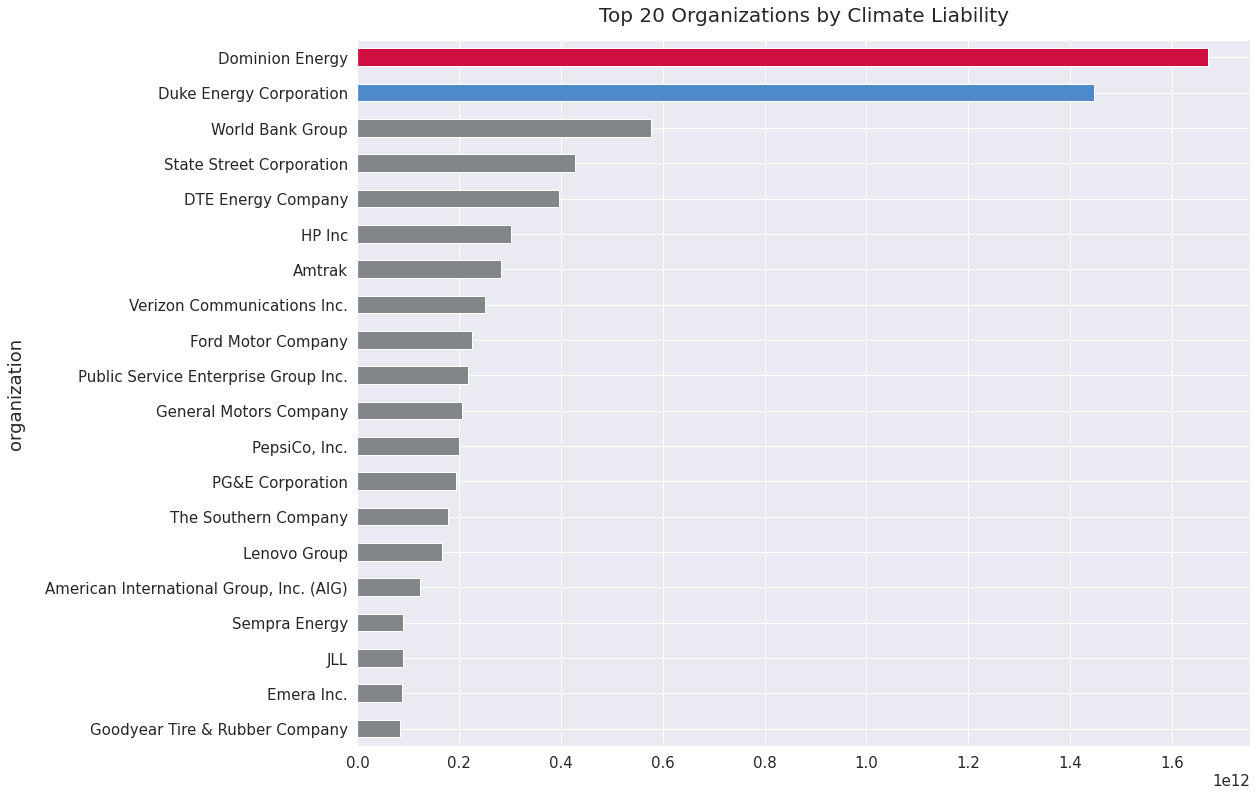

In [42]:
cc2_3a = get_climate('C2.3a').pivot(index=['organization', 'account_number', 'row_number'], columns='column_name')['response_value']

# replace fields with nummerical values
cc2_3a['magnitude'] = cc2_3a['C2.3a_C9Magnitude of impact'].replace(CREPLACE_CAT).fillna(1)
cc2_3a['likelihood'] = cc2_3a['C2.3a_C8Likelihood'].replace(CREPLACE_CAT2).fillna(1)
cc2_3a['timeframe'] = cc2_3a['C2.3a_C7Time horizon'].replace(CREPLACE_TERM).fillna(1)

cc2_3a['C2.3a_C12Potential financial impact figure â€“ minimum (currency)'] = cc2_3a['C2.3a_C12Potential financial impact figure â€“ minimum (currency)'].astype('float32').fillna(0)
# in case a price range is provided, replace cost with minimum expected cost
cc2_3a['C2.3a_C11Potential financial impact figure (currency)'] = cc2_3a['C2.3a_C11Potential financial impact figure (currency)'] \
    .astype('float32').fillna(cc2_3a['C2.3a_C12Potential financial impact figure â€“ minimum (currency)'])

cc2_3a['C2.3a_C15Cost of response to risk'] = cc2_3a['C2.3a_C15Cost of response to risk'].astype('float32').fillna(0)

# join with currency dataframe to get currency exchange rates
cc2_3a = cc2_3a.join(currency_cc)

# total impact = cost of response + (minimum) potential financial imapct
# normalizing to USD
cc2_3a['Total Financial Impact $'] = cc2_3a['Exchange Rate'] * (cc2_3a['C2.3a_C15Cost of response to risk'] + cc2_3a['C2.3a_C11Potential financial impact figure (currency)'])

# calculate liability factor
cc2_3a['liability_factor'] = cc2_3a['magnitude'] * cc2_3a['likelihood'] * cc2_3a['timeframe']
cc2_3a['Climate Liability'] = cc2_3a['Total Financial Impact $'] * cc2_3a['liability_factor']

# add all values for a company
g2_3 = cc2_3a.groupby(['organization', 'account_number'])[['Total Financial Impact $', 'Climate Liability']].sum()
# ignore companies with no costs reported
g2_3 = g2_3[g2_3['Total Financial Impact $']>0]

# add revenue and earnings data for organizations 
g2_3 = g2_3.join(impact_mapping, on=['account_number'], how='left').join(cdp_fin_data[['Revenue', 'Operating Income (Loss)']])
# g2_3['cost %'] = g2_3['total_cost $']*100/g2_3['Total Environmental Cost']

g2_3.reset_index().sort_values('Climate Liability', ascending=False)[:20] \
.plot.barh(x='organization', y='Climate Liability', color=palette[:2]+[grey]*18,
           title='Top 20 Organizations by Climate Liability', legend=False);
plt.gca().invert_yaxis()

Now that we have figures for the total _Climate Liability,_ we can see is that the top companies by liability all happen to be large corporations. This might cause one to think _Climate Liability_ depends on the size of a company, but as we'll see next, there is only a 6% coorelation between revenue and lability.

Another interesting comparison point is between liability and the total Environmental Impact Costs of the company as provided in the HBS - Impact weighted accounts dataset. Here, we see something quite unexpected!

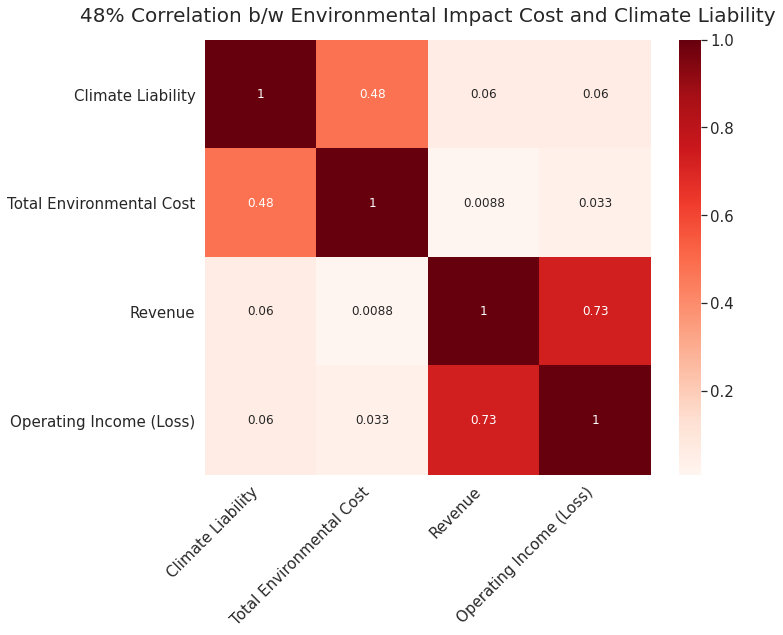

In [43]:
plt.subplots(figsize=(10,8))
sns.heatmap(g2_3.drop('Total Financial Impact $', axis=1).corr(), annot=True, cmap='Reds');
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('48% Correlation b/w Environmental Impact Cost and Climate Liability')
plt.show()

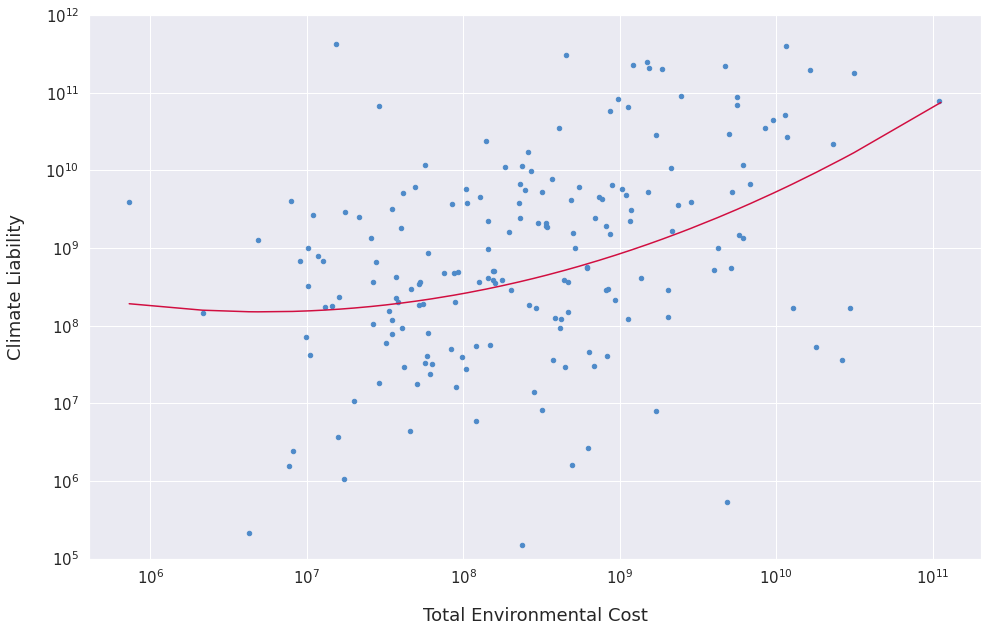

In [44]:
temp = g2_3[['Total Environmental Cost', 'Climate Liability']].dropna().sort_values('Total Environmental Cost')

d = np.polyfit(np.log10(temp['Total Environmental Cost']), np.log10(temp['Climate Liability']), 2)
f = np.poly1d(d)
temp['y_pred'] = np.power(10, f(np.log10(temp['Total Environmental Cost'])))

ax = temp.plot.scatter(x='Total Environmental Cost', y='Climate Liability',
                       logx=True, logy=True, color=palette[1],figsize=(16, 10));
temp.plot(x='Total Environmental Cost',y='y_pred', legend=False, ax=ax, color=palette[0]);
plt.ylim([100000, 1000000000000]);

There is a significant correlation between the impact of organizations on the environment, and the liability they face due to climate risk. Moreover, we see there is absolutely no association between Environmental Cost and Revenue/Income, which tells us that that there are cleaner, more profitable, ways to seek high returns for shareholders.

Next, we map the primary climate-related **physical risk** drivers for organizations with natural hazards (faced by cities) wherever there is a high degree of overlap or relatedness in their underlying cause. This enables us to look at the coexisting social issues corresponding to the climate risks companies face. The mapping also includes the physical risks listed in the Water Security Questionnaire, but these will be used in a later section.

In [45]:
# city - corporate risk mapping
risk_mapping = pd.DataFrame([
    ('Extreme Precipitation > Rain storm', 'Flooding'),
    ('Extreme Precipitation > Monsoon', 'Flooding'),
    ('Extreme Precipitation > Rain storm', 'Changes in precipitation patterns and extreme variability in weather patterns'),
    ('Extreme Precipitation > Monsoon', 'Changes in precipitation patterns and extreme variability in weather patterns'),
    ('Extreme Precipitation > Heavy snow', 'Changes in precipitation patterns and extreme variability in weather patterns'),
    ('Extreme Precipitation > Fog', 'Changes in precipitation patterns and extreme variability in weather patterns'),
    ('Extreme Precipitation > Hail', 'Changes in precipitation patterns and extreme variability in weather patterns'),
    ('Extreme Precipitation > Rain storm', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Extreme Precipitation > Monsoon', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Extreme Precipitation > Heavy snow', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Extreme Precipitation > Fog', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Extreme Precipitation > Hail', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Storm and wind > Severe wind', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Storm and wind > Tornado', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Storm and wind > Cyclone (Hurricane / Typhoon)', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Storm and wind > Extra tropical storm', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Storm and wind > Tropical storm', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Storm and wind > Storm surge', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Storm and wind > Lightning / thunderstorm', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Extreme cold temperature > Extreme winter conditions', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Extreme cold temperature > Cold wave', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Extreme cold temperature > Extreme cold days', 'Increased severity and frequency of extreme weather events such as cyclones and floods'),
    ('Extreme hot temperature > Heat wave', 'Rising mean temperatures'),
    ('Extreme hot temperature > Extreme hot days', 'Rising mean temperatures'),
    ('Water Scarcity > Drought', 'Drought'),
    ('Water Scarcity > Drought', 'Severe weather events'),
    ('Water Scarcity > Drought', 'Increased water scarcity'),
    ('Water Scarcity > Drought', 'Seasonal supply variability/inter annual variability'),
    ('Wild fire > Forest fire', 'Increased likelihood and severity of wildfires'),
    ('Wild fire > Land fire', 'Increased likelihood and severity of wildfires'),
    ('Flood and sea level rise > Flash / surface flood', 'Rising sea levels'),
    ('Flood and sea level rise > River flood', 'Rising sea levels'),
    ('Flood and sea level rise > Coastal flood', 'Rising sea levels'),
    ('Flood and sea level rise > Groundwater flood', 'Rising sea levels'),
    ('Flood and sea level rise > Permanent inundation', 'Rising sea levels'),
    ('Flood and sea level rise > Flash / surface flood', 'Flooding'),
    ('Flood and sea level rise > River flood', 'Flooding'),
    ('Flood and sea level rise > Coastal flood', 'Flooding'),
    ('Flood and sea level rise > Groundwater flood', 'Flooding'),
    ('Flood and sea level rise > Permanent inundation', 'Flooding'),
    ('Chemical change > Salt water intrusion', 'Ecosystem vulnerability'),
    ('Chemical change > Ocean acidification', 'Ecosystem vulnerability'),
    ('Chemical change > Atmospheric CO2 concentrations', 'Ecosystem vulnerability'),
    ('Mass movement > Landslide', ''),
    ('Mass movement > Avalanche', ''),
    ('Mass movement > Rock fall', ''),
    ('Mass movement > Subsidence', ''),
    ('Biological hazards > Water-borne disease', 'Poorly managed sanitation'),
    ('Biological hazards > Vector-borne disease', 'Poorly managed sanitation'),
    ('Biological hazards > Air-borne disease', ''),
    ('Biological hazards > Insect infestation', ''),
    ('Increased water stress', 'Increased water stress'),
    ('Increased water stress', 'Rationing of municipal water supply'),
    ('Increased water stress', 'Water stress'),
    ('Increased water scarcity', 'Rationing of municipal water supply'),
    ('Increased water scarcity', 'Increased water scarcity'),
    ('Declining water quality', 'Declining water quality'),
    ('Inadequate or ageing water supply infrastructure', 'Inadequate infrastructure'),
    ('Higher water prices', 'Increased water scarcity'),
    ('Environmental regulations', 'Ecosystem vulnerability'),
    ('Environmental regulations', 'Declining water quality'),
    ('Environmental regulations', 'Pollution incident'),
    ('Increased water demand', 'Seasonal supply variability/inter annual variability'),
    ('Drought', 'Drought'),
    ('Drought', 'Seasonal supply variability/inter annual variability'),
    ('Energy supply issues', 'Dependency on water intensive energy sources'),
    ('Rationing of municipal water supply', 'Rationing of municipal water supply'),
    ('Rationing of municipal water supply', 'Increased water scarcity'),
    ('Rationing of municipal water supply', 'Seasonal supply variability/inter annual variability'),
    ('Severe weather events', 'Severe weather events'),
    ('Ecosystem vulnerability', 'Ecosystem vulnerability'),
    ('Change in land-use', 'Change in land-use'),
    ('Pollution incidents', 'Pollution incident'),
    ('Pollution incidents', 'Pollution of water bodies due to fertilizer, other chemical use, or animal residues'),
    ('Pollution incidents', 'Leaching of pollutants to groundwater bodies'),
    ('Pollution incidents', 'Acid rock drainage and metal leaching'),
    ('Pollution incidents', 'Increased levels of plastic in fresh water bodies'),
    ('Pollution incidents', 'Rupture of tailings dams and toxic spills'),
    ('Increased levels of plastic in freshwater bodies', 'Increased levels of plastic in fresh water bodies'),
    ('Water infestation/disease', 'Poorly managed sanitation'),
    ('Unauthorized/unregistered water connections', 'Inadequate infrastructure'),
    ('Unauthorized/unregistered water connections', 'Increased water scarcity')
], columns=['city_risk', 'corporate_risk'])

risk_mapping[2:24].reset_index(drop=True).style.set_caption('Sample from the risk mapping')

With the mapping, we can now visualize correlations between the occurrence of physical risks corporations have reported and various social issues. We can also view the mean _Climate Liability,_ corresponding to each social issue to get an idea of the relationship between corporate and social impacts of climate change.

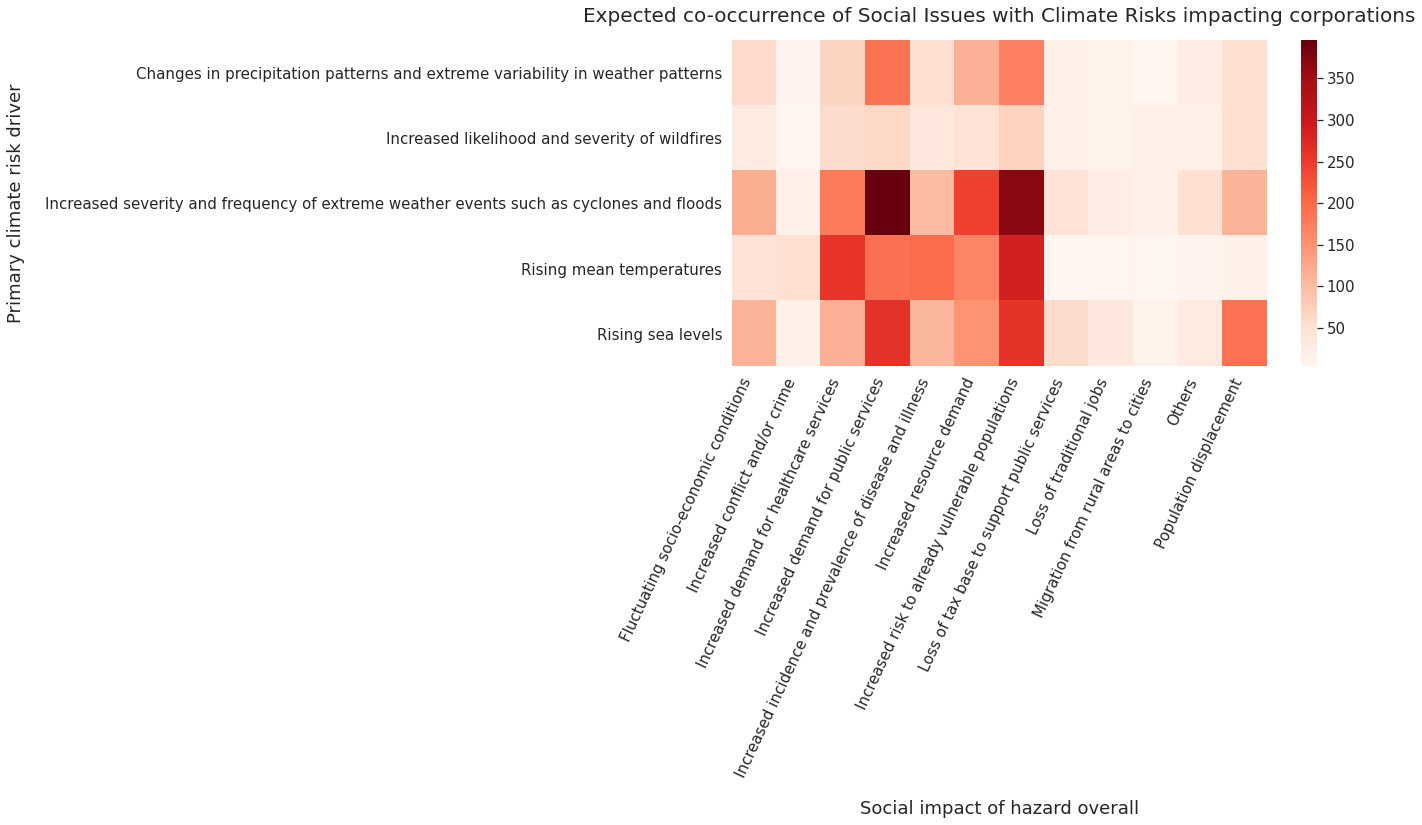

In [46]:
# social issues arising from climate change
social_corp2_1 = piv2_1.explode('Social impact of hazard overall')
# replacing all self stated categories with "Others"
social_corp2_1.loc[social_corp2_1['Social impact of hazard overall'].str.contains('Other, ', na=False), 'Social impact of hazard overall'] = 'Others'

# use risk mapping to combine corporate risk drivers with the number of each social issue
social_risks = cc2_3a.reset_index()[['C2.3a_C3Risk type & Primary climate-related risk driver']].drop_duplicates() \
      .join(risk_mapping.set_index('corporate_risk'), on='C2.3a_C3Risk type & Primary climate-related risk driver', how='inner') \
      .join(social_corp2_1.groupby('Climate Hazards')['Social impact of hazard overall'] \
            .value_counts().rename('count').reset_index(1), on='city_risk', how='inner')

# since the mapping is 1-to-many, to get the social issues for a single corporate risk driver, we will add up mapped values
temp = social_risks.groupby(['C2.3a_C3Risk type & Primary climate-related risk driver', 'Social impact of hazard overall'])['count'].sum().unstack()

plt.subplots(figsize=(12, 6))
sns.heatmap(temp, cmap='Reds');
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('Primary climate risk driver')
plt.title('Expected co-occurrence of Social Issues with Climate Risks impacting corporations')
plt.show()

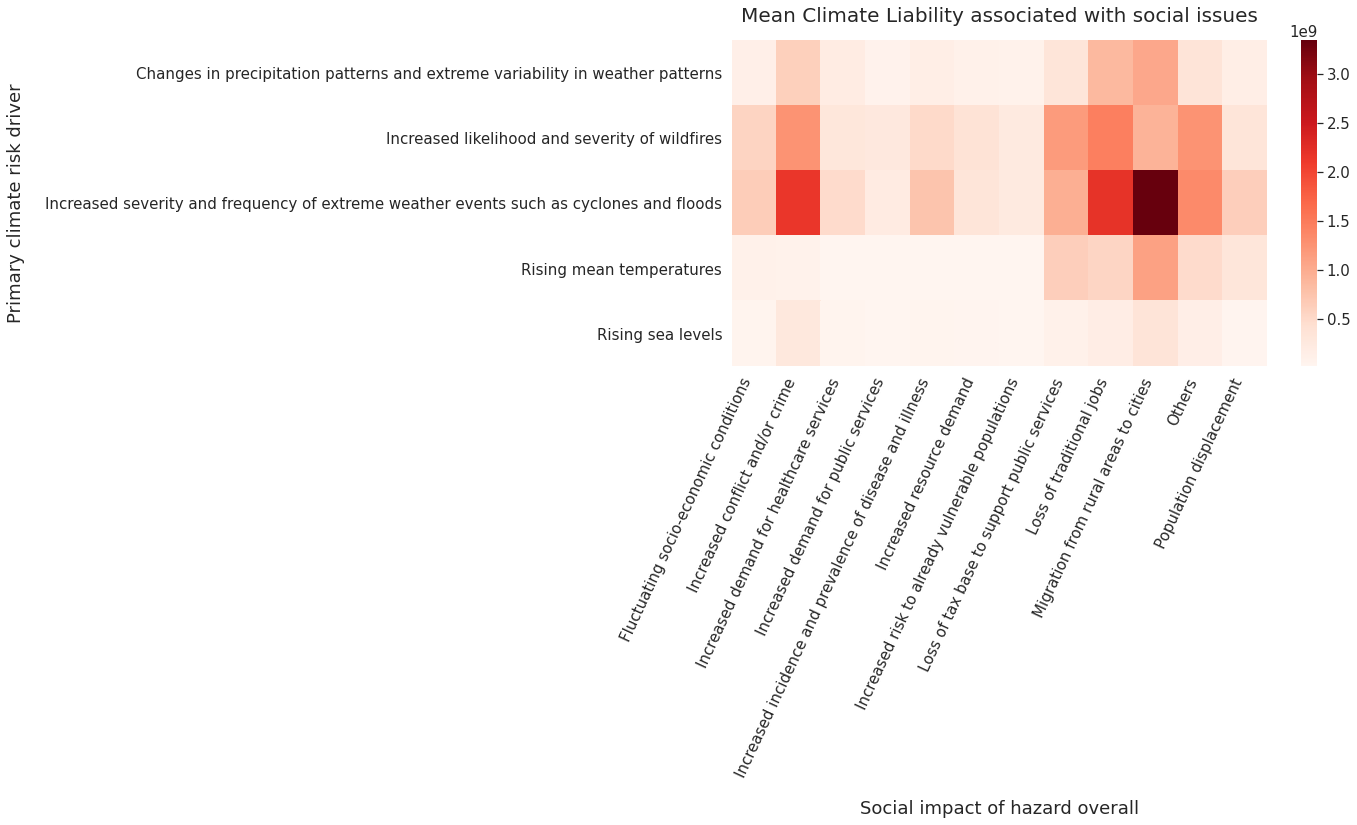

In [47]:
social_liability = cc2_3a.groupby(['C2.3a_C3Risk type & Primary climate-related risk driver'])[['Climate Liability']].mean() \
      .join(risk_mapping.set_index('corporate_risk'), on='C2.3a_C3Risk type & Primary climate-related risk driver', how='inner') \
      .join(social_corp2_1.groupby('Climate Hazards')['Social impact of hazard overall'] \
            .value_counts().rename('count').reset_index(1), on='city_risk', how='inner').sort_index()

# since the mapping is 1-to-many, to get the social issues for a single corporate risk driver, we will add up mapped values
temp = social_liability.groupby(['C2.3a_C3Risk type & Primary climate-related risk driver', 'Social impact of hazard overall'])[['Climate Liability', 'count']].sum()
# calculating average liability linked to each social issue
temp['Average Liability'] = temp['Climate Liability']/temp['count']

plt.subplots(figsize=(12, 6))
sns.heatmap(temp['Average Liability'].unstack(), cmap='Reds');
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('Primary climate risk driver')
plt.title('Mean Climate Liability associated with social issues')
plt.show()

___
And this brings us back to the point we were making at the start of this section. Which is, when we think linearly about cause and effect we view it as occurring within the same period displaying only obvious linkages, however, adopting systems thinking shows that cause and effect are separated in time and space. In the case of corporations, we first notice that the _Climate Liability_ they face is at least partially the result of their environmental impact from activities including, but not limited to, unregulated CO2 emissions, overconsumption of resources, poor waste management, and others that affect the health of the planet.

But in addition to that, we see an indirect association which highlights how these activites, due to their role in to various climate hazards, are closely related to and cause social issues. These issues disproportionately put the lives of the poor and vulnerable at risk, cause the loss of livelihoods, lead to mass migrations and population displacement, increase the transmission of infectious diseases, and in general affect resource availability and health. However, the world continues to view climate action by corporations as voluntary or goodwill, when in reality it should be their responsibility!

It is also of note that the CDP Climate Change Questionnaire for corporations, although comprehensive in terms of asking for climate related data, has hardly any mention of the social impacts related to corporate activities.

<h1 style="color: #FFFFFF" id="climate-impact">7 Climate Impact</h1>
<h2 id="emissions">7.1 Emissions</h2>

<img src="https://static01.nyt.com/images/2015/11/29/opinion/sunday/29sun1/29sun1-jumbo.gif?quality=90&auto=webp" width=800px>

[NYTimes](https://www.nytimes.com/2015/11/29/opinion/sunday/what-the-paris-climate-meeting-must-do.html)
<br><br>

<h3 id="city-emissions">7.1.1 City Emissions</h3>

Global Warming will have visible effects on people's livelihoods, and a strong and adverse impact on human health. The rise in CO2 emissions, which is the primary cause of Global Warming, is projected to cause direct risks like heat waves, floods, storms, asthma and other respiratory diseases and more complex pathways of altered infectious disease patterns, disruptions of agricultural and other supportive ecosystems, and potentially population displacement and conflict over depleted resources, such as water, fertile land and fisheries.[<sup>[Link]</sup>](https://www.who.int/globalchange/GenderClimateChangeHealthfinal.pdf) 

It is also known that few of the larger cities contribute disproportionately to the worldwide emissions. These include the densely populated cities in the developing world, but also highly industrialized cities in more developed nations. We can see this in the map below. Moreover, there is a strong positive correaltion between city GDP and total emissions, as seen in the scatter plot below for cities in the OECD nations.

In [48]:
c4_6a = get_cities('4.6a', by='Row Name', cols=['Country', 'City', 'Account Number']).dropna(subset=['City'])
piv4_6a = c4_6a.pivot(index=['Country', 'City', 'Account Number', 'Row Name'], columns='Column Name')['Response Answer']

piv4_6a = piv4_6a[[
    'Direct emissions (metric tonnes CO2e)',
    'Indirect emissions from the use of grid-supplied electricity, heat, steam and/or cooling (metric tonnes CO2e)',
    'Emissions occurring outside the city boundary as a result of in-city activities (metric tonnes CO2e)'
]].astype('float32').groupby(['Country', 'City', 'Account Number']).sum() \
.join(population).join(city_locations.set_index('Account Number', append=True))

piv4_6a = piv4_6a.reset_index([0])
piv4_6a['Total Emissions'] = piv4_6a.sum(axis=1)
piv4_6a['per_capita_emissions'] = piv4_6a['Total Emissions']/piv4_6a['Population']
piv4_6a['log(per capita emissions)'] = np.log10(1+piv4_6a['per_capita_emissions'])
piv4_6a['log(Total Emissions)'] = np.log10(1+piv4_6a['Total Emissions'])

# piv4_6a.sort_values('per_capita_emissions', ascending=False)

fig =  px.scatter_geo(piv4_6a.reset_index(), lat='lat',
            lon='lon', 
            hover_data=['Total Emissions', 'per_capita_emissions'],
            text='City',
            size='log(per capita emissions)',
            color_continuous_scale=px.colors.sequential.Reds,            
           color ='log(Total Emissions)',
            size_max=18,
            title='Total (color) and per capita (size) City Emissions',
)
fig.update_layout(height=560, margin={"r":0,"t":30,"l":0,"b":0})
fig.update_geos(showcountries=True, countrywidth=0.2, showcoastlines=False)

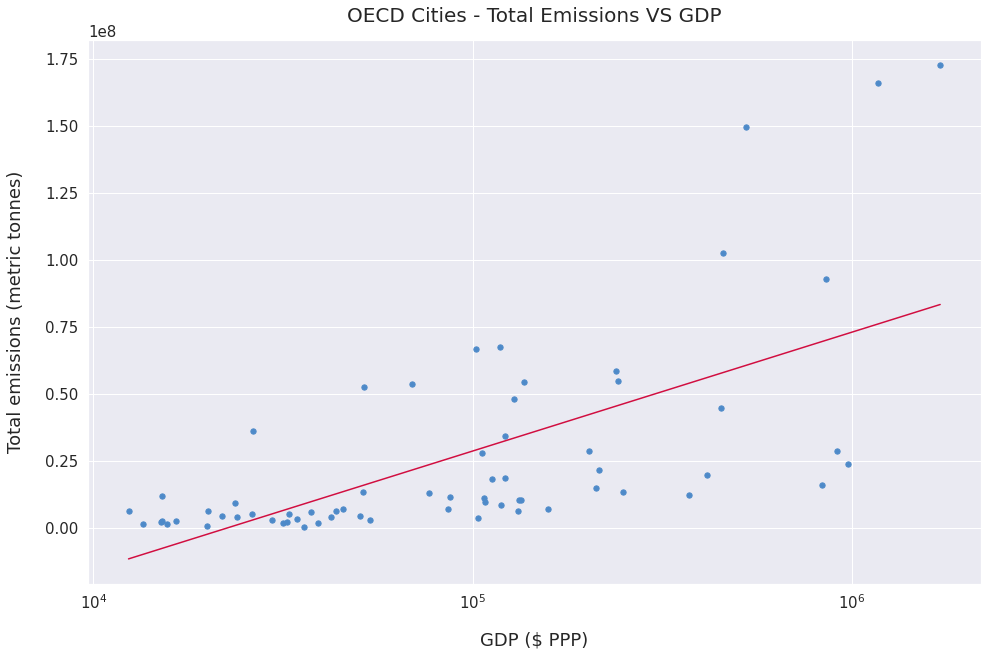

In [49]:
temp = piv4_6a.join(city_gdp, on=['Country', 'City'])[['GDP_REAL_PPP', 'Total Emissions']].dropna().sort_values('GDP_REAL_PPP')
d = np.polyfit(np.log10(temp['GDP_REAL_PPP']), temp['Total Emissions'], 1)
f = np.poly1d(d)
temp['y_pred'] = f(np.log10(temp['GDP_REAL_PPP']))

ax = temp.plot.scatter(x='GDP_REAL_PPP', y='Total Emissions',
                       logx=True, s=28, color=palette[1],figsize=(16, 10),
                      title='OECD Cities - Total Emissions VS GDP');
temp.plot(x='GDP_REAL_PPP',y='y_pred', legend=False, ax=ax, color=palette[0]);

plt.xlabel('GDP ($ PPP)');
plt.ylabel('Total emissions (metric tonnes)');

To safeguard the world from the expected chaos that will ensue if Global Warming is not checked, it requires a wartime level scale of government mobilisation[<sup>[Link]</sup>](https://www.wri.org/our-work/project/world-resources-report/climate-change-adaptation-and-national-security) from cities around the world, but especially from in the developed nations who are much more equipped to take action against climate change. With this section, we dive into the next important step of climate action, _Mitigation,_ and this involves developing a metric that could help governments efficiently track the progress of their emission mitigation actions.

---
<strong id="#metric5"><em>Metric 5: Lifetime Mitigation Score</em></strong>  
_Lifetime performance (or utility) of a city's emission mitigation action at reducing direct and indirect emissions of CO2 equivalencies._  
<br><br>

$$\begin{align} LifetimeMitigationScore & = \log_{10}(1 + DirectEmissionReduction_{metricTonnesCO2e})\\ & + \log_{10}(1 + IndirectEmissionReduction_{metricTonnesCO2e}) \\ & - \log_{10}(1 + CostOfProject),\end{align}$$
<br>
$\text{where } \\ \quad \quad IndirectEmissionReduction_{metricTonnesCO2e} = 0.707 \times (EnergySavings_{MWh} + RenewableEnergyProduced_{MWh})$
<br><br>

**Rationale**  

As can be seen in the CDP data, cities already know the amount of emissions reduced by each of the mitigation actions or projects implemented. However, there exists a need for an indicator to evaluate the actual _performance_ of each action. The _Lifetime Mitigation Score_ provides a methodology for evaluating emission reduction actions over their lifetimes based on the direct and indirect reduction in emissions. It is, therefore, to be used to judge the lifetime viability and utility of actions, and the dedication of cities in battling their climate concerns.

---
The indirect reduction is calculated from energy savings/generation data - by approximating the amount of CO2e emissions that would otherwise take place if the specified mitigation action is not implemented. This figure is found (using the [EPA Greenhouse Gas Equivalencies Calculator](https://www.epa.gov/energy/greenhouse-gas-equivalencies-calculator)) to be 0.707 metric tonnes of CO2e per MWh of energy generation.

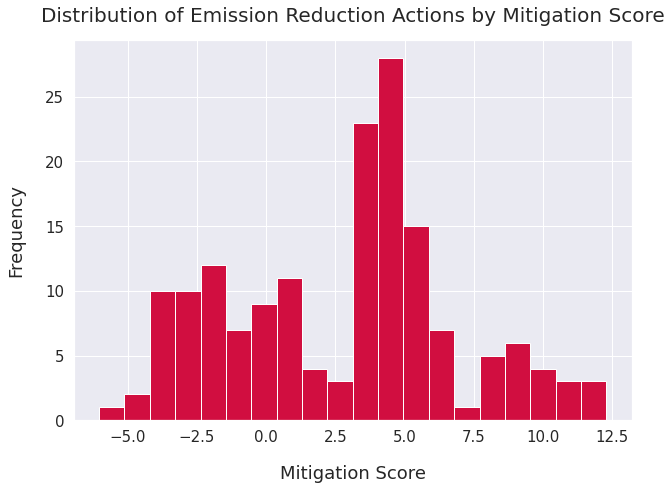

In [50]:
# get city data on emission mitigation actions
piv5_4 = get_cities('5.4', cols=['Country', 'City', 'Account Number']) \
.pivot_table(index=['Country', 'City', 'Account Number', 'Row Number'], columns=['Column Name'],
            aggfunc=lambda x: x.values[0] if len(list(x))==1 else list(x))['Response Answer']

# piv5_4 = piv5_4.join(mitigation_action_opportunity.set_index('Mitigation action'), on='Mitigation action')
# piv5_4.groupby(['City', 'Account Number'])['Opportunity'].count().sort_values(ascending=False)[:30]

# selecting only the rows which are needed
piv5_4 = piv5_4[piv5_4['Timescale of reduction / savings / energy production']=='Projected lifetime'][[
    'Mitigation action', 'Finance status', 'Implementation status', 
    'Estimated emissions reduction (metric tonnes CO2e)', 'Energy savings (MWh)', 
    'Renewable energy production (MWh)', 'Total cost of the project', 
    'Total cost provided by the majority funding source (currency)',
]]

# converting numerical fields to float
for col in piv5_4.columns[3:]:
    piv5_4[col] = piv5_4[col].astype('float32').fillna(0)
    
# remove rows where no data reported for anthing
piv5_4 = piv5_4[~((piv5_4['Estimated emissions reduction (metric tonnes CO2e)']==0)
                 &(piv5_4['Energy savings (MWh)']==0)
                 &(piv5_4['Renewable energy production (MWh)']==0))]
    
# join with currency dataframe to get currency exchange rates
piv5_4 = piv5_4.join(currency)

# converting cost to USD
piv5_4['total cost $'] = piv5_4['Exchange Rate'] * piv5_4['Total cost of the project']

# calculate action score for emission rediction
# 1 MWh => 0.707 metric tonnes CO2e
piv5_4['action_score'] = (np.log10(1 + (0.707 * (piv5_4['Energy savings (MWh)'] + piv5_4['Renewable energy production (MWh)']))) + \
                          np.log10(1 + piv5_4['Estimated emissions reduction (metric tonnes CO2e)']) - 
                          np.log10(1 + piv5_4['total cost $']))

piv5_4['action_count'] = 1
ax = piv5_4['action_score'].plot.hist(bins=20, color=palette[0],
                                 title='Distribution of Emission Reduction Actions by Mitigation Score', figsize=(10,7));
plt.xlabel('Mitigation Score');
# piv5_4.reset_index(inplace=True)
# fig, ax = plt.subplots(figsize=(18, 12)) 
# sns.violinplot(ax=ax, x=piv5_4["CDP Region"], y=piv5_4["action_score"], palette='Reds');

The cumulative average score for the entire set of actions implemented by cities gives us some insight into the efficiency of cities at mitigating emissions. Here, we see how the top scoring cities compare with those that make up the tail end with respect to the _Mitigation Score._

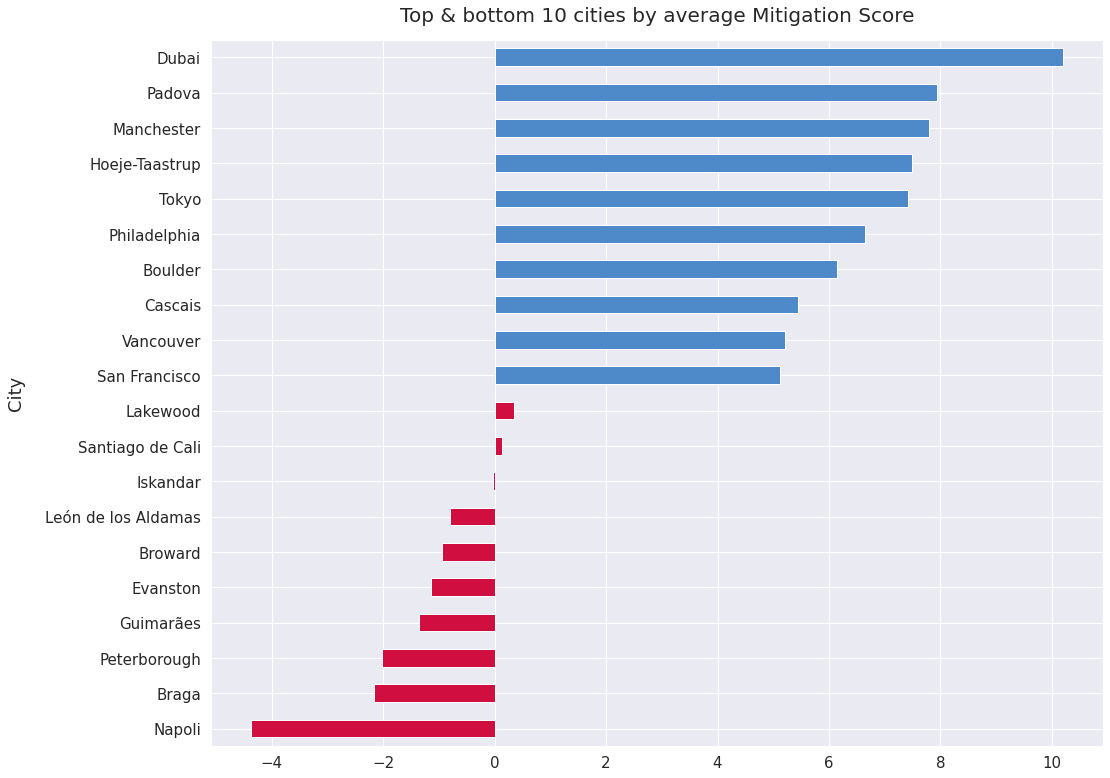

In [51]:
actions = piv5_4.groupby(['Country', 'City', 'Account Number'])[['action_score', 'action_count']].sum()
# calculate average action score
actions['Mitigation Score'] = actions['action_score']/actions['action_count']

# top 20 cities with at least 2 mitigation actions implemented - by average action score
temp = actions[actions['action_count']>1].reset_index().sort_values('Mitigation Score', ascending=False)

pd.concat([temp[:10], temp[-10:]]).plot.barh(x='City', y='Mitigation Score', color=palette[1:2]*10 + palette[:1]*10,
           title='Top & bottom 10 cities by average Mitigation Score', legend=False);
plt.gca().invert_yaxis()

The top half of this chart is primarily populated with cities that happen to be in more developed nations, such as USA, UK, Japan, and Denmark. This shows that it is significantly easier for cities in the developed parts of the world to plan and implement emission reduction projects which perform better over their lifetimes, and therfore the onus should first be on these cities to reduce their carbon footprints.

---

<h3 id="corporate-emissions">7.1.2 Corporate Emissions</h3>

The Corporate Vulnerability section highlighted the negative impact of corporate action on the environment. Diving deeper into these impacts, with the visualization below, we find that the Fossil Fuel and Power Generation industries are, on average, responsible for the greatest amount of CO2e emissions. Given that corporations are accountable for a significant proportion of total worldwide GHG emissions, the responsibility to mitigate climate change and address the social inequality caused by climate hazards should not fall on the shoulders of governments alone.

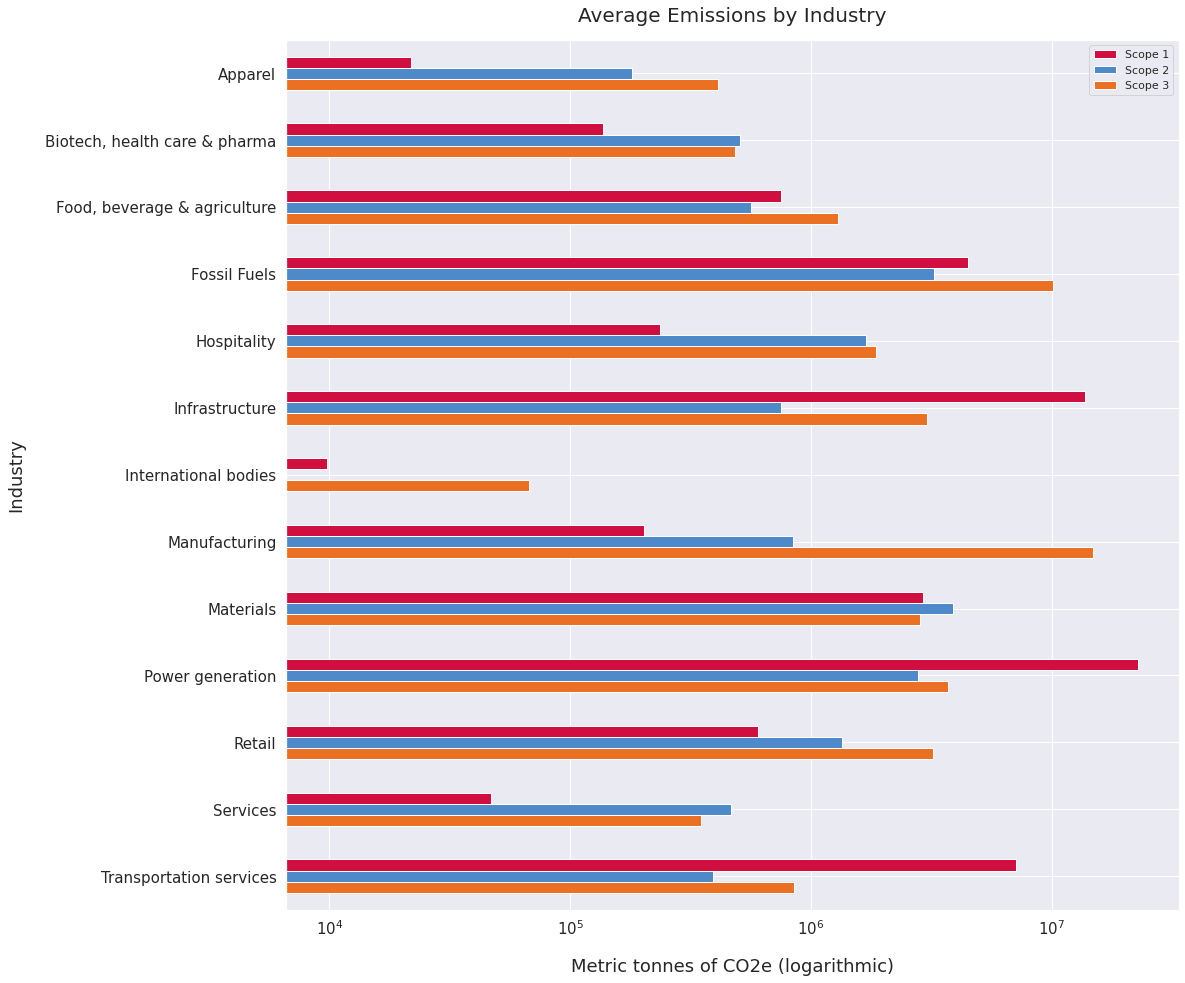

In [52]:
level = 'primary_industry'
# create datarames to store emission data by industry and for organizations
corps_frame = cc_dis.groupby(level)['organization'].count().to_frame()
# emissions_frame = cc_dis.groupby(['organization', 'account_number'])[['primary_sector']].count()

# query scope 1 emission data and calculate mean by industry
cc6_1 = get_climate('C6.1', by='row_name', cols=['country', 'organization',  'account_number', 'primary_industry', 'primary_sector']) \
.pivot(index=['organization', 'account_number', 'primary_industry', 'primary_sector', 'row_name'], columns='column_name')['response_value']
cc6_1['C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)'] = cc6_1['C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)'].astype('float32')

# emissions_frame['Scope 1'] = cc6_1.groupby(['organization', 'account_number'])['C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)'].sum()
corps_frame['Scope 1'] = cc6_1.groupby(level)['C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)'].mean()

cc6_3 = get_climate('C6.3', by='row_name', cols=['country', 'organization',  'account_number', 'primary_industry', 'primary_sector']) \
.pivot(index=['organization', 'account_number', 'primary_industry', 'primary_sector', 'row_name'], columns='column_name')['response_value']

# query scope 3 emission data and calculate mean by industry
cc6_3['C6.3_C1Scope 2, location-based'] = cc6_3['C6.3_C1Scope 2, location-based'].astype('float32')
cc6_3['C6.3_C2Scope 2, market-based (if applicable)'] = cc6_3['C6.3_C2Scope 2, market-based (if applicable)'].astype('float32')
cc6_3['sum'] = cc6_3['C6.3_C1Scope 2, location-based'] + cc6_3['C6.3_C2Scope 2, market-based (if applicable)']

# emissions_frame['Scope 2'] = cc6_3.groupby(['organization', 'account_number'])['sum'].sum()
corps_frame['Scope 2'] = cc6_3.groupby(level)['sum'].mean()

# query scope 3 emission data and calculate mean by industry
cc6_5 = get_climate("C6.5", by='row_name', cols=['country', 'organization',  'account_number', 'primary_industry', 'primary_sector']) \
.pivot(index=['organization', 'account_number', 'primary_industry', 'primary_sector', 'row_name'], columns='column_name')['response_value']['C6.5_C2Metric tonnes CO2e']
cc6_5 = cc6_5.astype('float32')

# emissions_frame['Scope 3'] = cc6_5.groupby(['organization', 'account_number']).sum()
corps_frame['Scope 3'] = cc6_5.groupby(level).mean()

# emissions_frame = emissions_frame[['Scope 1', 'Scope 2', 'Scope 3']]
# emissions_frame['Total Emissions'] = emissions_frame.sum(axis=1)
# plot mean emission data by indusrty
corps_frame.reset_index() \
.plot.barh(x=level, y=['Scope 1', 'Scope 2', 'Scope 3'], figsize=(16,16), color=palette,
           title='Average Emissions by Industry',logx=True, xlabel='Industry');
plt.xlabel('Metric tonnes of CO2e (logarithmic)')
plt.gca().invert_yaxis()

Positive steps taken by corporations to reduce their emissions can play a huge role in meeting the central aim of the Paris Agreement - limiting global temperature rise to below 2 degrees celcius this century. In this section, we provide corporates with a measure to track the efficacy of their emission reduction initiatives in order to facilitate actions that are more efficient and impactful.

---
<strong id="#metric6"><em>Metric 6: Reduction Initiative Score</em></strong>  
_The utility of a corporate emission reduction initiative at reducing CO2 equivalent emissions._  
<br><br>

$\begin{align} ReductionInitiativeScore_{lifetime} & = \log_{10}(1 + AnnualCO_{2}eSavings \times Lifetime) \\ & + \log_{10}(1 + AnnualMonetarySavings \times Lifetime) \\ & - \log_{10}(1 + TotalLifetimeInvestment)\end{align}$
<br><br>

$\begin{align} ReductionInitiativeScore_{annual} & = \log_{10}(1 + AnnualCO_{2}eSavings) \\ & + \log_{10}(1 + AnnualMonetarySavings) \\ & - \log_{10}(1 + TotalLifetimeInvestment/Lifetime), \\ \\ \text{where } \\ & Lifetime \text{ is a score between 0 - 30 based on reported lifetime of initiative} \end{align}$
<br><br>

**Rationale**  
The _Reduction Initiative Score_ performs cost-benefit analysis on the emission reduction initiatives proposed/implemented by corporations. By assessing initiative utility at the lifelime as well as annual periods, it allows for a direct comparison between the immediate and medium/long-term gains expected from implementing the initiatives.

---

In [53]:
# create replacement dict for scoring reported lifetimes
LIFETIME = {'<1 year': 0.5, '1-2 years': 1, '3-5 years': 4, '6-10 years': 8, 'Ongoing': 8,
            '11-15 years': 13, '16-20 years': 18, '21-30 years': 25, '>30 years': 30}

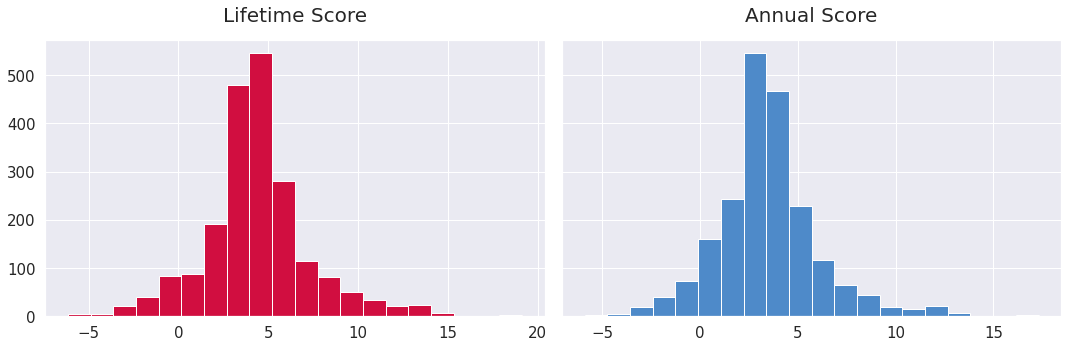

In [54]:
# query corporate data on reduction initiatives
piv4_3b = get_climate('C4.3b').pivot(index=['organization', 'account_number', 'row_number'], columns='column_name')['response_value']

columns = [
    'C4.3b_C1Initiative category & Initiative type_G',
    'C4.3b_C1Initiative category & Initiative type',
    'C4.3b_C8Estimated lifetime of the initiative',
    'C4.3b_C2Estimated annual CO2e savings (metric tonnes CO2e)',
    'C4.3b_C5Annual monetary savings (unit currency â€“ as specified in C0.4)',
    'C4.3b_C6Investment required (unit currency â€“ as specified in C0.4)',
]
# selecting only relevant data to metric calculation
cc4_3b = piv4_3b[columns]
# replacing self defined initiative categories with "Others"
cc4_3b.loc[cc4_3b['C4.3b_C1Initiative category & Initiative type'].str.contains('Other, ', na=False), 'C4.3b_C1Initiative category & Initiative type'] = 'Others'

# converting numerical fields to float
for col in cc4_3b.columns[-3:]:
    cc4_3b[col] = cc4_3b[col].astype('float32')

# join with currency dataframe to get currency exchange rates
cc4_3b = cc4_3b.join(currency_cc)

# converting cost to USD
cc4_3b['savings $'] = cc4_3b['Exchange Rate'] * cc4_3b['C4.3b_C5Annual monetary savings (unit currency â€“ as specified in C0.4)']
cc4_3b['investment $'] = cc4_3b['Exchange Rate'] * cc4_3b['C4.3b_C6Investment required (unit currency â€“ as specified in C0.4)']

# assigning lifetime scores based on replacement dict
cc4_3b['lifetime'] = cc4_3b['C4.3b_C8Estimated lifetime of the initiative'].replace(LIFETIME)

# calculating rediction initiative - lifetime - score
cc4_3b['Lifetime Score'] = np.log10(1+cc4_3b['C4.3b_C2Estimated annual CO2e savings (metric tonnes CO2e)'] * cc4_3b['lifetime']) + \
                           np.log10(1+ cc4_3b['savings $'] * cc4_3b['lifetime']) - \
                           np.log10(1+cc4_3b['investment $'])

# calculating rediction initiative - annual - score
cc4_3b['Annual Score'] = np.log10(1+cc4_3b['C4.3b_C2Estimated annual CO2e savings (metric tonnes CO2e)']) + \
                         np.log10(1+ cc4_3b['savings $']) - \
                         np.log10(1+cc4_3b['investment $']/cc4_3b['lifetime'])

cc4_3b['initiative_count'] = 1
# cc4_3b.sort_values('lifetime_score', ascending=False)[:40]
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
cc4_3b.hist('Lifetime Score', ax=ax[0], color=palette[0], bins=20)
cc4_3b.hist('Annual Score', ax=ax[1], color=palette[1], bins=20);
plt.tight_layout()

The performance of organizations at implementing cost-effective, impactful initiatives can be measured by averaging the scores received on the entirety of their initiatives. The following visualization compares annual and lifetime scores for some of the highest scoring companies. Looking at the corporations that comprise the top 20 by their initiative scores, it is found that a majority are in the energy and transportation industries, with high individual CO2e emissions. This is a positive finding, as it shows that some of the large corporations with massive carbon footprints are taking the right steps to be more climate friendly, but it also lends to the fact that the large emitters have a greater potential for implementing actions to counteract Global Warming.

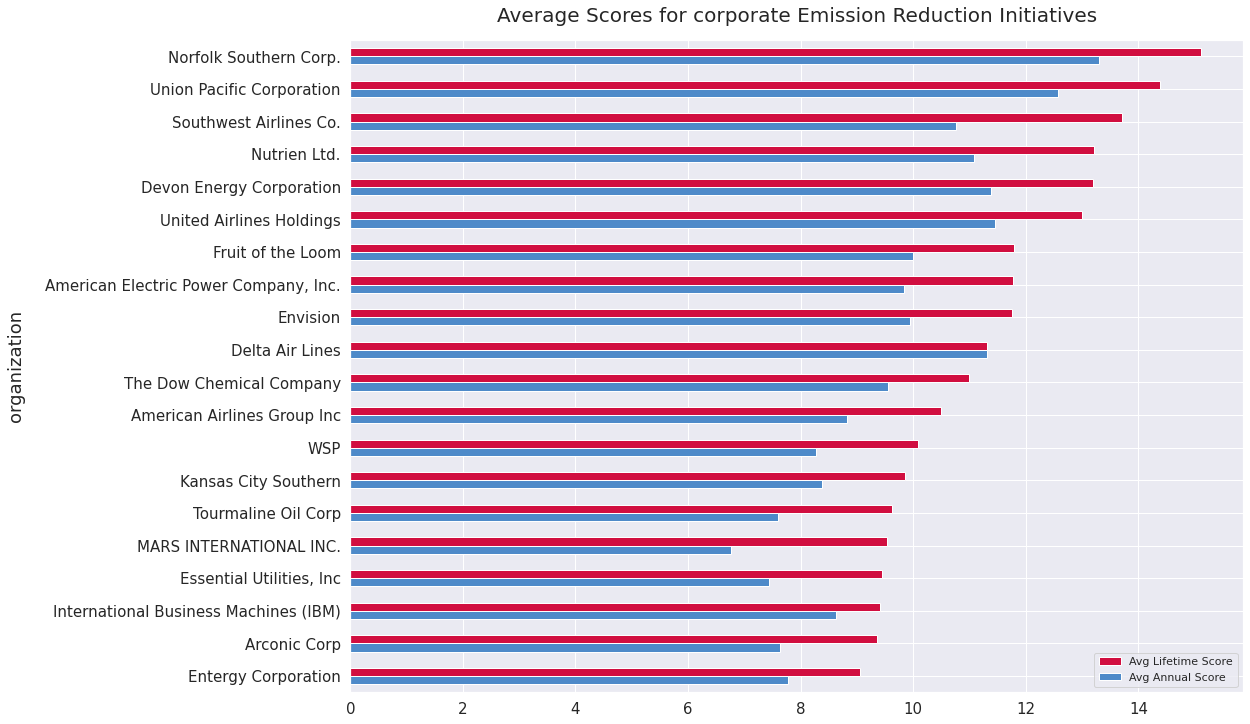

In [55]:
# calculating mean scores at the organization level
initiatives = cc4_3b.groupby(['organization', 'account_number'])[['Lifetime Score', 'Annual Score']].mean()
initiatives.columns = ['Avg Lifetime Score', 'Avg Annual Score']
initiatives['initiative_count'] = cc4_3b.groupby(['organization', 'account_number'])['initiative_count'].sum()

# top 20 organizations by avg lifetime scores on their initiatives
initiatives.reset_index().sort_values('Avg Lifetime Score', ascending=False)[:20] \
.plot.barh(x='organization', y=['Avg Lifetime Score', 'Avg Annual Score'], figsize=(16,12), color=palette[:2],
          title='Average Scores for corporate Emission Reduction Initiatives');
plt.gca().invert_yaxis()



Moreover, we can find the exact kinds of initiatives that perform best, by grouping on the category of the initiative. Here we see that Emission Reduction during Non-energy industrial processes provides the best results in terms of having about average costs and high annual CO2e savings.

In [56]:
initiative_cat = cc4_3b.groupby(['C4.3b_C1Initiative category & Initiative type_G']) \
[columns+['lifetime', 'Annual Score', 'Lifetime Score']].mean().rename_axis('Initiative category')

initiative_cat.columns = ['Avg annual CO2e savings', 'Avg annual monetary savings $', 'Avg lifetime investment $', 'Avg lifetime', 'Avg Annual Score', 'Avg Lifetime Score']

# initiative_cat['Total initiatives'] = cc4_3b.groupby(['C4.3b_C1Initiative category & Initiative type_G'])['initiative_count'].sum()
initiative_cat.round(2).sort_values('Avg Lifetime Score', ascending=False).style.background_gradient('Reds').set_precision(2) \
.set_caption('Comparing Initiatives by Category')

# sns.violinplot(data=cc4_3b, x='lifetime_score', y='C4.3b_C1Initiative category & Initiative type_G')

---
Mitigation of climate change is a crucial step for cities to prosper, but on viewing cities that perform best on their mitigation actions, we notice how developed cities score better. This finding hints at the underlying disparity in the availability of technologies and resources to invest in climate action, and is a reminder of how populations of countries that have contributed the least to global warming are the most vulnerable to the death and diseases brought about by higher temperatures while being the least equipped to tackle them.[<sup>[Link]</sup>](https://www.un.org/en/chronicle/article/health-effects-global-warming-developing-countries-are-most-vulnerable)

Further, tackling climate change can no longer be voluntary for corporates when the emissions they cause play an equally important role in the problem. This is especially striking when you consider that _only_ 100 of all the hundreds of thousands of companies in the world have been responsible for 71% of the global GHG emissions since 1998.[<sup>[Link]</sup>](https://www.activesustainability.com/climate-change/100-companies-responsible-71-ghg-emissions/) 

This recurring theme of inequality in different contexts underlines the need for the large emitters to take bold and immediate action. Applying metrics such as the Lifetime Mitigation and Reduction Initiative scores allows both, cities and corporations, to assess their emission reduction strategies and thereby enable themselves to better counteract the social affects of global warming.

---

<h2 id="energy">7.2 Energy</h2>

<img src="https://i.guim.co.uk/img/media/00599b646cc4bf49445f1c8cc2ceb886109cd291/0_0_2560_1536/master/2560.jpg?width=1020&quality=85&auto=format&fit=max&s=e257bb67e7de4462155ae2e654d98c06" width=800><br>

Illustration by [Sebastien Thibault](https://www.behance.net/sebastienthibault)
<br>

<h3 id="renewable-energy">7.2.1 Renewable Energy</h3>

In the previous section, we saw that the energy sector plays an important role in the severity of climate change due to high levels of GHG emissions. Using more renewable energy can lower the prices of and demand for natural gas and coal by increasing competition and diversifying our energy supplies.[<sup>[Link]</sup>](https://www.ucsusa.org/resources/benefits-renewable-energy-use)

Over the last few years, the greater levels of awareness, cheaper technologies, and concerns regarding our fast heating planet, have resulted in an increasing shift towards renewables. Plotting the data reported by cities provides an idea about the distribution of renewable energy around the world. It is seen that renewable energy capacity is directly correlated with the level of development of the city, existing in orders of magnitude higher quantities in cities in the more developed nations/continents. This intra-city level inequality shows how developing countries will suffer strong climate change impacts due to the lack of technological advances required to increase their transition efforts resilience.

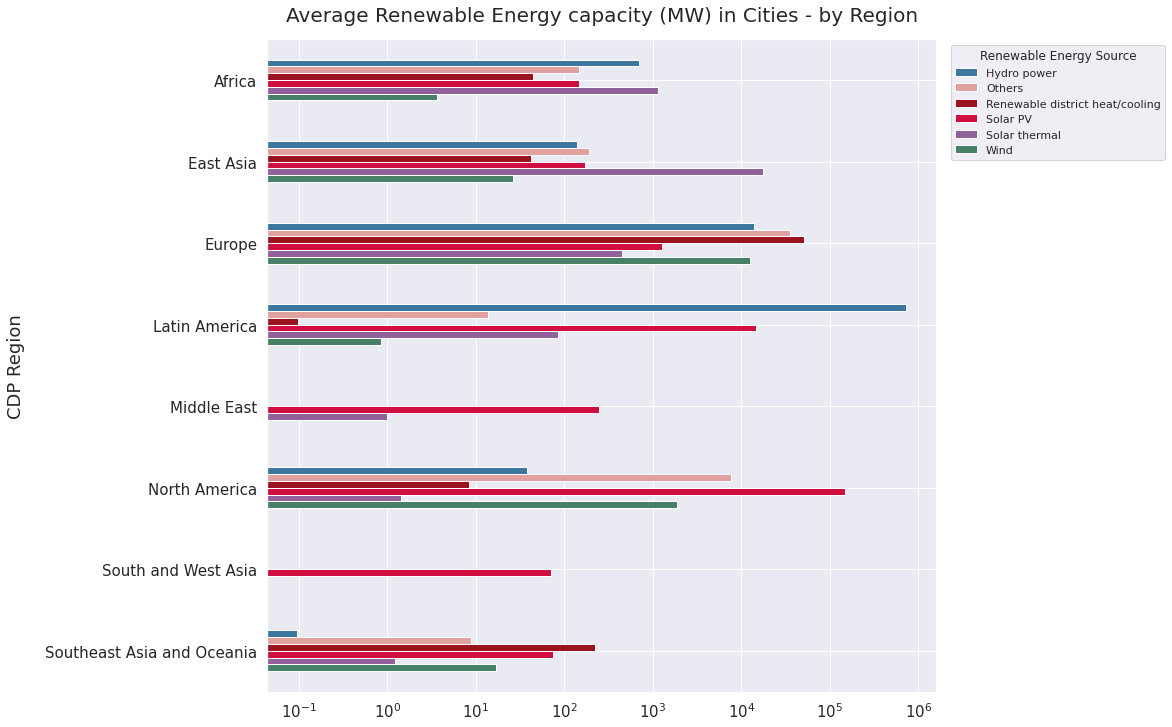

In [57]:
# query city responses on renewable energy capacity (for 2020)
piv8_4 = get_cities('8.4', by='Row Name', cols=CITY_GROUP, country=None) \
.pivot(index=CITY_GROUP + ['Row Name'], columns=['Column Name'])['Response Answer']

piv8_4 = piv8_4.reset_index(4)
piv8_4['Row Name'].replace({'Other, please specify': 'Others'}, inplace=True)

# convert column to float 
piv8_4['MW capacity'] = piv8_4['MW capacity'].astype('float32').fillna(0)

piv8_4.groupby(['CDP Region', 'Row Name'])['MW capacity'].mean().unstack() \
.plot.barh(figsize=(12,12), logx=True, color=[qualitative[i] for i in [1, -1, 3, 0, -5, -3]],
           title='Average Renewable Energy capacity (MW) in Cities - by Region') \
.legend(title='Renewable Energy Source', bbox_to_anchor=(1.35,1));
plt.gca().invert_yaxis()

However, the requirements of cities differ depending on their populations. To get a better understanding of this, we plot city renewable energy capacities alongside city populations, and we see that a majority of the cities having higher than average populations do not even match the _median_ levels of renewable energy capacity.

In [58]:
# join with per capita energy consumption
g8_4 = piv8_4.groupby(['Country', 'City', 'Account Number'])[['MW capacity']].sum() \
.join(energy_use, on='Country', how='inner').join(population, on=['City', 'Account Number']) \

# drop cities with no renewable energy installed
g8_4 = g8_4[g8_4['MW capacity']>0]

# calculate total ciry energy use in MWh
g8_4['estimated city energy use MWh'] = g8_4['Population'] * g8_4['Energy consumption per capita (kWh)']/1000 

# calculate per capita MW capacity
g8_4['MW pc'] = g8_4['MW capacity']/g8_4['Population']

# estimating no. of years from no. of hours in a year (24 * 365) = 8760
g8_4['Demand'] = g8_4['estimated city energy use MWh']/(g8_4['MW capacity'] * 8760)

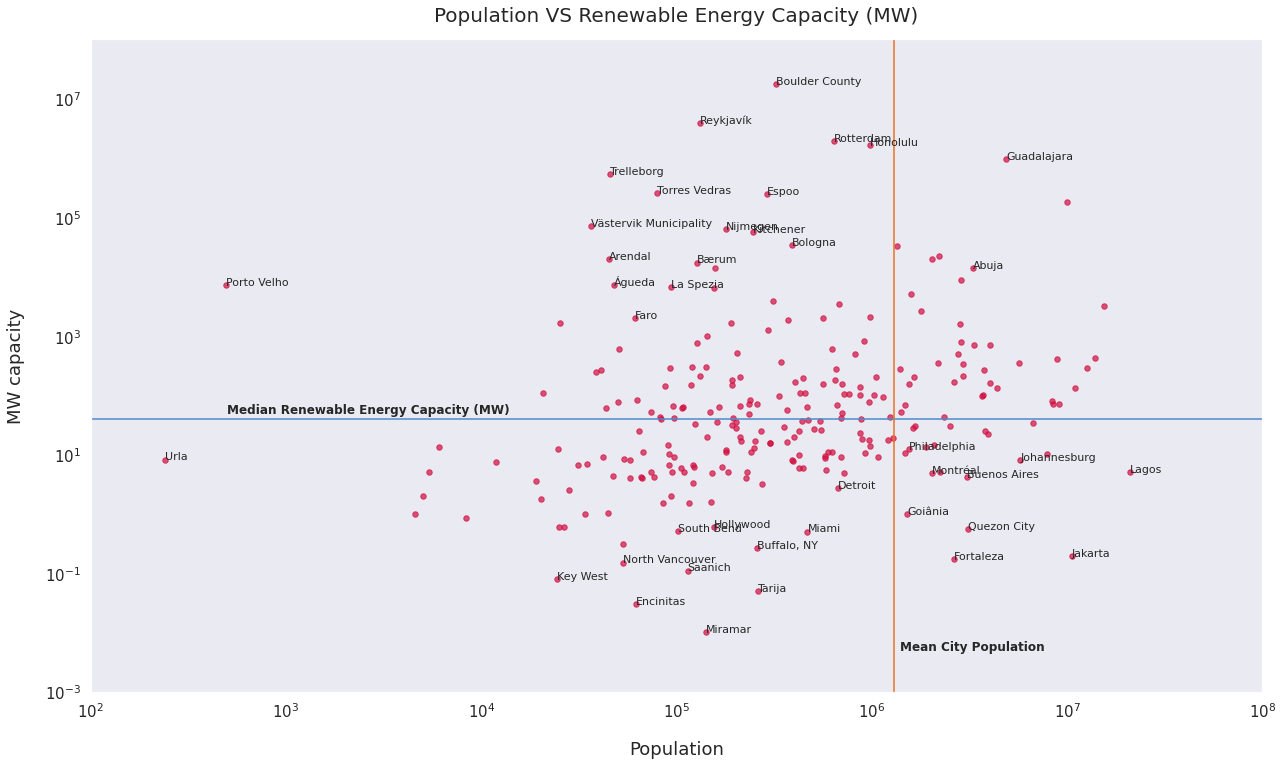

In [59]:
g8_4.sort_values('Demand', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(21, 12))
g8_4.plot.scatter(x='Population', y='MW capacity', color=palette[0],
                     ax=ax, alpha=0.7, s=30, title='Population VS Renewable Energy Capacity (MW)')

meanMW = g8_4['MW capacity'].median()
meanPop = g8_4['Population'].mean()
ax.plot([0,100000000], [meanMW, meanMW], '-',  c=palette[1])
ax.plot([meanPop, meanPop], [0,100000000], '-',  c=palette[2])

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlim([100, 100000000])
plt.ylim([0.001, 100000000])

ax.annotate('Median Renewable Energy Capacity (MW)', (500, 50), fontsize=12, fontweight=550)
ax.annotate('Mean City Population', (1400000, 0.005), fontsize=12, fontweight=550)
for k, v in pd.concat([g8_4[:20], g8_4[-20:]])[['Population', 'MW capacity']].iterrows():
    ax.annotate(k[1], v, fontsize=11)

A way to measure this inadequacy of renewables in cities would be to find a way to compare city capacity the total energy demand, and that brings us to our next metric.

---
<strong id="#metric7"><em>Metric 7: Renewable Energy Public Demand</em></strong>  
_Years of renewable energy generation required, at the current capacity, to meet annual energy demand for a city._
<br><br>

$\begin{align} & Demand_{years} = \frac{TotalEnergyUse_{MWh}}{RenewableEnergyCapacity_{MW} \times 8760}, \\  \\
 \text{where } \\ & TotalEnergyUse_{MWh} = Population_{city} \times PerCapitaEnergyConsumption_{MWh} \\ \\ 
 (8760 & = \text{Number of hours in a year}) \end{align}$
<br><br>

**Rationale**  
A good methodology for cities to evaluate their renewable energy capacity is to calculate how sufficient it would be in, hypothetically, meeting the city's total energy requirements. This metric provides a way to do so by calculating the number of years of operation, at current capacity, required to fulfil the citizenry's annual energy demand.

---

It must be noted that the above calculation is based on the assumption that the per capita energy consumption in cities is the same as the national average. Although, in general, the energy consumption is cities is likely to be higher than rural and suburban areas, [in some cases](https://core.ac.uk/download/pdf/7043741.pdf) this might even be reversed. Due to lack of city-level data for energy consumption, we were forced to work with the national average, however, cities may easily rectify this by substituting the corresponsing city level values in the calculation.

Cities with the lowest performance on this metric have been plotted in the next bar chart. It really says something about city management when your renewable capacity is so low that you need over 120,000 years of it in a given year...

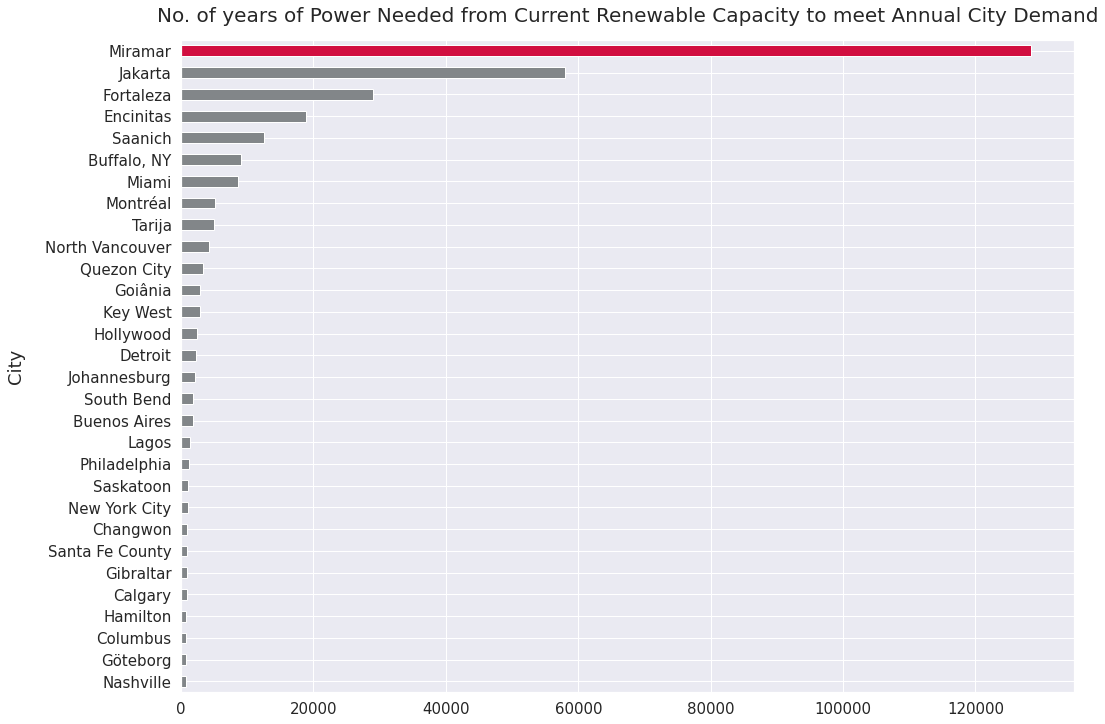

In [60]:
g8_4[:30].reset_index().plot.barh(x='City', y='Demand', figsize=(16,12), legend=False, color=palette[:1] + [grey]*29,
                                 title='No. of years of Power Needed from Current Renewable Capacity to meet Annual City Demand');
plt.gca().invert_yaxis()

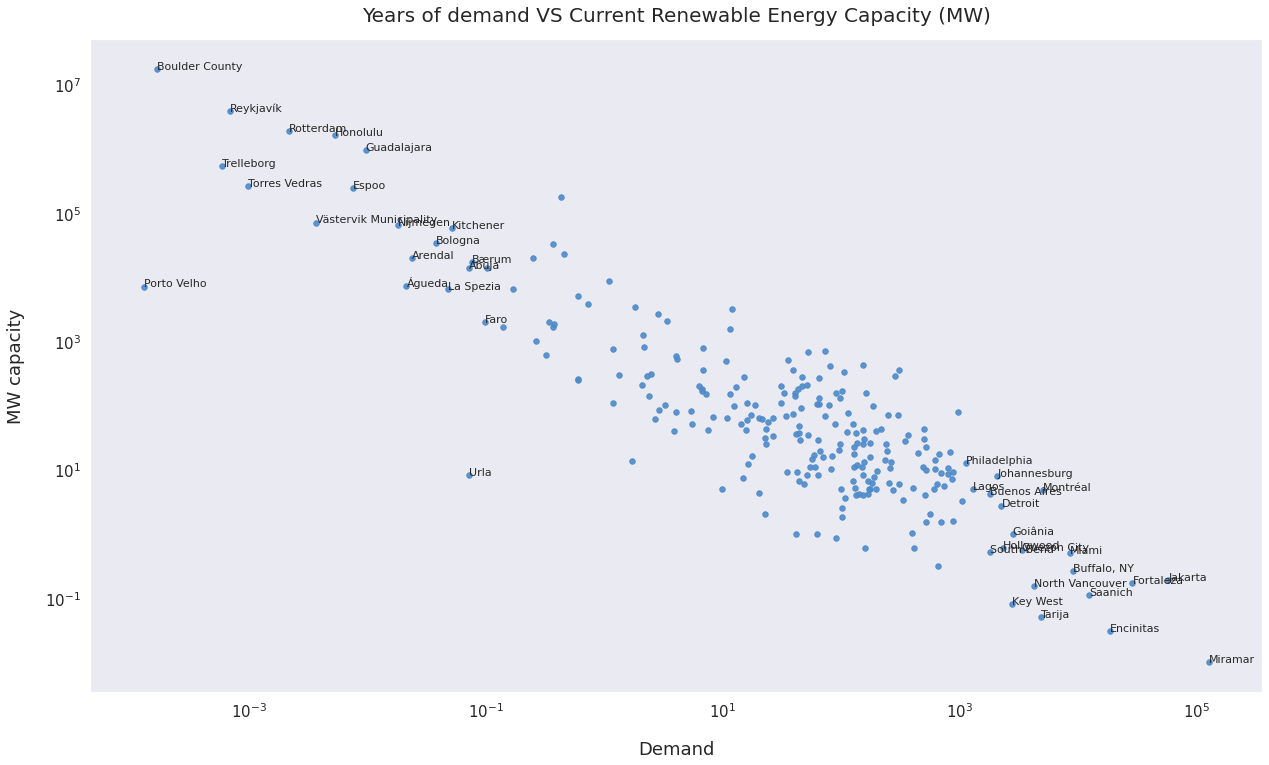

In [61]:
fig, ax = plt.subplots(figsize=(21, 12))
g8_4.plot.scatter(x='Demand', y='MW capacity', color=palette[1],
                     ax=ax, alpha=0.9, s=30, title='Years of demand VS Current Renewable Energy Capacity (MW)')
plt.xscale('log')
plt.yscale('log')
plt.grid()

for k, v in pd.concat([g8_4[:20], g8_4[-20:]])[['Demand', 'MW capacity']].iterrows():
    ax.annotate(k[1], v, fontsize=11)

Comparing energy capacity with the years of energy generation needed to meet annual demands shows an inverse relationship, as expected. However, that the 20 cities at both extremes, by _Demand,_ overlap almost entirely with the extremes by Energy Capacity is an interesting finding as it shows that total energy consumption in cities is **roughly** standard, irrespective of location or population. We see this is true with the following distribution of cities by their estimated total energy consumption, which further implies that cities with lower renewable energy capacities end up sourcing even more of their energy from fossil fuels.

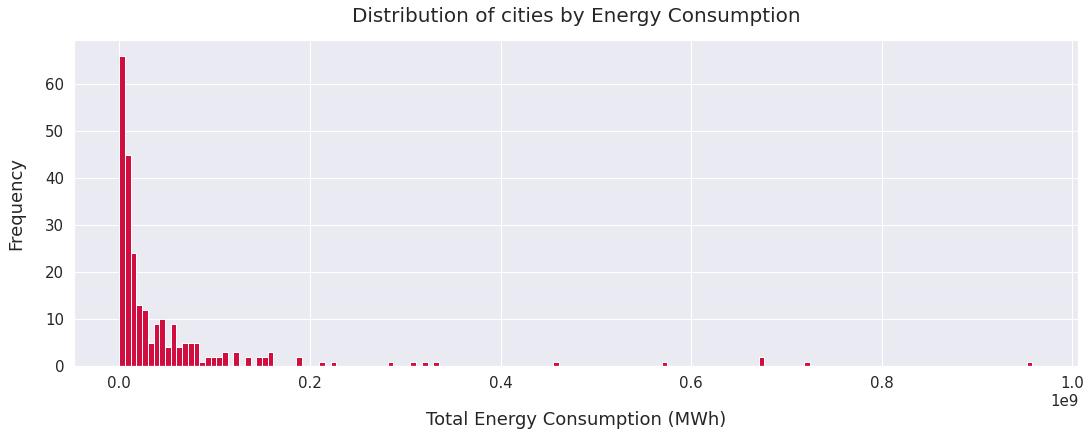

In [62]:
g8_4['estimated city energy use MWh'].plot.hist(bins=160, figsize=(18, 6), color=palette[0],
                                                title='Distribution of cities by Energy Consumption');
plt.xlabel('Total Energy Consumption (MWh)');

Now for the lowest scoring cities (that is with the greatest _Demand),_ we can once more use the GHG emissions calculator and estimate the amount of _additional_ CO2e emissions that could be saved were the city to ramp up its total Renewable Energy capacity to the _median_ of the reported data. 

This calculation assumes that the new sources of energy will be functional year-round, and total energy requirements won't exceed current levels. We have also left out New York City from this, as it already has above median capacity.

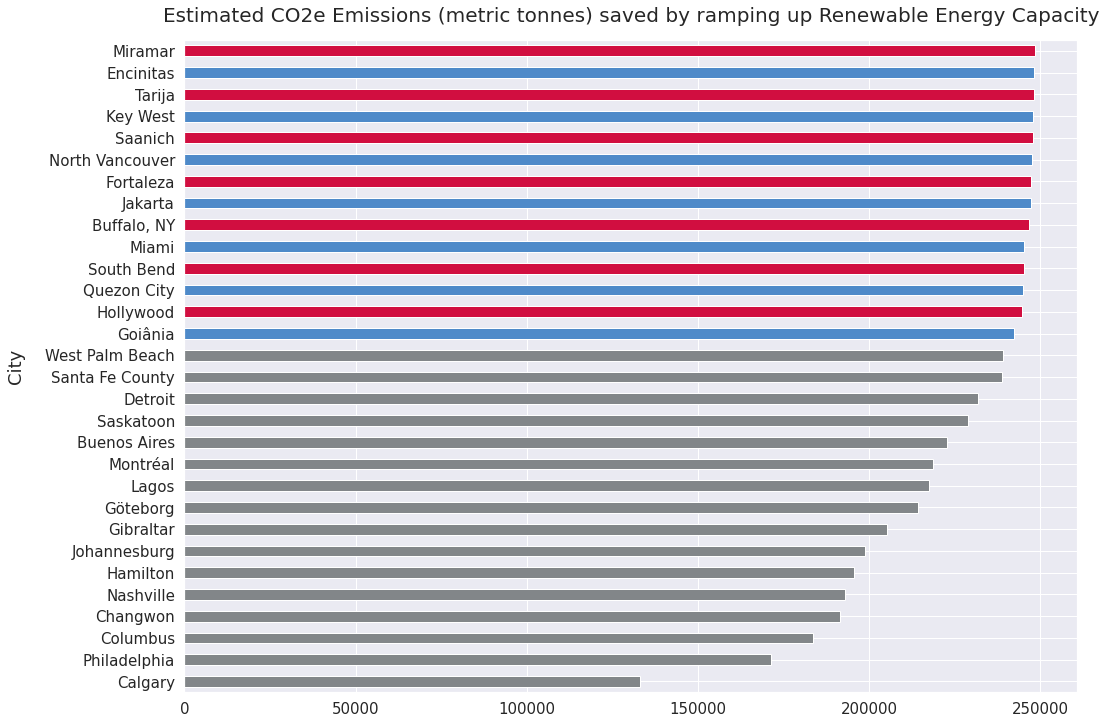

In [63]:
# calculate additional power generation that becomes possible
g8_4['MWh diff'] = (g8_4['MW capacity'].median() - g8_4['MW capacity'])*8760
# calculate whether new capacity overshoots total city demand, in which case select the amount needed to satisfy remaining 
# demand after considering existing capacity
g8_4['New Power'] = g8_4.apply(lambda x: x['MWh diff'] if (x['MWh diff'] + x['MW capacity']*8760)<x['estimated city energy use MWh'] else x['estimated city energy use MWh']-x['MW capacity']*8760, axis=1)
# once more estimating 0.707 metric tonnes per MWh of energy generation
g8_4['Emissions Saved'] = g8_4['New Power'] * 0.707

# select cities with highest demand and then sort on emissions saved
g8_4.drop('New York City', level=1)[:30].sort_values('Emissions Saved').reset_index() \
.plot.barh(x='City', y='Emissions Saved', figsize=(16, 12), legend=False, color=[grey]*16 + palette_r[1:]*7,
           title='Estimated CO2e Emissions (metric tonnes) saved by ramping up Renewable Energy Capacity');

The implications of the results are obvious. A straightforward increase of renewable capacity to 40 MW results in annual emission reductions of approximately 200,000 metric tonnes for each city!

This shows that transition to Renewable Energy has the potential to equip cities with a wide range of opportunities that improve economic, social and environmental conditions. That being said, we must understand the reasons behind cities having low renewable energy. Lack of resources, funding, and technology, in poorer cities, results in them being unable install adequate renewable sources, and instead cities turn to cheap fuels to help with economic growth. But climate change is a global issue and such scenarios require a call for action where the developed countries, whose past emissions have led them to where they are, lend a hand in making renewable energy accessible and available for all. 

Next, let's look at the role of corporations in energy consumption.


<h3 id="corporate-energy-consumption">7.2.2 Corporate Energy Consumption</h3>

Access to energy is fundamental to improving the quality of life and is key for economic development. With the world's demand for electricity set to grow by 85 per cent by 2040 - this increase is more than today's total use of electricity in the USA, the European Union, China, Russia, Japan, Australia and India.[<sup>[Link]</sup>](https://www.theworldcounts.com/challenges/climate-change/energy/global-electricity-consumption/story) An important question we must ask is how much of this electricity use is absolutely necessary, and how much simply the result of availability and lack of awareness. This is because a unique kind of inequality plagues the world, called Energy Poverty, which is the lack of access to modern energy services. 

Energy poor households experience inadequate levels of essential energy services due to a combination of reasons, such as high energy expenditure, low household incomes, inefficient buildings and appliances, and specific household energy needs. It is estimated that more than 50 million households in the European Union alone face Energy Poverty.[<sup>[Link]</sup>](https://www.energypoverty.eu/about/what-energy-poverty)

With this section, we apply the inequality lens to understand the issue of corporate energy overconsumption and the impacts of their fuel use. We start with electricity consumption, and with the next two visualization understand the gap we are trying to address.

In [64]:
# visualizing people without electricity data
fig = px.choropleth(population_with_electricity, locations="Code",
        color="% without access",
        hover_name="Entity",
#         projection="natural earth",
        animation_frame='Year',
#         projection='orthographic',
        color_continuous_scale=px.colors.sequential.OrRd,            
        title='People without electricity (% by country)',
)
fig.update_layout(height=550, margin={"r":0,"t":30,"l":0,"b":0})
fig.update_geos(resolution=110, showcountries=True, countrywidth=0.2, 
                showframe=False, showcoastlines=False)

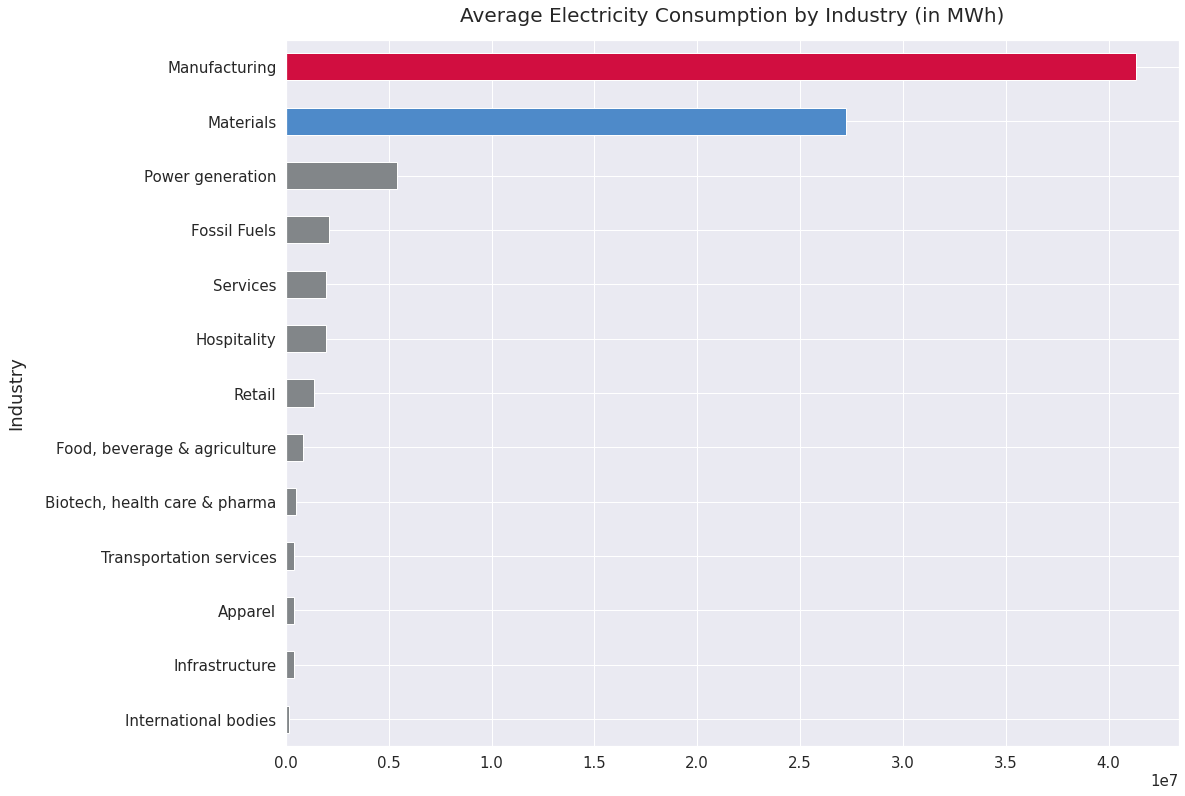

In [65]:
total = 'C8.2a_C4Total (renewable and non-renewable) MWh'

# load corporate energy use data
cc8_2a = get_climate('C8.2a', by='row_name', cols=['country', 'organization', 'account_number', 'primary_industry'])

# selecting rows relevant to electricity consumption and joining with organization revenue, earnings
cc8_2a = cc8_2a[cc8_2a['row_name'] == 'Consumption of purchased or acquired electricity'] \
.pivot(index=['country', 'primary_industry', 'organization', 'account_number', 'row_name'], columns='column_name')['response_value'] \
.dropna(subset=[total]) #.join(cdp_fin_data[['Revenue', 'Operating Income (Loss)']])

# converting to float and dropping corporations with no reported electricity consumption  
cc8_2a[total] = cc8_2a[total].astype('float32')

# adding to corps_frame for industry level visualization
corps_frame['Electricity Consumption (MWh)'] = cc8_2a.groupby('primary_industry')[total].mean()

corps_frame.reset_index().sort_values('Electricity Consumption (MWh)') \
.plot.barh(x='primary_industry', y='Electricity Consumption (MWh)', legend=False, color=[grey]*11+palette_r[1:],
           title='Average Electricity Consumption by Industry (in MWh)', xlabel='Industry'),;

For context, the average human being requires only about 3500 kWh of electricity in an entire year. That is whopping 7 orders of magnitudes lower than the average corporation in the Manufacturing industry. To address this disparity, we come to our next metric.

---
<strong id="#metric8"><em>Metric 8: Corporate Electricity Greed</em></strong>  
_Measure of corporate electricity consumption as a percentage of the global electricity poverty._
<br><br>

$\begin{align} & CorporateElectricityGreed = \frac{Total Electricity Consumption_{MWh}}{GlobalElectricityPoverty} \times 100, \\ \\ \text{where } \\ & GlobalElectricityPoverty = GlobalPerCapitaElectricityConsumption_{MWh} \times PeopleWithoutElectricity \end{align}$

**Rationale**  
Large corporations are amongst the topmost consumers of electricity in the world. But a standard measure of the amount of electricity consumed doesn't give us any more information than the figures of consumption in say MWh. One useful way to hold companies accountable for their electricity use would be to measure their total consumption as a factor of the global electricity poverty which we define as - _the number of MWh of additional electricity needed to provide adequate access to people currently without electricity._ 

---
As such, _Corporate Electricity Greed_ directly draws attention to the divide between the consumerism driven mindsets of large corporations and the resource inadequacy and unavailability for the poorest sections of society. 

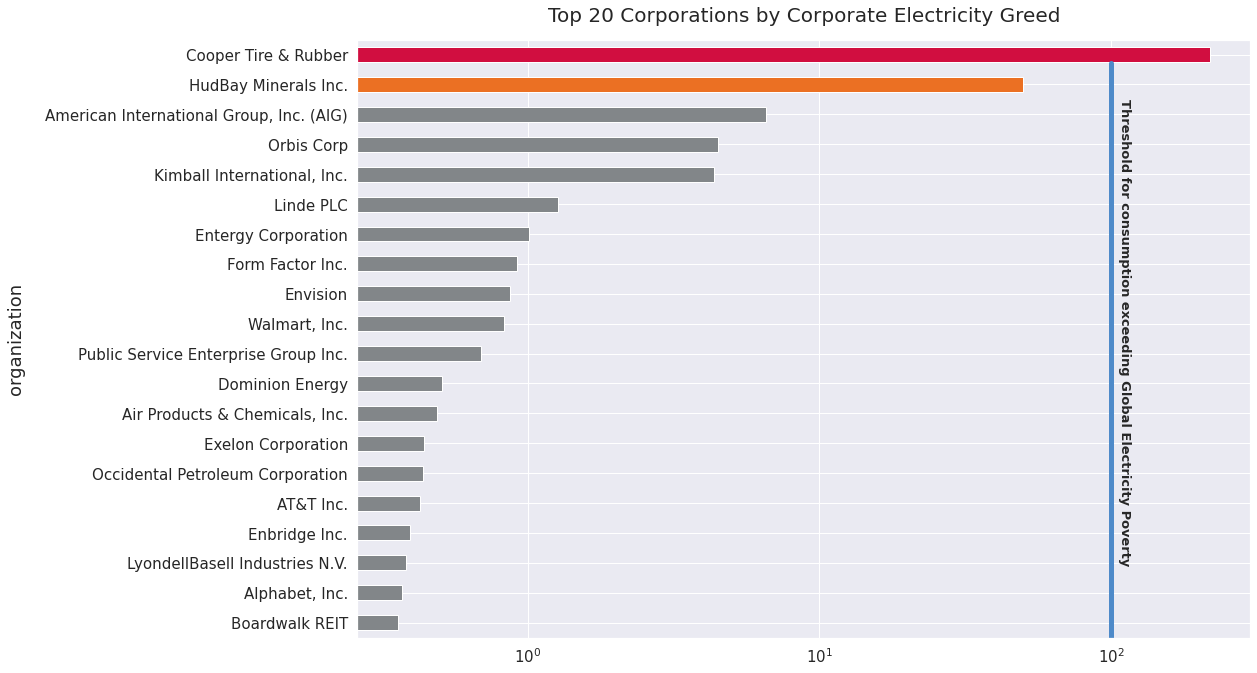

In [66]:
# considering only corporates reporting at least some electricity consumption
cc8_2a = cc8_2a[cc8_2a[total] > 0]

# converting per capita consumption to MWh
per_capita_MWh = global_pc_electricity_consumption['Per capita electricity (kWh)']/1000

# calculating electricity greed by dividing corporate consumption by electricity poverty 
# electricity poverty = global per capita consumption X people without electricity
cc8_2a['Greed'] = cc8_2a[total]*100/(per_capita_MWh * people_without_electricity)

cc8_2a.reset_index().sort_values('Greed', ascending=False)[:20] \
.plot.barh(x='organization', y='Greed', figsize=(16,11), legend=False, color=palette[::2] + [grey]*19,
          title='Top 20 Corporations by Corporate Electricity Greed', logx=True);
plt.plot([100, 100], [0.29, 20], linewidth=5, c=palette[1])
plt.annotate('Threshold for consumption exceeding Global Electricity Poverty', (106, 17), 
             rotation=-90, fontsize=13, fontweight=550)
plt.gca().invert_yaxis()

# cc8_2a[['C8.2a_C2MWh from renewable sources', 'C8.2a_C3MWh from non-renewable sources']] \
# .astype('float32').groupby(['row_name']).sum() \
# .plot(kind='barh', figsize=(8, 6), title='Global energy consumption by organizations by source (2020)');

Visualizing the corporations ranked by electricity greed shows just how vast the divide is, with the top two corporates, Copper Tire & Rubber, and HudBay Minerals Inc., consuming roughly 2x and 0.5x the electricity required to provide enough to every single person who currently lacks it.

In addition to such indirect, comparitive, issues related to consumption, corporate energy activities have even more serious and direct impacts on human health, and that has to do with the fuels they use to fulfil their energy requirements. These will be addressed with the next metric.

---
<strong id="#metric9"><em>Metric 9: Deaths by Corporate Fuel Use</em></strong>  
_Number of deaths casused due to corporations' choice of fuels for energy generation._
<br><br>

$NoOfDeaths = \sum_{i=1}^{fuels}Fuel Consumption(TWh)_{i} \times DeathsPerTWh_{i}$
<br><br>

**Rationale**  
Most of the world's energy continues to be generated by fossil fuels. As per [Markandya, A., & Wilkinson, P. (2007)](https://www.academia.edu/12681524/Electricity_generation_and_health), the use of fossil fuels for energy generation is directly linked to deaths in people due to air pollution related illnesses, or accidents in low visibility conditions. _Deaths by Corporate Fuel Use,_ thereby, provides a means for corporations to assess their impact on human health and safety by enabling them to calculate the number of deaths they might be responsible for due to their energy consumption habits. 

---

The following data on the fuel specific deaths per TWh of energy generated, is sourced from [Our World In Data](https://ourworldindata.org/grapher/death-rates-from-energy-production-per-twh), who themselves partially sourced it from the document linked above.

In [67]:
# avg. deaths per TWh of energy generation 
# https://ourworldindata.org/grapher/death-rates-from-energy-production-per-twh
fuel_deaths = pd.DataFrame([
    ('Biofuels', 0.0048),
    ('Biomass', 4.63),
    ('Brown coal', 32.72),
    ('Coal', 24.62),
    ('Gas', 2.821),
    ('Hydropower', 0.0235),
    ('Nuclear', 0.071),
    ('Oil', 18.43),
    ('Solar', 0.019),
    ('Wind', 0.035)
], columns=['Fuel Category', 'Deaths per TWh'])

fuel_deaths.style.background_gradient(cmap='Reds')

In [68]:
# mapping top fuels (by use) from CDP Questionnare Responses to the above given categories
FUELS = pd.DataFrame([
    ('Biogas', 'Biofuels'),
    ('Biomethane', 'Biofuels'),
    ('Bioethanol', 'Biofuels'),
    ('Biodiesel', 'Biofuels'),
    ('Biodiesel Tallow', 'Biofuels'),
    ('Biodiesel Waste Cooking Oil', 'Biofuels'),
    ('Bamboo', 'Biofuels'),
    ('Black Liquor', 'Biofuels'),
    ('Vegetable Oil', 'Biofuels'),
    ('Animal Fat', 'Biofuels'),
    ('Hardwood', 'Biofuels'),
    ('Softwood', 'Biofuels'),
    ('Wood', 'Biofuels'),
    ('Wood Logs', 'Biofuels'),
    ('Bagasse', 'Biofuels'),
    ('Liquid Biofuel', 'Biofuels'),
    ('Straw', 'Biofuels'),
    ('Biogasoline', 'Biomass'),
    ('Solid Biomass Waste', 'Biomass'),
    ('Biomass Municipal Waste', 'Biomass'),
    ('Dried Sewage Sludge', 'Biomass'),
    ('Sludge Gas', 'Biomass'),
    ('Wood Pellets', 'Biomass'),
    ('Wood Chips', 'Biomass'),
    ('Wood Waste', 'Biomass'),
    ('Agricultural Waste', 'Biomass'),
    ('General Municipal Waste', 'Biomass'),
    ('Lignite Coal', 'Brown coal'),
    ('Brown Coal Briquettes (BKB)', 'Brown Coal'),
    ('Coal', 'Coal'),
    ('GCI Coal', 'Coal'),
    ('PCI Coal', 'Coal'),
    ('Coke', 'Coal'),
    ('Subbituminous Coal', 'Coal'),
    ('Thermal Coal', 'Coal'),
    ('Thermal Coal Commercial', 'Coal'),
    ('Thermal Coal Domestic', 'Coal'),
    ('Thermal Coal Industrial', 'Coal'),
    ('Anthracite Coal', 'Coal'),
    ('Bituminous Coal', 'Coal'),
    ('Coking Coal', 'Coal'),
    ('Metallurgical Coal', 'Coal'),
    ('Natural Gas', 'Gas'),
    ('Natural Gas Liquids (NGL)', 'Gas'),
    ('Natural Gasoline', 'Gas'),
    ('Liquefied Natural Gas (LNG)', 'Gas'),
    ('Compressed Natural Gas (CNG)', 'Gas'),
    ('Fuel Gas', 'Gas'),
    ('Crude Oil', 'Oil'),
    ('Crude Oil Extra Heavy', 'Oil'),
    ('Crude Oil Heavy', 'Oil'),
    ('Crude Oil Light', 'Oil'),
    ('Marine Fuel Oil', 'Oil'),
    ('Light Distillate', 'Oil'),
    ('Refinery Oil', 'Oil'),
    ('Petroleum Coke', 'Oil'),
    ('Petrol', 'Oil'),
    ('Diesel', 'Oil'),
    ('Motor Gasoline', 'Oil'),
    ('Aviation Gasoline', 'Oil'),
    ('Jet Gasoline', 'Oil'),
    ('Jet Kerosene', 'Oil'),
    ('Residual Fuel Oil', 'Oil'),
    ('Distillate Oil', 'Oil'),
    ('Fuel Oil Number 1', 'Oil'),
    ('Fuel Oil Number 2', 'Oil'),
    ('Fuel Oil Number 4', 'Oil'),
    ('Fuel Oil Number 5', 'Oil'),
    ('Fuel Oil Number 6', 'Oil'),
    ('Fuel Oil', 'Oil')
], columns=['Fuel', 'Fuel Category'])

Using a mapping between the fuel types present in this data and the list of fuels provided in the CDP questionnaire, we can estimate the death rates for each fuel used by the corporation. Next, joining the mapping with corporate responses for fuels used in energy generation, lets us calculate the death tolls for each corporation.

In [69]:
# query corporate fuel use data
cc8_2c = get_climate('C8.2c').pivot(index=['organization', 'row_number'], columns='column_name')['response_value']

# convert from MWh to TWh
cc8_2c['TWh of fuel consumed'] = (cc8_2c['C8.2c_C3Total fuel MWh consumed by the organization'].astype('float64'))/1000000
cc8_2c = cc8_2c[cc8_2c['TWh of fuel consumed']!=0]

# join (via fuel category mapping) with fuel deaths dataframe
cc8_2c = cc8_2c[['C8.2c_C1Fuels (excluding feedstocks)', 'TWh of fuel consumed']] \
.join(FUELS.set_index('Fuel'), on='C8.2c_C1Fuels (excluding feedstocks)') \
.join(fuel_deaths.set_index('Fuel Category'), on='Fuel Category') \
.dropna(subset=['Fuel Category', 'TWh of fuel consumed'])

# calculate number of deaths
cc8_2c['Deaths'] = cc8_2c['TWh of fuel consumed'] * cc8_2c['Deaths per TWh']

cc8_2c.groupby('organization')[['Deaths']].sum().round().astype('int32'). \
sort_values('Deaths', ascending=False)[:20].style.background_gradient(cmap='Reds') \
.set_caption('Number of (annual) deaths caused by corporate fuel use')

# ccpiv8_2c.groupby(['organization', 'C8.2c_C1Fuels (excluding feedstocks)'])['C8.2c_C3Total fuel MWh consumed by the organization'].sum() \
# .sort_values(ascending=False)[:120].unstack() \
# .plot(kind='barh', stacked=True, figsize=(10,14), cmap='tab20', title='Breakdown of fuels consumption in MWh by organizations (2020)');

Just like we saw in the Emissions section, the top culprits are corporations utilizing large quantities of fossil-fuels for energy generation and transportation.

___

With nearly a billion people still without access to electricity in the developing world, the sheer scale of corporate energy consumption makes them come off as extremely complicit. Meanwhile, in energy poor areas, besides the obvious hardships, the use of dirty or polluting fuels has serious consequences on people’s health and wellbeing by exacerbating respiratory and cardiac illnesses, and mental health issues.

Further, by calculating _Deaths by Fuel Use,_ we discover the magnitude of corporate impact on people's lives due large scale corporate fossil-fuel consumption. The number of people affected by the activities of corporations such as Vistra Corp., Duke Energy and American Electric Power Company, shows the toxic nature of the corporations that value profits over life. 

In view of all of this, we advocate that corporations need to take yet more notice of the extended consequences of their actions, and take steps to address the energy access problem. This is not only the right thing to do, but also opens doors to opportunities. For example, The World Bank’s International Finance Corporation (IFC) recently estimated the market size for modern energy services at US$37 billion – roughly equivalent to the amount those without access today spend on kerosene for lighting and biomass for cooking. In addition to the direct revenue opportunities providing access to energy bring, the domino effects - namely broader economic and socio-economic development - can lead to yet more opportunities.[<sup>[Link]</sup>](https://accntu.re/33rApI0)


<h2 id="water-risks">7.3 Water Risks</h2>

<img src="https://i.pinimg.com/750x/0d/fd/51/0dfd512f7fb956eacbdf20afefe147ce.jpg">

Illustration by [Sebastien Thibault](https://www.behance.net/sebastienthibault)
<br>

<h3 id="water-costs-of-electricity">7.3.1 Hidden Water Costs of Electricity</h3>

There have been numerous reports in the past year that talk about the depleting water sources, rising droughts and future water shortages to be faced by the world. However, overall action in safeguarding this dwindling resource is falling far short, and according to CDP,[<sup>[Link]</sup>](https://www.reutersevents.com/sustainability/global-water-crisis-looms-business-usual-no-longer-option) there has been a 50% rise in companies reporting higher water withdrawals since 2015.

Corporations need to take more ambitious steps in order to counteract the impact they have on the planet's water resources, and it isn't just the social and environmental impacts of unsustainable water use that should drive companies to act. Water-related financial losses are rising. In 2018, companies reported such losses to the tune of $38 billion, and even after excluding the top 2 contributors, losses were still higher than in 2017.[<sup>[Link]</sup>](https://www.ipcc.ch/sr15/chapter/chapter-3/) Through this section, we aim to develop a metric that can be used as a mitigative tool for corporations to track the water consumed for electricity generation.

---
<strong id="#metric10"><em>Metric 10: Water Cost of Electricity</em></strong>  
_Gallons of upstream water consumed for purposes relating to the generation of electricity._
<br><br>

$$\begin{align} & Water Cost_{gallons} = \sum_{i=1}^{fuels}ElectricityConsumed(kWh)_{i} \times WaterConsumptionFactor_{i}, \\ 
 \text{where, } \\
&WaterConsumptionFactor_{i} = \text{Gallons of water consumed per kWh electrcity from fuel }i \end{align} $$
<br><br>

**Rationale**  
Freshwater use for electricity generation accounts for a large proportion of total water consumption across the world. At the same time, the world is not on track to meet SDG 6 - securing water and sanitation for all by 2030, with 1 in 3 people globally without access to safe drinking water.[<sup>[Link]</sup>](https://www.unicef.org.uk/press-releases/1-in-3-people-globally-do-not-have-access-to-safe-drinking-water-unicef-who/#:~:text=It%20is%20estimated%20that%201,who%20drink%20untreated%20surface%20water) The _Water Cost of Electricity_ allows us to measure the hidden upstream water consumption related to energy generation and use by corporations which may otherwise be used to satisfy the basic water-related needs of people.
    
---

Data on the Water Consumption Factor for fuels is sourced from WRI. Their approach and calculations for the factor score are described in [Guidance for Calculating Water Use Embedded in Purchased Electricity](https://www.wri.org/publication/guidance-calculating-water-use-embedded-purchased-electricity). Since CDP has provided response data only for organizations in the USA and Canada, water consumption factor values for these 2 countries are all that we will need. These are displayed in the table given below.

In [70]:
water_factor.unstack()['Water Consumption Factor'].drop(['Geothermal', 'Hydro', 'Nuclear', 'Photovoltaics', 'Solar Thermal', 'Wind'], axis=1) \
.style.background_gradient('OrRd', axis=1).set_caption('Water Consumption Factor for Fuels (gal/kWh)').set_precision(3)

To use the water factor values, we must once again create a mapping between the dataset and the responses. Although all fuels from the CDP Questionnaire are not listed in the water factor dataset, we can make some assumptions in order to map them to the most similar fuels.

For example, Bituminous and Subbituminous coal have similar calorific content compared to Hard Coal (Anthracite), and hence, would result in a similar water consumption factor.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Coal_Rank_USGS.png/1024px-Coal_Rank_USGS.png" alt="Coal Caloric Value" width="400"/>

<br><br>

In some of the other cases, we map high-grade derivatives of a fuel to the fuel itself (Natural Gas) with the assumption that derivatives would, in general, have a higher water factor than the raw fuel. The mapping now allows us to calculate our metric. Plotting the top 20 corporations by embedded water consumption shows that the group consists almost exclusively of energy generation companies, which makes a lot of sense.

In [71]:
# mapping fuels from CDP questionnare to fuels provided in water consumption factor dataset
FUELS2 = pd.DataFrame([
    ('Anthracite Coal', 'Hard Coal'),
    ('Bituminous Coal', 'Hard Coal'),
    ('Subbituminous Coal', 'Hard Coal'),
    ('Coal', 'Hard Coal'),
    ('Lignite Coal', 'Lignite'),
    ('Peat', 'Peat'),
    ('Natural Gas', 'Natural Gas'),
    ('Fuel Gas', 'Natural Gas'),
    ('Natural Gas Liquids (NGL)', 'Natural Gas'),
    ('Natural Gasoline', 'Natural Gas'),
    ('Liquefied Natural Gas (LNG)', 'Natural Gas'),
    ('Compressed Natural Gas (CNG)', 'Natural Gas'),
    ('Solid Biomass Waste', 'Biomass'),
    ('Biomass Municipal Waste', 'Biomass'),
    ('Dried Sewage Sludge', 'Biomass'),
    ('Sludge Gas', 'Biomass'),
    ('Wood Pellets', 'Biomass'),
    ('Wood Chips', 'Biomass'),
    ('Wood Waste', 'Biomass'),
    ('Agricultural Waste', 'Biomass'),
    ('Hardwood', 'Biomass'),
    ('Softwood', 'Biomass'),
    ('Wood', 'Biomass'),
    ('Wood Logs', 'Biomass'),
    ('Straw', 'Biomass'),
    ('Wood', 'Biomass'),
    ('Wood Waste', 'Biomass'),
    ('Landfill Gas', 'Biogas'),
    ('Biogas', 'Biogas'),
    ('Biomethane', 'Biogas'),
    ('General Municipal Waste', 'Waste'),
    ('Waste Tires', 'Waste'),
    ('Industrial Wastes', 'Waste'),
    ('Non-Biomass Municipal Waste', 'Waste'),
    ('Non-Biomass Waste', 'Waste'),
    ('Waste Paper and Card', 'Waste'),
    ('Waste Plastics', 'Waste'),
    ('Residual Fuel Oil', 'Heavy Fuel Oil'),
    ('Town Gas', 'Coal Gases')
], columns=['Fuel', 'Fuel Type'])

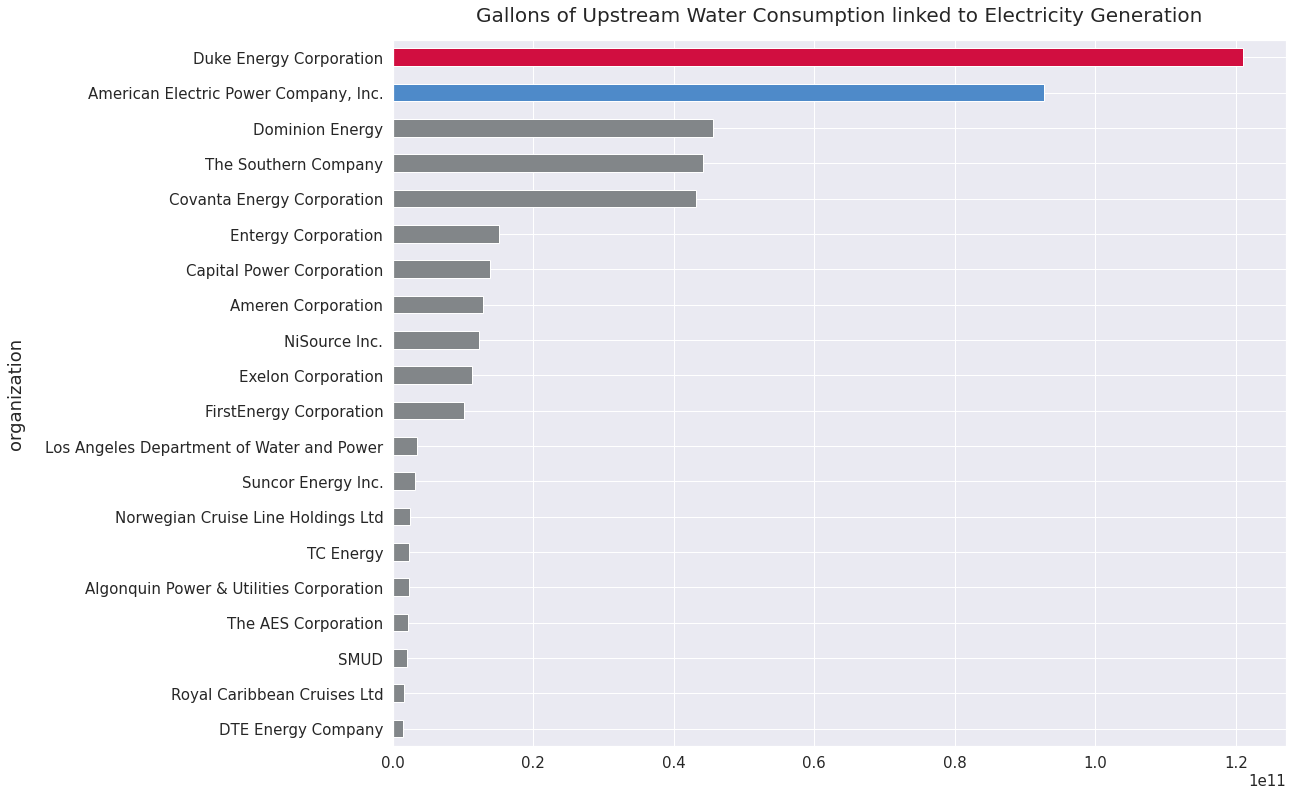

In [72]:
# query corporate fuel use data again
cc8_2c = get_climate('C8.2c', cols=['country', 'organization']) \
.pivot(index=['country', 'organization', 'row_number'], columns='column_name')['response_value']

# convert electricity consumption from MWh to KWh
cc8_2c['kWh of electricity generation'] = cc8_2c['C8.2c_C4MWh fuel consumed for self-generation of electricity'].astype('float64') * 1000
cc8_2c = cc8_2c[cc8_2c['kWh of electricity generation']!=0]

# join with fuel type mapping above 
cc8_2c = cc8_2c[['C8.2c_C1Fuels (excluding feedstocks)', 'kWh of electricity generation']] \
.join(FUELS2.set_index('Fuel'), on='C8.2c_C1Fuels (excluding feedstocks)').dropna(subset=['Fuel Type', 'kWh of electricity generation']) \
.reset_index().set_index(['country', 'Fuel Type'])

# add water factor data for each fuel
cc8_2c['water_factor'] = water_factor['Water Consumption Factor']

# calculate gallons consumed for electricity generation
cc8_2c['gallons'] = cc8_2c['kWh of electricity generation'] * cc8_2c['water_factor']

cc8_2c.groupby(['organization'])['gallons'].sum().sort_values(ascending=False)[:20] \
.plot.barh(color=palette[:2] + [grey]*18,
           title='Gallons of Upstream Water Consumption linked to Electricity Generation');
plt.gca().invert_yaxis()

It must be noted that these results are somewhat incomplete. Even though we have tried our best to include a majority of the fuels from the CDP Questionnaire, all haven't been accounted for. Sadly, there was no way around this as the WRI data was the best we could find to calculate embedded water consumption in energy use. 

On the plus side, despite of the gap in the data, the KPI does well to highlight just how integral water is to electricity generation. Moreover, it could be applied to calculate hidden water costs for organization facilities located near stressed water resources and generating their own electricity. We would have done this ourselves, using the responses to question `W5.1` of the Water Security Questionnaire, however, there wasn't any data on the total amount of electricity generated/consumed by the facilities. Maybe the 2021 Questionnaire could add this field! :)

<h3 id="water-stress">7.3.2 Water Stress</h3>

<img src="https://files.wri.org/s3fs-public/styles/large/public/aqueduct_projections_20150409.png?itok=WISZGyCc"> 

Image from [WRI](https://www.wri.org/)
<br>

Water is a ubiquitous resource. However, massive quantities of it are consumed by multinational corporates to sustain the global scale of their operations. It is, therefore, to be expected that some, if not all, of this water is sourced from water-stressed regions. These may be overstressed river basins, or countries facing issues related to water scarcity at the national level. Due to this, it becomes essential for corporations to account for the level of their water consumption from stressed regions or resources.

We can use the responses provided by organizations, to visualize their facilities by their total water consumption in stressed and non-stressed regions - as reported by them.

In [73]:
# using w, c, d for withdrawn, consumption, discharge respectively
w = 'Total water withdrawals at this facility (megaliters/year)'
c = 'Total water consumption at this facility (megaliters/year)'
d = 'Total water discharges at this facility (megaliters/year)'

# querying corporate responses for water accounting data
w5_1 = get_water('W5.1').pivot(index=['organization', 'account_number', 'row_number'], columns='column_name')['response_value']
w5_1 = w5_1[[
    'W5.1_C3Country/Area & River basin_G', 'W5.1_C3Country/Area & River basin', 
    'W5.1_C6Located in area with water stress', 'W5.1_C4Latitude', 'W5.1_C5Longitude',
    'W5.1_C9' + w, 'W5.1_C23' + c, 'W5.1_C17' + d
]]

# renaming columns to look nice on visualizations
w5_1.columns= [
    'Country/Area',
    'River basin',
    'Water Stressed Area',
    'Latitude',
    'Longitude',
    w, c, d
]

w5_1['Water Stressed Area'] = w5_1['Water Stressed Area'].fillna('Unknown')

for col in w5_1.columns[3:]:
    w5_1[col] = w5_1[col].astype('float32')

In [74]:
w5_1c = w5_1[w5_1[c]>0]

# size of plot in figure is a function of water consumption
w5_1c['size'] = np.log10(1 + w5_1c[c])

# visualizing facilites by their consumption and water stress
fig =  px.scatter_geo(w5_1c, lat='Latitude',
               lon='Longitude', 
               color='Water Stressed Area',
               hover_data=[w, c, 'Country/Area', 'River basin'],
#                projection="natural earth",        
               size='size',
               size_max=12,
               color_discrete_sequence=palette[:2] + [grey],
               title='Self reported water consumption by facilities from stressed/non stressed water resources',
)
fig.update_layout(height=480, margin={"r":0,"t":30,"l":0,"b":0})
fig.update_geos(resolution=50, showcountries=True, countrywidth=0.2, showrivers=True, showlakes=True, 
                showframe=False, showcoastlines=False, rivercolor='#97B9DD')

Given that a majority of these facilities are located in water stressed regions, we present a way for corporations to evaluate their water consumption.

---
<strong id="#metric11"><em>Metric 11: Unsustainable Water Use</em></strong>  
_Measure of water consumption from water-stressed regions and resources._
<br><br>

$$UnsustainableWaterUse_{riverBasins} = \sum_{i=1}^{facilites}(WaterStressScore_{riverBasin_{i}} \times \log_{10}(1 + WaterConsumption_{i}))$$
<br><br>
$$UnsustainableWaterUse_{countries} = \sum_{i=1}^{facilites}(WaterStressScore_{country_{i}} \times \log_{10}(1 + WaterConsumption_{i}))$$
<br><br>

**Rationale**
_Unsustainable Water Use_ takes into consideration the water stress at the river basin and country level for each facility belonging to a corporation, and assigns a pair of scores to the company tied to their total consumption from all facilities. 

---

The water stress scores for the largest, most populous river basins, and for all of the countries are available on WRI as part of their [Aqueduct Country and River Basin Rankings](https://www.wri.org/resources/data-sets/aqueduct-country-and-river-basin-rankings). We use this data to first visualize water stress at the country level.

In [75]:
# load water stress data for river basins, countries
water_stress_basin = pd.read_csv('../input/aqueduct-baseline-water-stress-20132014/aqueduct_basins_baseline_water_stress_20131024.csv').set_index('Name')

water_stress_country = pd.read_csv('../input/aqueduct-baseline-water-stress-20132014/aqueduct_countries_baseline_water_stress_20140109.csv') \
.set_index('Name').replace('-', np.nan).astype('float32')
# add iso codes to country water stress data
water_stress_country = water_stress_country.join(iso_country, on='Name')[['All sectors', 'alpha-3']]

In [76]:
# visualize baseline water stress country level data
fig_c = px.choropleth(water_stress_country.reset_index(), locations="alpha-3",
        color="All sectors", # lifeExp is a column of gapminder
        hover_name="Name", # column to add to hover information
#         projection="natural earth",
#         projection='orthographic',
        color_continuous_scale=px.colors.sequential.Reds,            
        title='Baseline water stress at country level',
)
fig_c.update_layout(height=480, margin={"r":0,"t":30,"l":0,"b":0})
fig_c.update_geos(resolution=50, showcountries=True, countrywidth=0.2, showrivers=True, showlakes=True,
                showframe=False, showcoastlines=False,  rivercolor='#97B9DD')

It can be seen that large swathes of the world are facing high levels of water stress, and barring Central Africa and parts of South America, all continents have above-median baseline water stress scores. These scores will be used as weights for calculating each facilities' contribution towards the corporation's _Unsustainable Water Consumption,_ but to use the water stress data, we must, once again, create a mapping between the river basins in the dataset and those provided in the CDP Questionnaire. The mapping will allow us to directly associate facilities to their corresponding river basin's baseline stress scores as provided in the Aqueduct data.

In [77]:
# mapping between river basins in CDP Questionnaire and Water Stress data
RIVER_BASINS = pd.DataFrame([
    ('Mississippi River', 'Mississippi River'),
    ('St. Lawrence', 'St.Lawrence'),
    ('Yangtze River (Chang Jiang)', 'Yangtze River (Chang Jiang)'),
    ('Sacramento River - San Joaquin River', 'Sacramento San Joaquin'),
    ('Colorado River (Pacific Ocean)', 'Colorado River (Pacific Ocean)'),
    ('Krishna', 'Krishna'),
    ('Ganges - Brahmaputra', 'Ganges Brahmaputra'),
    ('Santiago', 'Santiago'),
    ('Indus', 'Indus'),
    ('Bravo', 'Bravo'),
    ('Mackenzie River', 'Mackenzie River'),
    ('Brazos River', 'Brazos River'),
    ('Godavari', 'Godavari'),
    ('Nile', 'Nile'),
    ('Yongding He', 'Yongding He'),
    ('Huang He (Yellow River)', 'Huang He (Yellow River)'),
    ('Han-Gang (Han River)', 'Han-Gang (Han River)'),
    ('Columbia River', 'Columbia River'),
    ('Parana', 'Parana'),
    ('Murray - Darling', 'Murray'),
    ('Other, please specify: Sabarmati', 'Sabarmati River'),
    ('Wisla', 'Wisla'),
    ('Colorado River (Pacific Ocean)', 'Colorado River (Pacific Ocean)'),
    ('Liao He', 'Liao He'),
    ('Nelson River', 'Nelson River'),
    ('Delaware River', 'Delaware River'),
    ('Other, please specify: Rio Grande - Bravo', 'Bravo'),
    ('Other, please specify: Santiago Guadalajara', 'Santiago'),
    ('Other, please specify: Huangpu River', 'Huangpu Jiang'),
    ('Dead Sea', 'Dead Sea (Jordan)'),
    ('Brantas', 'Brantas'),
    ('Other, please specify: Sabarmati - Sabarmati', 'Sabarmati River'),
    ('Other, please specify: Pennar (Cauvery To Krishna)', 'Krishna'),
    ('Other, please specify: Sacramento', 'Sacramento San Joaquin'),
    ('Other, please specify: Krishna - Delta', 'Krishna'),
    ('Other, please specify: Several locations and basins: Krishna, South coast and East coast', 'Krishna'),
    ('Other, please specify: Sabarmati River', 'Sabarmati River'),
    ('Other, please specify: Krishna â€“ Musi/Aler', 'Krishna'),
    ('Other, please specify: Krishna â€“ Ghod/ Nira/ Bhima/ Man', 'Krishna'),
    ('Other, please specify: Krishna  - Krishna/Malpharba/Varna', 'Krishna'),
    ('Other, please specify: Ganges Brahmaputra - Jamni', 'Ganges Brahmaputra'),
    ('Other, please specify: AMA, Colorado River and San Juan Basin', 'Colorado River (Pacific Ocean)'),
    ('Other, please specify: Mackenzie River Basin', 'Mackenzie River'),
    ('Other, please specify: Multiple river basins including Yangtze', 'Yangtze River (Chang Jiang)'),
    ('Other, please specify: Pearl and Yangtze', 'Yangtze River (Chang Jiang)'),
    ('Other, please specify: Several locations and basins: Coast, Xun Jiang, Bo Hai, Ziya He, Huang He, Amur', 'Huang He (Yellow River)'),
    ('Other, please specify: Multiple including Colorado and Mojave', 'Colorado River (Pacific Ocean)'),
    ('Other, please specify: St. Lawrence', 'St.Lawrence'),
    ('Other, please specify: AMAs, Colorado River, and San Juan River Basin', 'Colorado River (Pacific Ocean)'),
    ('Other, please specify: AMAs, Colorado River and Jan Juan River Basin', 'Colorado River (Pacific Ocean)'),
    ('Other, please specify: Citarum River Basin & Brantas River Basin', 'Brantas'),
    ('Other, please specify: GHAASBasin 3724, 3725, 3736; Colorado', 'Colorado River (Pacific Ocean)'),
    ('Other, please specify: Ganges Brahmaputra â€“ Kali Gandaki/ Seti', 'Ganges Brahmaputra'),
    ('Other, please specify: Ganges Brahmaputra â€“ Lakhanadi/Ghuari', 'Ganges Brahmaputra'),
    ('Other, please specify: Bravo, North Gulf, and Interior Basins', 'Bravo'),
    ('Other, please specify: Colorado River', 'Colorado River (Pacific Ocean)')
], columns=['river_basin_cdp', 'river_basin'])

Using the mapping, we are able to calculate the _Unsustainable Water Use_ at the basin level, and see that Coca-Cola ranks first by cumulative score across all river basins and facilities. (Probably because of all that coke we've been drinking while we worked...)

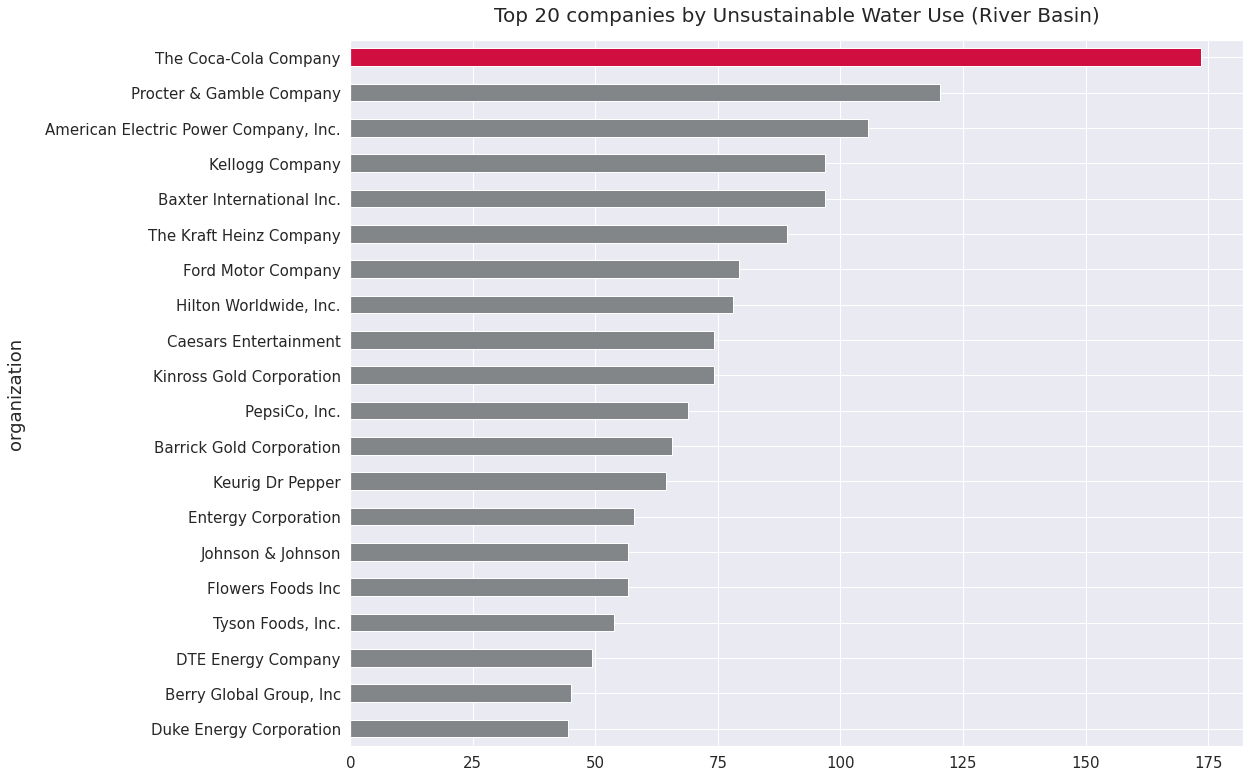

In [78]:
# joining with water stress data for river basins via river basin mapping
# ignoring facilities with no consumption
w5_1a = w5_1[w5_1[c] > 0].join(RIVER_BASINS.set_index('river_basin_cdp'), on='River basin') \
.join(water_stress_basin['All sectors'], on='river_basin')

# fill values for river basins not present in water stress data with upper & lower quantile scores for Yes and No, and mean score for Unknown
w5_1a['All sectors'].fillna(w5_1a['Water Stressed Area'].map({
    'Yes': water_stress_basin['All sectors'].quantile(0.75), 
    'Unknown': water_stress_basin['All sectors'].mean(), 
    'No': water_stress_basin['All sectors'].quantile(0.25)
}), inplace=True)

# calculating unsustainable water consumption score for each facility
w5_1a['score'] = w5_1a['All sectors'] * np.log10(1 + w5_1a[c]) #* w5_1a[c]/w5_1a[w]
# w5_1a.sort_values(c, ascending=False)
w5_1a.groupby('organization')['score'].sum().round(3).sort_values(ascending=False)[:20] \
.plot.barh(color=palette[:1]+[grey]*19,
          title='Top 20 companies by Unsustainable Water Use (River Basin)');
plt.gca().invert_yaxis()

The facilities can once more be mapped out, but this time coloured by how they score on _Unsustainable Water Use,_ and overlaid on the baseline water stress at the country level. This enhances our understanding regarding the _contribution_ of these facilities towards increasing the water stress in already stressed regions.

In [79]:
# calculating average scores for each river basin
w5_1plot = w5_1a.groupby(['Country/Area', 'River basin', 'Water Stressed Area',
               'Latitude', 'Longitude'])[[c, 'score']].mean().reset_index()

# visualizing unsustainable water consumption
fig = px.scatter_geo(w5_1plot, lat='Latitude',
               lon='Longitude', 
               color='score',
               hover_data=[c, 'Country/Area', 'River basin'],
#                projection="natural earth",        
               size='score',
               size_max=14,
               title='Average Unsustainable Water Use scores for facilities',
               color_continuous_scale=px.colors.sequential.Reds,

)
fig.update_layout(height=480, margin={"r":0,"t":30,"l":0,"b":0})
fig.update_geos(resolution=50, showcountries=True, countrywidth=0.2, showrivers=True, showlakes=True,
                showframe=False, showcoastlines=False,  rivercolor='#97B9DD')

fig.add_trace(
    fig_c.data[0]
)
fig.show()

Similarly, we can find country-level _Unsustainable Water Use_ by scoring corporation water use by the country/region they operate in. The scores for the top 20 companies for any single region are presented below. 

In [80]:
# change country names to match  water stress data
w5_1['Country/Area'] = w5_1['Country/Area'].replace({
    'Republic of Korea': 'South Korea',
    'Taiwan, Greater China': 'Taiwan',
    'Puerto Rico': '',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Russian Federation': 'Russia',
    'CÃ´te d\'Ivoire': 'Ivory Coast',
    'Viet Nam': 'Vietnam',
    'North Macedonia': 'Macedonia',
    'China, Hong Kong Special Administrative Region': 'Hong Kong'
})

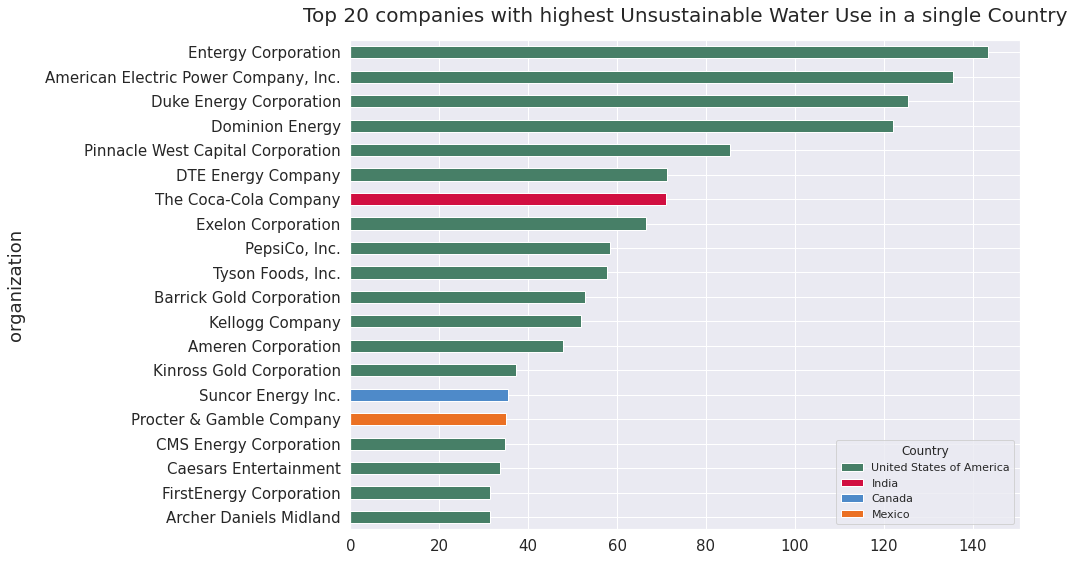

In [81]:
# join water consumption data with water stress scores and iso codes
# ignoring facilities with no consumption
w5_1b = w5_1[w5_1[c] > 0].join(water_stress_country[['All sectors', 'alpha-3']], on='Country/Area')

# fill values for countries/regions not present in water stress data with quantile scores for Yes and No, and mean score for Unknown
w5_1b['All sectors'].fillna(w5_1b['Water Stressed Area'].map({
    'Yes': water_stress_country['All sectors'].quantile(0.75), 
    'Unknown': water_stress_country['All sectors'].mean(), 
    'No': water_stress_country['All sectors'].quantile(0.25)
}), inplace=True)

# calculate unsustainbable water use score
w5_1b['score'] = w5_1b['All sectors'] * np.log10(1 + w5_1b[c]) # * w5_1b[c]/w5_1b[w]
# create counter to keep track of number of facilities
w5_1b['facilities'] = 1

w5_1b.groupby(['organization', 'Country/Area'])[['score', c, w, d, 'facilities']].sum() \
.sort_values('score', ascending=False)[:20].unstack().plot.barh(y='score', stacked=True, figsize=(12, 9), 
color=[qualitative[-3:-2]]+ palette, title='Top 20 companies with highest Unsustainable Water Use in a single Country').legend(title='Country')
plt.gca().invert_yaxis()

The data skews highly towards the USA simply because the responses are from companies located in the USA and Canada, and it is likely that most of the facilties will be located there too. However, we can still calculate the _mean Unsustainable Water Use_ score for each country to get an idea about how much an average facility located there might be impacting water resources. 

In [82]:
# calculate average score for each country
w5_1plot2 = w5_1b.groupby(['Country/Area', 'alpha-3'])[['score', c, 'facilities']].sum().reset_index()
w5_1plot2['mean_score'] = w5_1plot2['score']/w5_1plot2['facilities']

# visualize average country level unsustainable water consumption
fig = px.choropleth(w5_1plot2, locations="alpha-3",
                    color="mean_score",
                    hover_data=["Country/Area", 'facilities'],
                    color_continuous_scale=px.colors.sequential.OrRd,
#                     projection='natural earth',
                    title='Unsustainable water consumption at country level'
                   )
fig.update_layout(height=440, margin={"r":0,"t":30,"l":0,"b":0})
fig.update_geos(resolution=50, showcountries=True, countrywidth=0.2, showrivers=True, showlakes=True,
                showframe=False, showcoastlines=False, rivercolor='#97B9DD')

---

Clean freshwater is essential for a healthy human life, however, 1.1 billion people lack access to water and 2.7 billion experience water scarcity at least one month a year.[<sup>[Link]</sup>](https://wwf.to/36vR3YW) The analysis conducted in this section shows how large corporations use massive quantities of water for electricity generation and to conduct their operations. In many of the cases, this water comes from water-stressed areaa, resulting in further aggravation of water-scarcity related issues in these basins, and affecting the local populations and the ecology dependent on these water sources. 

---

<h1 style="color: #FFFFFF" id="collaboration">8 Collaboration</h1>

<img src="https://media.istockphoto.com/vectors/raised-hands-helping-hands-team-work-collaboration-illustration-vector-id830356322?k=6&m=830356322&s=170667a&w=0&h=Co7OUUpoEjo0Q3ZGPA7liB7e8XIOX3slavvNEycBnzg=">


Illustration from [iStock](https://media.istockphoto.com/vectors/raised-hands-helping-hands-team-work-collaboration-illustration-vector-id830356322)
<br>

Looking at the previous sections we see a very disturbing trend of corporate overconsumption against a backdrop of inequality. In all these cases, corporate actions such as GHG emissions, use of unclean fuels, and over consumption of water from stressed resources, are seen to disproportionately affect those who are already prone to worst affects of climate change. This makes it clear that climate change, in addition to being a health issue and an existential issue, is more importantly a social issue. It is a challenge that is extremely complex and does not have a one size fits all solution, but it's a challenge that can drive human innovation to create sustainable solutions.

Using the Questionnaire data, we start by looking at the ways cities are already collaborating with businesses in the city and then create metrics that encourage collaborative actions.

In [83]:
# query city respinse data on collaborations
c6_2a = get_cities('6.2a').pivot(index=['City', 'Account Number', 'Row Number'], columns=['Column Name'])['Response Answer']

# replaceing all self defined catergories with 'Others'
c6_2a.loc[c6_2a['Type of collaboration'].str.contains('Other, ', na=False), 'Type of collaboration'] = 'Others'

collab_area = c6_2a.groupby('Collaboration area')['Type of collaboration'].value_counts().unstack()
collab_area.fillna(0).astype('int32').style.background_gradient('Reds') #.set_properties(**{'font-size': '20px'}) 
# sns.jointplot();

# c6_2a['Type of collaboration'].value_counts()

# plt.subplots(figsize=(12, 8))
# sns.heatmap(c6_2a[cols], annot=True);
# plt.xticks(rotation=65, horizontalalignment='right',)
# plt.title('City and business collaborations (2020)')
# plt.show()

We find that several initiatives are focussed towards Energy. In addition, Transport, Waste, and Water, seem to be noteworthy areas for collaboration. We can see that cities are actively making efforts to collaborate with businesses, so it would be extremely useful if there was a way to measure collaboration ability between a city and a corporation. And so we present our final metric.

---
<strong id="#metric12"><em>Metric 12: Collaboration Strength</em></strong>  
_A measure of the joint interest and expected mutual benefits from collaborative partnerships between cities and corporations on shared risks, opportunities, and initiatives._
<br><br>

$$ CollaborationStrength_{city,org}  = SharedRisk \times CommonOpportunities \times \mathtt{SERO}Score_{city,org},$$
<br><br>
$\begin{align} &\text{where } \quad  \mathtt{SERO}Score_{city,org}  = 5 -\frac{\sum_{i=1}^{mitigationActions_{city}}\sum_{j=1}^{reductionInitiatives_{org}}\mathtt{WordMoversDistance}(i, j)}{No.ofMitigationActions \times No.ofReductionInitiatives} \\ \\ & \text{and } \quad org \text{ is a corporation headquartered in } city \\ \\
(\mathtt{SERO} &= \text{Similarity in Emission Reduction Objectives})
\end{align}$
<br><br>

**Rationale**  
_Collaboration Strength_ is a metric that applies to pairs of cities and organizations, and thereby seeks to provide a score for the shared incentives that may be realized through joint initiatives. It is measured by taking into account the shared risks and objectives of cities with the corporations that have a presence in them. The shared objectives themselves are derived by finding overlaps between the city and corporate responses in the CDP Questionnaires. These include common opportunities and similarities in their strategies for emission reduction. _Collaboration Strength,_ therefore, enables cities to find corporations that are most suitable to work with to achieve their climate goals.

---

Since we only consider collaboration possibilities between corporations and cities which contain their headquarters, larger cities with high numbers of listed corporations are going to have more possibilites of finding suitable collaboration partners. The following visualization shows cities by the number of disclosing corporations headquartered in them.

In [84]:
collab_frame = corp_locations.join(city_locations[['lon', 'lat']], on=['cleaned_address_city', 'hq_country'], how='inner')

plot3 = collab_frame.groupby(['hq_country', 'cleaned_address_city', 'lon', 'lat'])['cleaned_name'].count().rename('HQ Count')

fig =  px.scatter_geo(plot3.reset_index(), lat='lat',
            lon='lon', 
            text='cleaned_address_city',
            scope='north america',
            size='HQ Count',
            color_discrete_sequence=palette[:1],
            title='Cities by number of reporting corporate HQs',
)
fig.update_layout(height=560, margin={"r":0,"t":30,"l":0,"b":0})
fig.update_geos(showcountries=True, countrywidth=0.2, showcoastlines=False)

### Collaboration by Shared Risks

To find the shared risks between cities and corporations, we return to the risk mapping we had used earlier in our vulnerability assessment for corporations. As a reminder, the mapping is between the climate change and water-related **physical risks** that corporations face and climate hazards and water security risks which cities are prone to. This can be used with the idea that corporations located in cities facing similar issues as them have a greater incentive to work together in tackling these problems.

In [85]:
# get corporate climate risk data
corp_climate_risks = get_climate('C2.3a').pivot(index=['organization', 'account_number', 'row_number'], columns='column_name') \
['response_value']['C2.3a_C3Risk type & Primary climate-related risk driver']

# query data from questions on water risks (direct and indirect operations)
w4_2 = get_water('W4.2').pivot(index=['organization', 'account_number', 'row_number'], columns='column_name')['response_value']
w4_2a = get_water('W4.2a').pivot(index=['organization', 'account_number','row_number'], columns='column_name')['response_value']

# standardizing columns

w4_2.columns = ['Potential financial impact figure - minimum (currency)',
       'Potential financial impact figure - maximum (currency)',
       'Explanation of financial impact',
       'Primary response to risk', 'Description of response',
       'Cost of response', 'Explanation of cost of response',
       'Country/Area & River basin',
       'Country/Area & River basin_G',
       'Type of risk & Primary risk driver',
       'Type of risk & Primary risk driver_G',
       'Primary potential impact',
       'Company-specific description', 'Timeframe',
       'Magnitude of potential impact', 'Likelihood',
       'Are you able to provide a potential financial impact figure?',
       'Potential financial impact figure (currency)']

w4_2a.columns = ['Potential financial impact figure (currency)',
       'Potential financial impact figure - minimum (currency)',
       'Potential financial impact figure - maximum (currency)',
       'Explanation of financial impact',
       'Primary response to risk',
       'Primary response to risk_G',
       'Description of response', 'Cost of response',
       'Explanation of cost of response',
       'Country/Area & River basin',
       'Country/Area & River basin_G', 'Stage of value chain',
       'Type of risk & Primary risk driver',
       'Type of risk & Primary risk driver_G',
       'Primary potential impact',
       'Company-specific description', 'Timeframe',
       'Magnitude of potential impact', 'Likelihood',
       'Are you able to provide a potential financial impact figure?']

# combine the 2 dataframes
w4_2concat = pd.concat([w4_2, w4_2a]).sort_values('organization')

# get corporate water risk data
corp_water_risks = w4_2concat['Type of risk & Primary risk driver']

# combine climate and water risks
corp_risks = pd.concat([corp_climate_risks, corp_water_risks]).dropna()
corp_risks = corp_risks.to_frame().join(corp_locations).reset_index().rename(columns={0: 'corporate_risk'})

In [86]:
# get city climate hazards data
c2_1 = get_cities('2.1', cols=['Country', 'City', 'Account Number'])
city_climate_hazards = c2_1[c2_1['Column Name']=='Climate Hazards'].set_index(['Country', 'City', 'Account Number'])['Response Answer']

# get city water risk data
city_water_risks = get_cities('14.2a', cols=['Country', 'City', 'Account Number']) \
    .pivot(index=['Country', 'City', 'Account Number', 'Row Number'], columns='Column Name')['Response Answer']['Water security risk drivers']

# concatenate climate and water risks, and remove data where no city name is given 
city_risks = pd.concat([city_climate_hazards, city_water_risks]).to_frame().sort_index().reset_index().dropna().rename(columns={0: 'city_risk'})

By filtering for common location, and applying the risk mapping to match corporates with cities, we can measure the number of shared risks.

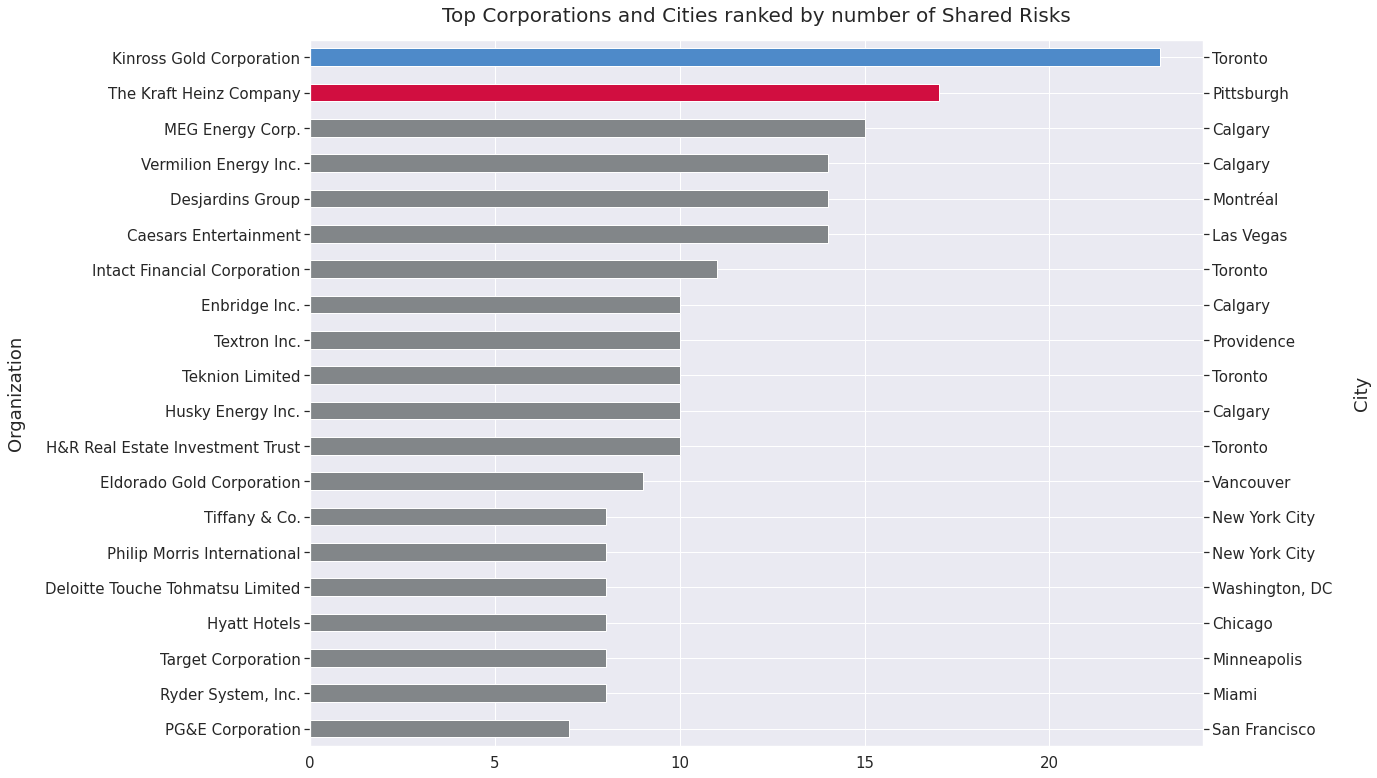

In [87]:
# join city data with corporate data via the risk mapping defined above
collab_frame['Shared Risks'] = corp_risks.join(risk_mapping.set_index('corporate_risk'), on='corporate_risk',  how='inner') \
         .join(city_risks.set_index(['city_risk', 'Country', 'City']), on=['city_risk', 'hq_country', 'cleaned_address_city'], how='inner') \
         .groupby(['Account Number', 'hq_country', 'cleaned_address_city', 'organization', 'account_number'])['corporate_risk'].count() \
         .reset_index([0,1,2], drop=True)

collab_frame.sort_values('Shared Risks', inplace=True)
temp = collab_frame.dropna(subset=['Shared Risks'])[-20:].reset_index()

fig, ax = plt.subplots()
ax2 = ax.twinx()
temp.plot.barh(x='organization', y='Shared Risks', ax=ax, legend=False, xlabel='Organization',
               title='Top Corporations and Cities ranked by number of Shared Risks');

temp.plot.barh(x='cleaned_address_city', y='Shared Risks', ax=ax2, legend=False,  
               color=[grey]*18 + palette[:2], xlabel='City');

### Collaboration by Identified Opportunities

Likewise, we create a mapping between the common opportunity drivers for cities and corporations. Similar opportunities which are likely to benefit both the city and the corporation would further their interests in collaborating. In the next visualization, we see the top cities and corporations that have similar or related opportunities

In [88]:
# mapping between city and corporate opportunity drivers
opportunity_mapping = pd.DataFrame([
    ('Development of clean energy technologies/businesses', 'Use of more efficient modes of transport'),
    ('Development of sustainable transport sector', 'Use of more efficient modes of transport'),
    ('Development of circular economy models and businesses', 'Use of more efficient production and distribution processes'),
    ('Development of local sustainable food businesses', 'Use of more efficient production and distribution processes'),
    ('Increased opportunities for investment in infrastructure projects', 'Use of more efficient production and distribution processes'),
    ('Increased opportunities for trade (nationally or internationally)', 'Use of more efficient production and distribution processes'),
    ('Development of waste management sector', 'Use of recycling'),
    ('Development of circular economy models and businesses', 'Use of recycling'),
    ('Development of resource conservation and management', 'Use of recycling'),
    ('Reduced risk to natural capital', 'Use of recycling'),
    ('Development of energy efficiency measures and technologies', 'Move to more efficient buildings'),
    ('Increased opportunities for investment in infrastructure projects', 'Move to more efficient buildings'),
    ('Development of sustainable construction/real estate sector', 'Move to more efficient buildings'),
    ('Development of water management sector', 'Reduced water usage and consumption'),
    ('Increased water security', 'Reduced water usage and consumption'),
    ('Development of resource conservation and management', 'Reduced water usage and consumption'),
    ('Development of clean energy technologies/businesses', 'Use of lower-emission sources of energy'),
    ('Development of energy efficiency measures and technologies', 'Use of lower-emission sources of energy'),
    ('Creation/development of carbon markets', 'Use of supportive policy incentives'),
    ('Development of clean energy technologies/businesses', 'Use of supportive policy incentives'),
    ('Development of energy efficiency measures and technologies', 'Use of supportive policy incentives'),
    ('Development of clean energy technologies/businesses', 'Use of new technologies'),
    ('Development of energy efficiency measures and technologies', 'Use of new technologies'),
    ('Carbon tax revenue', 'Participation in carbon market'),
    ('Creation/development of carbon markets', 'Participation in carbon market'),
    ('Development of energy efficiency measures and technologies', 'Shift toward decentralized energy generation'),
    ('Increased energy security', 'Shift toward decentralized energy generation'),
    ('Development of resource conservation and management', 'Development and/or expansion of low emission goods and services'),
    ('Development of circular economy models and businesses', 'Development and/or expansion of low emission goods and services'),
    ('Development of climate change resiliency projects', 'Development of climate adaptation, resilience and insurance risk solutions'),
    ('Development of resource conservation and management', 'Development of climate adaptation, resilience and insurance risk solutions'),
    ('Development of circular economy models and businesses', 'Development of new products or services through R&D and innovation'),
    ('Increase opportunities for partnerships', 'Ability to diversify business activities'),
    ('Increase opportunities for partnerships', 'Shift in consumer preferences'),
    ('Increase opportunities for partnerships', 'Reputational benefits resulting in increased demand for goods/services [Financial services only]'),
    ('Development of energy efficiency measures and technologies', 'Participation in renewable energy programs and adoption of energy-efficiency measures'),
    ('Development of clean energy technologies/businesses', 'Participation in renewable energy programs and adoption of energy-efficiency measures'),
    ('Development of resource conservation and management', 'Resource substitutes/diversification'),
    ('Development of circular economy models and businesses', 'Resource substitutes/diversification'),
    ('Development of climate change resiliency projects', 'Increased reliability, climate- resilience of investment chain'),
    ('Development of water management sector', 'Cost savings'),
    ('Increased opportunities for investment in infrastructure projects', 'Cost savings'),
    ('Increased opportunities for investment in infrastructure projects', 'Improved field recovery factor (oil & gas sector only)'),
    ('Increase opportunities for partnerships', 'Improved field recovery factor (oil & gas sector only)'),
    ('Development of water management sector', 'Improved water efficiency in operations'),
    ('Development of resource conservation and management', 'Improved water efficiency in operations'),
    ('Increased water security', 'Improved water efficiency in operations'),
    ('Development of water management sector', 'Water recovery from sewage management'),
    ('Development of waste management sector', 'Water recovery from sewage management'),
    ('Increased opportunities for investment in infrastructure projects', 'Water recovery from sewage management'),
    ('Development of resource conservation and management', 'Water recovery from sewage management'),
    ('Increased opportunities for investment in infrastructure projects', 'Increased resilience to impacts of climate change'),
    ('Improved flood risk mitigation', 'Increased resilience to impacts of climate change'),
    ('Development of climate change resiliency projects', 'Increased resilience to impacts of climate change'),
    ('Development of climate change resiliency projects', 'Increased supply chain resilience'),
    ('Additional funding opportunities', 'New R&D opportunities'),
    ('Development of circular economy models and businesses', 'Reduced impact of product use on water resources'),
    ('Increased water security', 'Reduced impact of product use on water resources'),
    ('Reduced risk to natural capital', 'Reduced impact of product use on water resources')
], columns=['city_opportunity', 'corp_opportunity'])

opportunity_mapping[:20].style.set_caption('Sample from the opportunity mapping')

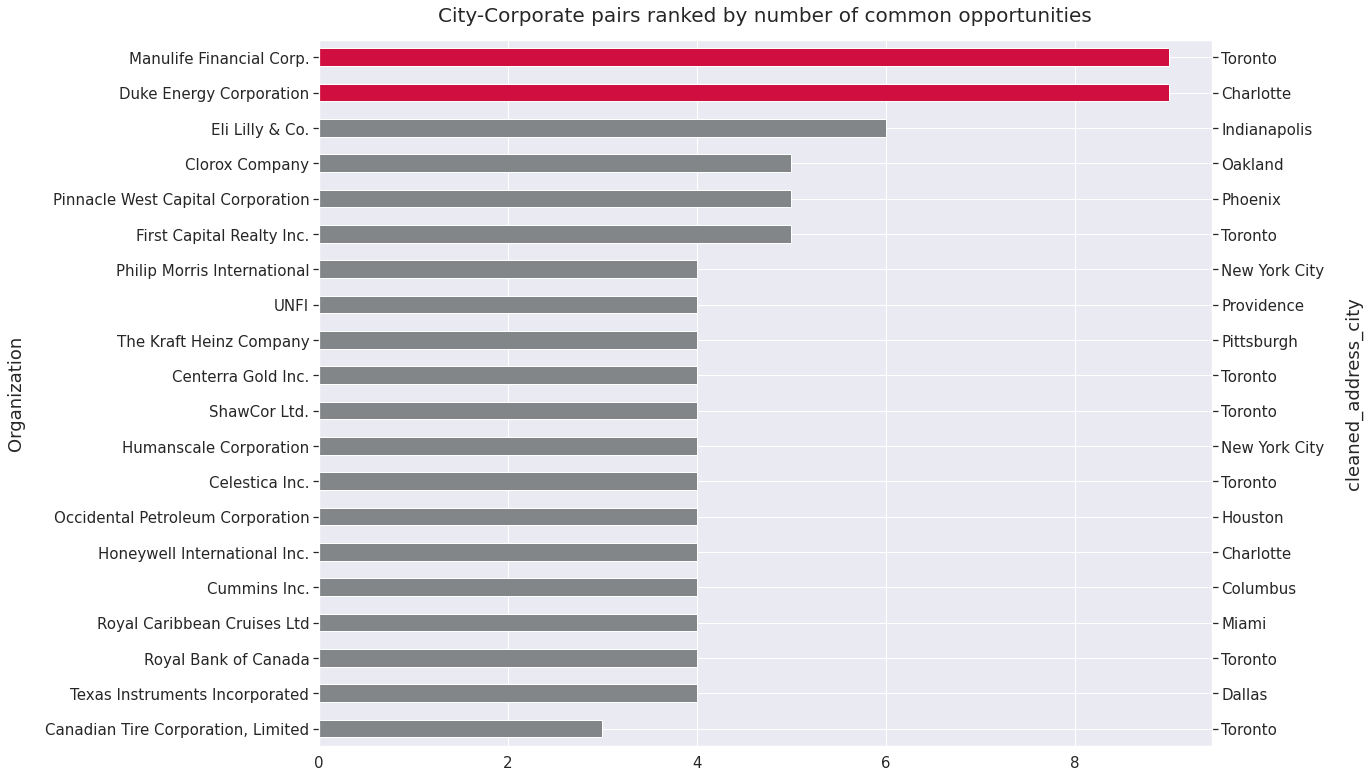

In [89]:
# creating city opportunity driver dataframe
city_opp = c6['Opportunity'].reset_index().set_index(['Opportunity', 'Country', 'City']).drop('Row Number', axis=1)

# get climate chage related opportunity data 
c2_4a = get_climate('C2.4a').pivot(index=['organization', 'account_number', 'row_number'], columns='column_name')['response_value']

# get water related opportunity data
w4_3a = get_water('W4.3a').pivot(index=['organization', 'account_number', 'row_number'], columns='column_name')['response_value']

# combining climate and water related opportunity drivers for corporates and joining with corporate location data
corp_opp = pd.concat([c2_4a['C2.4a_C4Primary climate-related opportunity driver'], w4_3a['W4.3a_C2Primary water-related opportunity']]) \
.reset_index().join(corp_locations, on=['organization', 'account_number']).drop('row_number', axis=1).rename(columns={0: 'corp_opp_driver'})

# finding overlap between opportunity drivers for cities and corporates with HQs within them
collab_frame['Opportunities'] = corp_opp.join(opportunity_mapping.set_index('corp_opportunity'), on='corp_opp_driver', how='inner') \
        .join(city_opp, on=['city_opportunity', 'hq_country', 'cleaned_address_city'], how='inner') \
        .groupby(['Account Number', 'hq_country', 'cleaned_address_city', 'organization', 'account_number'])['corp_opp_driver'].count() \
        .reset_index([0,1,2], drop=True)

collab_frame.sort_values('Opportunities', inplace=True)
temp = collab_frame.dropna(subset=['Opportunities'])[-20:].reset_index()

fig, ax = plt.subplots()
ax2 = ax.twinx()

temp[:20].reset_index().plot.barh(x='organization', y='Opportunities', ax=ax, legend=False, xlabel='Organization');

temp[:20].reset_index().plot.barh(x='cleaned_address_city', y='Opportunities', ax=ax2, legend=False,  color=[grey]*18 + palette[:1]*2,
               title='City-Corporate pairs ranked by number of common opportunities');

### Collaboration by Emission Reduction Initiatives

Next, we try to judge the similarity between city and corporate emission reduction strategies. For this, once we have grouped them by location, we calculate Word Mover's Distances (WMD) between each set of responses by a given city/corporate pair. Word Mover's Distance uses pre-trained Word Embeddings to calculate a distance (or negative similarity) score between strings, where an exact match returns 0. For our model, we use Google's [pre-trained word embeddings](https://code.google.com/archive/p/word2vec/). The average WMD distance between a city-corporate pair is then subtracted from 5 to invert values such that a higher similarity results in a hgher SERO score.

In [90]:
# query city data on emission reduction actions
c5_4 = get_cities('5.4', cols=['Country', 'City', 'Account Number']) \
.pivot_table(index=['Country', 'City', 'Account Number', 'Row Number'], columns=['Column Name'],
             aggfunc=lambda x: x.values[0] if len(list(x))==1 else list(x))['Response Answer']

# create a dataframe by joining corporate initiatives with cities they're headquartered in
emissions = piv4_3b[['C4.3b_C9Comment']].join(corp_locations) \
.join(c5_4.reset_index().set_index(['Country', 'City'])['Scope and impact of action'], on=['hq_country', 'cleaned_address_city'], how='inner')


# remove special chars/punctuation/diacritics, numbers, spaces, convert to lowercase, remove stopwords
emissions['city_initiative'] = emissions['Scope and impact of action'].fillna('') \
.apply(lambda x: re.sub(r'[!-/:-@\[-`\{-~‘’–]', '', x)).apply(lambda x: re.sub(r'[0-9]', '', x)) \
.apply(lambda x: re.sub(r'\s+', ' ', x.lower().strip())).apply(lambda x: [y for y in x.split() if y not in stop])

emissions['corp_initiative'] = emissions['C4.3b_C9Comment'].fillna('') \
.apply(lambda x: re.sub(r'[!-/:-@\[-`\{-~‘’–]', '', x)).apply(lambda x: re.sub(r'[0-9]', '', x)) \
.apply(lambda x: re.sub(r'\s+', ' ', x.lower().strip())).apply(lambda x: [y for y in x.split() if y not in stop])

In [ ]:
# load the Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format('../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin', binary=True)

# calculate word mover's distances between corporate and city initiatives to judge similarity
# this takes 20 mins approx
tqdm.pandas()
emissions['wmd_distance'] = emissions.progress_apply(lambda x: model.wmdistance(x['city_initiative'], x['corp_initiative']), axis=1)

 18%|█▊        | 3105/16983 [01:24<08:09, 28.36it/s] 

In [ ]:
# replacing infinities with 4.9 as the max distance
emissions['wmd_distance'] = emissions['wmd_distance'].replace(np.inf, 4.9)

# the mean of the WMD scores grouped by cities and organizations subracted from 5 gives us the SERO score
collab_frame['SERO Score'] = (5 - emissions.groupby(['hq_country', 'cleaned_address_city', 'organization', 'account_number'])['wmd_distance'].mean()) \
                            .reset_index([0,1], drop=True)

collab_frame.sort_values('SERO Score', inplace=True)
temp = collab_frame.dropna(subset=['SERO Score'])[-25:].reset_index()

fig, ax = plt.subplots()
ax2 = ax.twinx()

temp.plot.barh(x='organization', y='SERO Score', ax=ax, legend=False, xlabel='Organization');

temp.plot.barh(x='cleaned_address_city', y='SERO Score', ax=ax2, legend=False,  color=[grey]*23 + palette[:2],
               title='City-Corporate SERO Scores', xlabel='City');

In [ ]:
# calculating Collaboration Strength
collab_frame['Collaboration Strength'] = collab_frame['Shared Risks'] * collab_frame['Opportunities'] * collab_frame['SERO Score']

collab_frame.sort_values('Collaboration Strength', inplace=True)
temp = collab_frame.dropna(subset=['Collaboration Strength'])[-25:].reset_index()

fig, ax = plt.subplots()
ax2 = ax.twinx()

temp.plot.barh(x='organization', y='Collaboration Strength', ax=ax, legend=False, xlabel='Organization');

temp.plot.barh(x='cleaned_address_city', y='Collaboration Strength', ax=ax2, legend=False,  color=[grey]*23 + palette[:2],
               title='Top 20 City/Corporate pair by Collaboration Strength', xlabel='City');